We use data from HST's Wide Field & Planetary Camera 2 ([datasheet](https://www.stsci.edu/hst/instrumentation/legacy/wfpc2)) - files from pictures taken at 12 specific times, and for each specific time, we have a picture from two sensors, WF2 and WF3, which are aranged in the following configuration:<br>
![picture](https://drive.google.com/uc?id=1I3gUlDoOsO5DB7Cp2pTOUytIE9pzN4XK) <br>



WFPC2 is comprised of 4 electronic detector arrays, or chips. The upper right quadrant (quadrant 1) is smaller than the other three, and has higher image resolution. Quadrant 1 is the Planetary Camera, while the other three quadrants comprise the Wide Field Camera. Each detector chip is composed of an 800x800 square array of detectors. The chips are identical; the size and resolution of the planetary camera image results from optical elements in the light path.
In turn, they cover different parts of the field of view, even though the pictures are taken at the same time. An example pair in squared z-scale (WF2 on the left, WF3 on the right) taken at the sime time can be seen below:<br>
![picture](https://drive.google.com/uc?id=1ISDXjckjWOZSUPWWb3rxr4pqMWSKie8r) <br>

All of the files used in the experiment can be viewed here: [Cepheid folder](https://drive.google.com/uc?id=1I3gUlDoOsO5DB7Cp2pTOUytIE9pzN4XK). The star experiences variations in brightness over time, thus we will measure a certain number of regions in each picture, which correspond to different cepheids. An example in brightness variation for a single cepheid in different pictures:<br>

![picture](https://drive.google.com/uc?id=1ZlyCV2OV5W9nUigmqFgRuhcgUEgwOMKH) <br> 

We will record all pictures as Numpy arrays along with the corresponding date of the picture.

In [ ]:
%%capture
!pip install astropy
import os
import math
import warnings
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import fftpack
import astropy
from astropy.io.fits import getdata
from astropy.io.fits import getheader
from astropy.visualization import astropy_mpl_style
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')
plt.style.use('default')

PICTURES_DIR = '/content/drive/My Drive/1_code/1_datasets/cepheid_stars_hst_dataset/u_pictures/'
REGIONS_PATH = '/content/drive/My Drive/1_code/1_datasets/cepheid_stars_hst_dataset/regions.xlsx'
NUM_REGIONS_WF2 = 7
NUM_REGIONS_WF3 = 8

In [ ]:
# The following functions make use of circular masking from the OpenCV library
# with a demo after the images are read.


def star_calculations(image, regions):
    # Given a star image and a list of regions (x, y, radius)
    # returns the sum of the pixel values with corresponding errors and the
    # number of pixels for each respective region by drawing a black mask around
    # the region.
    # image = image + np.abs(np.min(image)) #optional normalisation to 0
    star_sums_array = np.array([])
    star_errors_array = np.array([])
    star_num_pixels_array = np.array([])
    for i, region in enumerate(regions):
        x, y, radius = np.round(region).astype(int)
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.circle(mask, (x, y), radius, 255, -1)
        masked = cv2.bitwise_and(image, image, mask=mask)
        sum = np.sum(masked)
        error = np.sqrt(sum)
        num_pixels = (masked != 0).sum()
        star_sums_array = np.append(star_sums_array, sum)
        star_errors_array = np.append(star_errors_array, error)
        star_num_pixels_array = np.append(star_num_pixels_array, num_pixels)
    return star_sums_array, star_errors_array, star_num_pixels_array


def background_calculations(image, background_regions):
    # Given a star image and a list of background regions (x, y, inner radius,
    # outer radius), returns the sums of the background pixel values and the
    # number of pixels for each respective background region.
    # image = image + np.abs(np.min(image)) #optional normalisation to 0
    backgrounds_sums_array = np.array([])
    background_errors_array = np.array([])
    background_pixels_array = np.array([])
    for i, background_region in enumerate(background_regions):
        # inner circle
        x, y, inner_radius, outer_radius = np.round(background_region).astype(int)
        inner_mask = np.zeros(image.shape[:2], dtype="uint8")
        outer_mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.circle(inner_mask, (x, y), inner_radius, 255, -1)
        cv2.circle(outer_mask, (x, y), outer_radius, 255, -1)
        inner_masked = cv2.bitwise_and(image, image, mask=inner_mask)
        outer_masked = cv2.bitwise_and(image, image, mask=outer_mask)
        inner_sum = np.sum(inner_masked)
        outer_sum = np.sum(outer_masked)
        inner_error = np.sqrt(inner_sum)
        outer_error = np.sqrt(outer_sum)
        inner_num_pixels = (inner_masked != 0).sum()
        outer_num_pixels = (outer_masked != 0).sum()
        background_sum = outer_sum - inner_sum
        background_error = np.sqrt(inner_num_pixels**2 + outer_num_pixels**2)
        total_pixels = outer_num_pixels - inner_num_pixels
        backgrounds_sums_array = np.append(backgrounds_sums_array, background_sum)
        background_errors_array = np.append(background_errors_array, background_error)
        background_pixels_array = np.append(background_pixels_array, total_pixels)
    return backgrounds_sums_array, background_errors_array, background_pixels_array


def subtract_background(
    star_sum, star_error, star_pixels, back_sum, back_error, back_pixels
):
    # Subtracts the region mean from background mean for a given region.
    star_mean = star_sum / star_pixels
    star_error = star_error / star_pixels
    back_mean = back_sum / back_pixels
    back_error = back_error / back_pixels
    star_counts = (star_mean - back_mean) * star_pixels
    star_counts_error = star_pixels * np.sqrt(star_error**2 + back_error**2)
    return star_counts, star_counts_error


def find_period_by_folding(abscissas, ordinates, candidate_periods):
    # Finds the best fitting potential period for abscissas and
    # ordinates which do not conform to an analytical function
    # given an array of candidate periods
    path_lengths_array = np.array([])
    for period in candidate_periods:
        phase_array = np.array([])
        for i in range(len(abscissas)):
            # phase fold
            phase = (abscissas[i] % period) / period
            phase_array = np.append(phase_array, phase)
        # calc path length
        individual_steps = np.array([])
        for i in range(0, len(abscissas) - 1):
            step_length = np.sqrt(
                (phase_array[i + 1] - phase_array[i]) ** 2
                + (ordinates[i + 1] - ordinates[i]) ** 2
            )
            individual_steps = np.append(individual_steps, step_length)
        path_length = np.sum(individual_steps)
        path_lengths_array = np.append(path_lengths_array, path_length)
    minimum_path_index = np.argmin(path_lengths_array)
    accepted_period = candidate_periods[minimum_path_index]
    return accepted_period


def si_classifier(val):
    suffixes = {
        24: {"long_suffix": "yotta", "short_suffix": "Y", "scalar": 10**24},
        21: {"long_suffix": "zetta", "short_suffix": "Z", "scalar": 10**21},
        18: {"long_suffix": "exa", "short_suffix": "E", "scalar": 10**18},
        15: {"long_suffix": "peta", "short_suffix": "P", "scalar": 10**15},
        12: {"long_suffix": "tera", "short_suffix": "T", "scalar": 10**12},
        9: {"long_suffix": "giga", "short_suffix": "G", "scalar": 10**9},
        6: {"long_suffix": "mega", "short_suffix": "M", "scalar": 10**6},
        3: {"long_suffix": "kilo", "short_suffix": "k", "scalar": 10**3},
        0: {"long_suffix": "", "short_suffix": "", "scalar": 10**0},
        -3: {"long_suffix": "milli", "short_suffix": "m", "scalar": 10**-3},
        -6: {"long_suffix": "micro", "short_suffix": "µ", "scalar": 10**-6},
        -9: {"long_suffix": "nano", "short_suffix": "n", "scalar": 10**-9},
        -12: {"long_suffix": "pico", "short_suffix": "p", "scalar": 10**-12},
        -15: {"long_suffix": "femto", "short_suffix": "f", "scalar": 10**-15},
        -18: {"long_suffix": "atto", "short_suffix": "a", "scalar": 10**-18},
        -21: {"long_suffix": "zepto", "short_suffix": "z", "scalar": 10**-21},
        -24: {"long_suffix": "yocto", "short_suffix": "y", "scalar": 10**-24},
    }
    exponent = int(math.floor(math.log10(abs(val)) / 3.0) * 3)
    return suffixes.get(exponent, None)


def si_formatter(value):
    """
    Return a triple of scaled value, short suffix, long suffix, or None if
    the value cannot be classified.
    """
    classifier = si_classifier(value)
    if classifier == None:
        # Don't know how to classify this value
        return None
    scaled = value / classifier["scalar"]
    return (scaled, classifier["short_suffix"], classifier["long_suffix"])


def si_format(value, precision=3, long_form=False, separator=""):
    """
    "SI prefix" formatted string: return a string with the given precision
    and an appropriate order-of-3-magnitudes suffix, e.g.:
        si_format(1001.0) => '1.00K'
        si_format(0.00000000123, long_form=True, separator=' ') => '1.230 nano'
    """
    scaled, short_suffix, long_suffix = si_formatter(value)

    if scaled == None:
        # Don't know how to format this value
        return value
    suffix = long_suffix if long_form else short_suffix

    if abs(scaled) < 10:
        precision = precision - 1
    elif abs(scaled) < 100:
        precision = precision - 2
    else:
        precision = precision - 3
    return "{scaled:.{precision}f}{separator} {suffix}".format(
        scaled=scaled, precision=precision, separator=separator, suffix=suffix
    )


**Data reading**

Here, we create name arrays for WF2/WF3 pictures and regions, and proceed to record corresponding pictures and start dates in the respective img_array_WFX and exp_start_array_WFX arrays. A random picture from both WF2 and WF3 is shown at the end of the cell. [Regions spreadsheet,](https://docs.google.com/spreadsheets/d/1-MSDyeEWrN0DgUc148Akl2sAiSpld0fP/edit?usp=sharing&ouid=108064564921058528721&rtpof=true&sd=true), [pictures folder](https://drive.google.com/drive/folders/1ttORqfSb62NaulH0ifzy_d9ySNlI5gIf?usp=sharing).

Randomly selected from WF2 u06_2.fits :


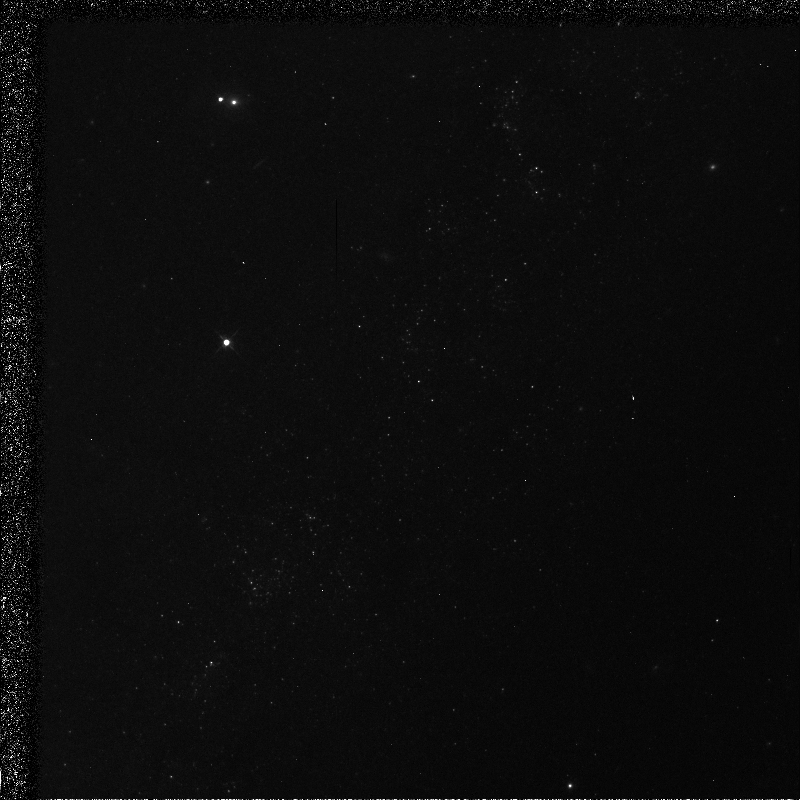

Randomly selected from WF3 u12_2.fits :


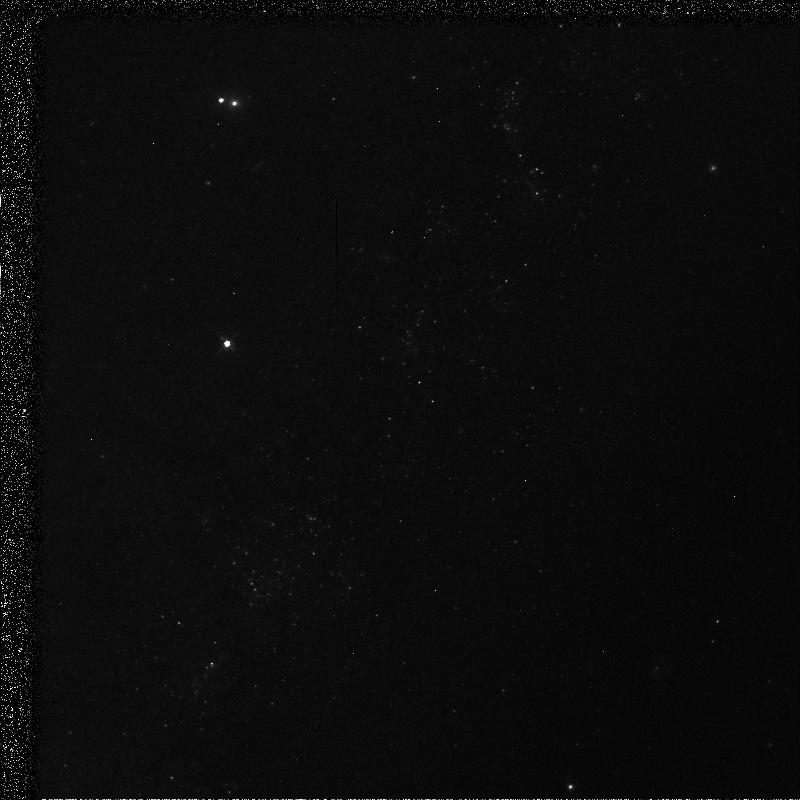

In [ ]:
# Initialise empty arrays for recording the image names and start dates for each image:
img_names = np.array(os.listdir(PICTURES_DIR))
img_names = np.sort(img_names)
img_names_WF2 = np.array([])
img_names_WF3 = np.array([])
img_array_WF2 = np.array([])
img_array_WF3 = np.array([])
exp_start_array_WF2 = np.array([])
exp_start_array_WF3 = np.array([])


# Split the image names for WF2 and WF3, initalise arrays for the images:
for i, name in enumerate(img_names):
    if (i % 2) == 0:
        img_names_WF2 = np.append(img_names_WF2, name)
    if (i % 2) == 1:
        img_names_WF3 = np.append(img_names_WF3, name)
random_picture_index_WF2 = np.random.randint(0, len(img_names_WF2))
random_picture_index_WF3 = np.random.randint(0, len(img_names_WF3))
img_shape_WF2 = np.shape(getdata(PICTURES_DIR + img_names[random_picture_index_WF2]))
img_shape_WF3 = np.shape(getdata(PICTURES_DIR + img_names[random_picture_index_WF3]))
img_array_WF2_shape = np.append(
    len(img_names_WF2), [img_shape_WF2[i] for i in range(len(img_shape_WF2))]
)
img_array_WF3_shape = np.append(
    len(img_names_WF3), [img_shape_WF3[i] for i in range(len(img_shape_WF3))]
)
img_array_WF2 = np.empty(img_array_WF2_shape)
img_array_WF3 = np.empty(img_array_WF3_shape)

# Read in the regions xlsx, initialise arrays for the regions
xls = pd.ExcelFile(REGIONS_PATH)
WF2_regions_stack = np.empty(
    np.append(len(img_names_WF2), (NUM_REGIONS_WF2, 3))
)  # x, y, radius
WF3_regions_stack = np.empty(np.append(len(img_names_WF3), (NUM_REGIONS_WF3, 3)))
WF2_background_regions_stack = np.empty(
    np.append(
        len(img_names_WF2), (NUM_REGIONS_WF2, 4)
    )  # x, y, inner radius, outter radius
)
WF3_background_regions_stack = np.empty(
    np.append(len(img_names_WF3), (NUM_REGIONS_WF3, 4))
)

for i in range(len(img_names_WF2)):
    WF2_regions_stack[i] = pd.read_excel(xls, "WF2_" + str(i + 1)).to_numpy()
    WF2_background_regions_stack[i] = pd.read_excel(
        xls, "WF2_background" + str(i + 1)
    ).to_numpy()
for i in range(len(img_names_WF3)):
    WF3_regions_stack[i] = pd.read_excel(xls, "WF3_" + str(i + 1)).to_numpy()
    WF3_background_regions_stack[i] = pd.read_excel(
        xls, "WF3_background" + str(i + 1)
    ).to_numpy()
# Read in the image name and start dates for each chip:
for i, name in enumerate(img_names_WF2):
    img, exp_start = (
        getdata(PICTURES_DIR + name),
        getheader(PICTURES_DIR + name)["EXPSTART"],
    )
    img_array_WF2[i] = img
    exp_start_array_WF2 = np.append(exp_start_array_WF2, exp_start)
    # print(name, str(getheader(PICTURES_DIR + name)["EXPSTART"]))
for i, name in enumerate(img_names_WF3):
    img, exp_start = (
        getdata(PICTURES_DIR + name),
        getheader(PICTURES_DIR + name)["EXPSTART"],
    )
    img_array_WF3[i] = img
    exp_start_array_WF3 = np.append(exp_start_array_WF3, exp_start)
    # print(name, str(getheader(PICTURES_DIR + name)["EXPSTART"]))
#  Display a random image from each image array:
print("Randomly selected from WF2", img_names_WF2[random_picture_index_WF2], ":")
cv2_imshow(img_array_WF2[random_picture_index_WF2])

print("Randomly selected from WF3", img_names_WF3[random_picture_index_WF3], ":")
cv2_imshow(img_array_WF3[random_picture_index_WF3])


Demo of circular masking (all pixels outside the given region are set to 0) on the picture above and region 2


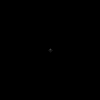

In [ ]:
# Demo, open image in new tab and zoom in

random_region_index_WF3 = np.random.randint(0, NUM_REGIONS_WF3)

print(
    "Demo of circular masking (all pixels outside the given region are set to 0) on the picture above and region",
    str(random_region_index_WF3),
)


test_img = img_array_WF3[random_picture_index_WF3]
x, y, radius = np.round(
    WF2_regions_stack[random_picture_index_WF3][random_region_index_WF3]
).astype(int)
mask = np.zeros(test_img.shape[:2], dtype="uint8")
# cv2.circle(image, center_coordinates, radius, color, thickness)
cv2.circle(mask, (x, y), radius, 255, -1)
masked = cv2.bitwise_and(test_img, test_img, mask=mask)
cv2_imshow(masked[(y - 50) : (y + 50), (x - 50) : (x + 50)])


We record the total pixel value sum, the error on that sum, and the pixel count for each region and each star. For the given conditions and assuming Poissonian statistics, the best estimate on the error is the square root of the measurement. As for the background, we draw a larger region around the star, and substract the the sum of the star pixels to find the background emission for each region. However, if we draw the regions too small, we might encounter problems due to a slight shift in the star coordinates (a couple of pixels at max):<br>

![picture](https://drive.google.com/uc?id=1Zo6v1kcIKv87i6JzqkveTooJdy_VGukY) <br> 

An example of the used anulus size for the background can be seen below:<br>

![picture](https://drive.google.com/uc?id=1N5ACS4zo7cHTOiflJH1qrxM74pfCYa1S) <br> 

In the end, we recorded the coordinates for each star and every picture separately.
Later, we perform the calculations specified in the functions section, and record the final counts value for each region for each chip separately.

In [ ]:
star_counts_array_WF2 = np.empty((np.append(len(img_array_WF2), NUM_REGIONS_WF2)))
star_errors_array_WF2 = np.empty((np.append(len(img_array_WF2), NUM_REGIONS_WF2)))
star_num_pixels_array_WF2 = np.empty((np.append(len(img_array_WF2), NUM_REGIONS_WF2)))
background_counts_array_WF2 = np.empty((np.append(len(img_array_WF2), NUM_REGIONS_WF2)))
background_errors_array_WF2 = np.empty((np.append(len(img_array_WF2), NUM_REGIONS_WF2)))
background_num_pixels_array_WF2 = np.empty(
    (np.append(len(img_array_WF2), NUM_REGIONS_WF2))
)
final_counts_array_WF2 = np.empty((np.append(len(img_array_WF2), NUM_REGIONS_WF2)))
final_errors_array_WF2 = np.empty((np.append(len(img_array_WF2), NUM_REGIONS_WF2)))

# Perform the required calculations from the function definitions recording
# the data in the previously specified arrays:

for i in range(len(img_array_WF2)):
    (
        star_counts_array_WF2[i],
        star_errors_array_WF2[i],
        star_num_pixels_array_WF2[i],
    ) = star_calculations(img_array_WF2[i], WF2_regions_stack[i])
    (
        background_counts_array_WF2[i],
        background_errors_array_WF2[i],
        background_num_pixels_array_WF2[i],
    ) = background_calculations(img_array_WF2[i], WF2_background_regions_stack[i])
    # 2D array with 12 rows representing each image data, and 7 columns for each region
    final_counts_array_WF2[i], final_errors_array_WF2[i] = subtract_background(
        star_counts_array_WF2[i],
        star_errors_array_WF2[i],
        star_num_pixels_array_WF2[i],
        background_counts_array_WF2[i],
        background_errors_array_WF2[i],
        background_num_pixels_array_WF2[i],
    )
    # print(str(i + 1))
    # print("Sum of the star:", str(star_counts_array_WF2[i]))
    # print("Star pixels:", str(star_num_pixels_array_WF2[i]))
    # print("Sum of the background:", str(background_counts_array_WF2[i]))
    # print("Background pixels:", str(background_num_pixels_array_WF2[i]))
    # print("Star minus background:", str(final_counts_array_WF2[i]), "\n")


In [ ]:
# @title Identical Calculations for WF3

star_counts_array_WF3 = np.empty((np.append(len(img_array_WF3), NUM_REGIONS_WF3)))
star_errors_array_WF3 = np.empty((np.append(len(img_array_WF3), NUM_REGIONS_WF3)))
star_num_pixels_array_WF3 = np.empty((np.append(len(img_array_WF3), NUM_REGIONS_WF3)))
background_counts_array_WF3 = np.empty((np.append(len(img_array_WF3), NUM_REGIONS_WF3)))
background_errors_array_WF3 = np.empty((np.append(len(img_array_WF3), NUM_REGIONS_WF3)))
background_num_pixels_array_WF3 = np.empty(
    (np.append(len(img_array_WF3), NUM_REGIONS_WF3))
)
final_counts_array_WF3 = np.empty((np.append(len(img_array_WF3), NUM_REGIONS_WF3)))
final_errors_array_WF3 = np.empty((np.append(len(img_array_WF3), NUM_REGIONS_WF3)))

# Perform the required calculations from the function definitions recording
# the data in the previously specified arrays:

for i in range(len(img_array_WF3)):
    (
        star_counts_array_WF3[i],
        star_errors_array_WF3[i],
        star_num_pixels_array_WF3[i],
    ) = star_calculations(img_array_WF3[i], WF3_regions_stack[i])
    (
        background_counts_array_WF3[i],
        background_errors_array_WF3[i],
        background_num_pixels_array_WF3[i],
    ) = background_calculations(img_array_WF3[i], WF3_background_regions_stack[i])
    # 2D array with 12 rows representing each image data, and 7 columns for each region
    final_counts_array_WF3[i], final_errors_array_WF3[i] = subtract_background(
        star_counts_array_WF3[i],
        star_errors_array_WF3[i],
        star_num_pixels_array_WF3[i],
        background_counts_array_WF3[i],
        background_errors_array_WF3[i],
        background_num_pixels_array_WF3[i],
    )


*Measure the brightness of as many Cepheids as possible for each dataset, plot them appropriately on graphs
and deduce the period and luminosity of each Cepheid. You will need to bear in mind the shape of the
Cepheid light-curve (e.g. [1], [2]) and think about how to get the best possible fit of such a light-curve to
your data for each star.*

Finalising the data for the analysis:

In [ ]:
# Verify that start dates for all regions from both sensors are the same
print(
    "Are start array dates equal for the photos from both chips? ",
    str(np.equal(exp_start_array_WF2, exp_start_array_WF3)),
    "\n",
)

# so we save them as a single normalised array
dates = exp_start_array_WF2 - np.min(exp_start_array_WF2)
print("Dates array:", str(dates), "\n")

# In the following array we have each row representing a single of the
# total 15 regions (7 from WF2 and 8 from WF3), and columns representing variation
# of the brightness of those regions over the same time periods
counts = np.concatenate(
    (final_counts_array_WF2, final_counts_array_WF3), axis=1
)  # gives array 12 rows for each day, 15 columns for each cepheid
print("Shape of the full counts array:", np.shape(counts), "\n")

# Finally, the errors array is simply the element-wise square root of the counts
# errors = np.sqrt(np.abs(counts))
errors = np.concatenate((final_errors_array_WF2, final_errors_array_WF3), axis=1)


Are start array dates equal for the photos from both chips?  [ True  True  True  True  True  True  True  True  True  True  True  True] 

Dates array: [  0.           1.41388891   3.29444449   5.24305562   8.1326389
  10.82013894  14.71666668  19.75625008  25.13125005  32.38750009
  40.44930566 358.28610332] 

Shape of the full counts array: (12, 15) 



In [ ]:
exp_start_array_WF3

array([50923.29599608, 50924.70988499, 50926.59044057, 50928.5390517 ,
       50931.42863498, 50934.11613502, 50938.01266276, 50943.05224616,
       50948.42724613, 50955.68349617, 50963.74530174, 51281.5820994 ])

Hence, any of the specific cepheids can be plotted by:

We can quickly inspect if all of the datapoints for all cepheids make sense:

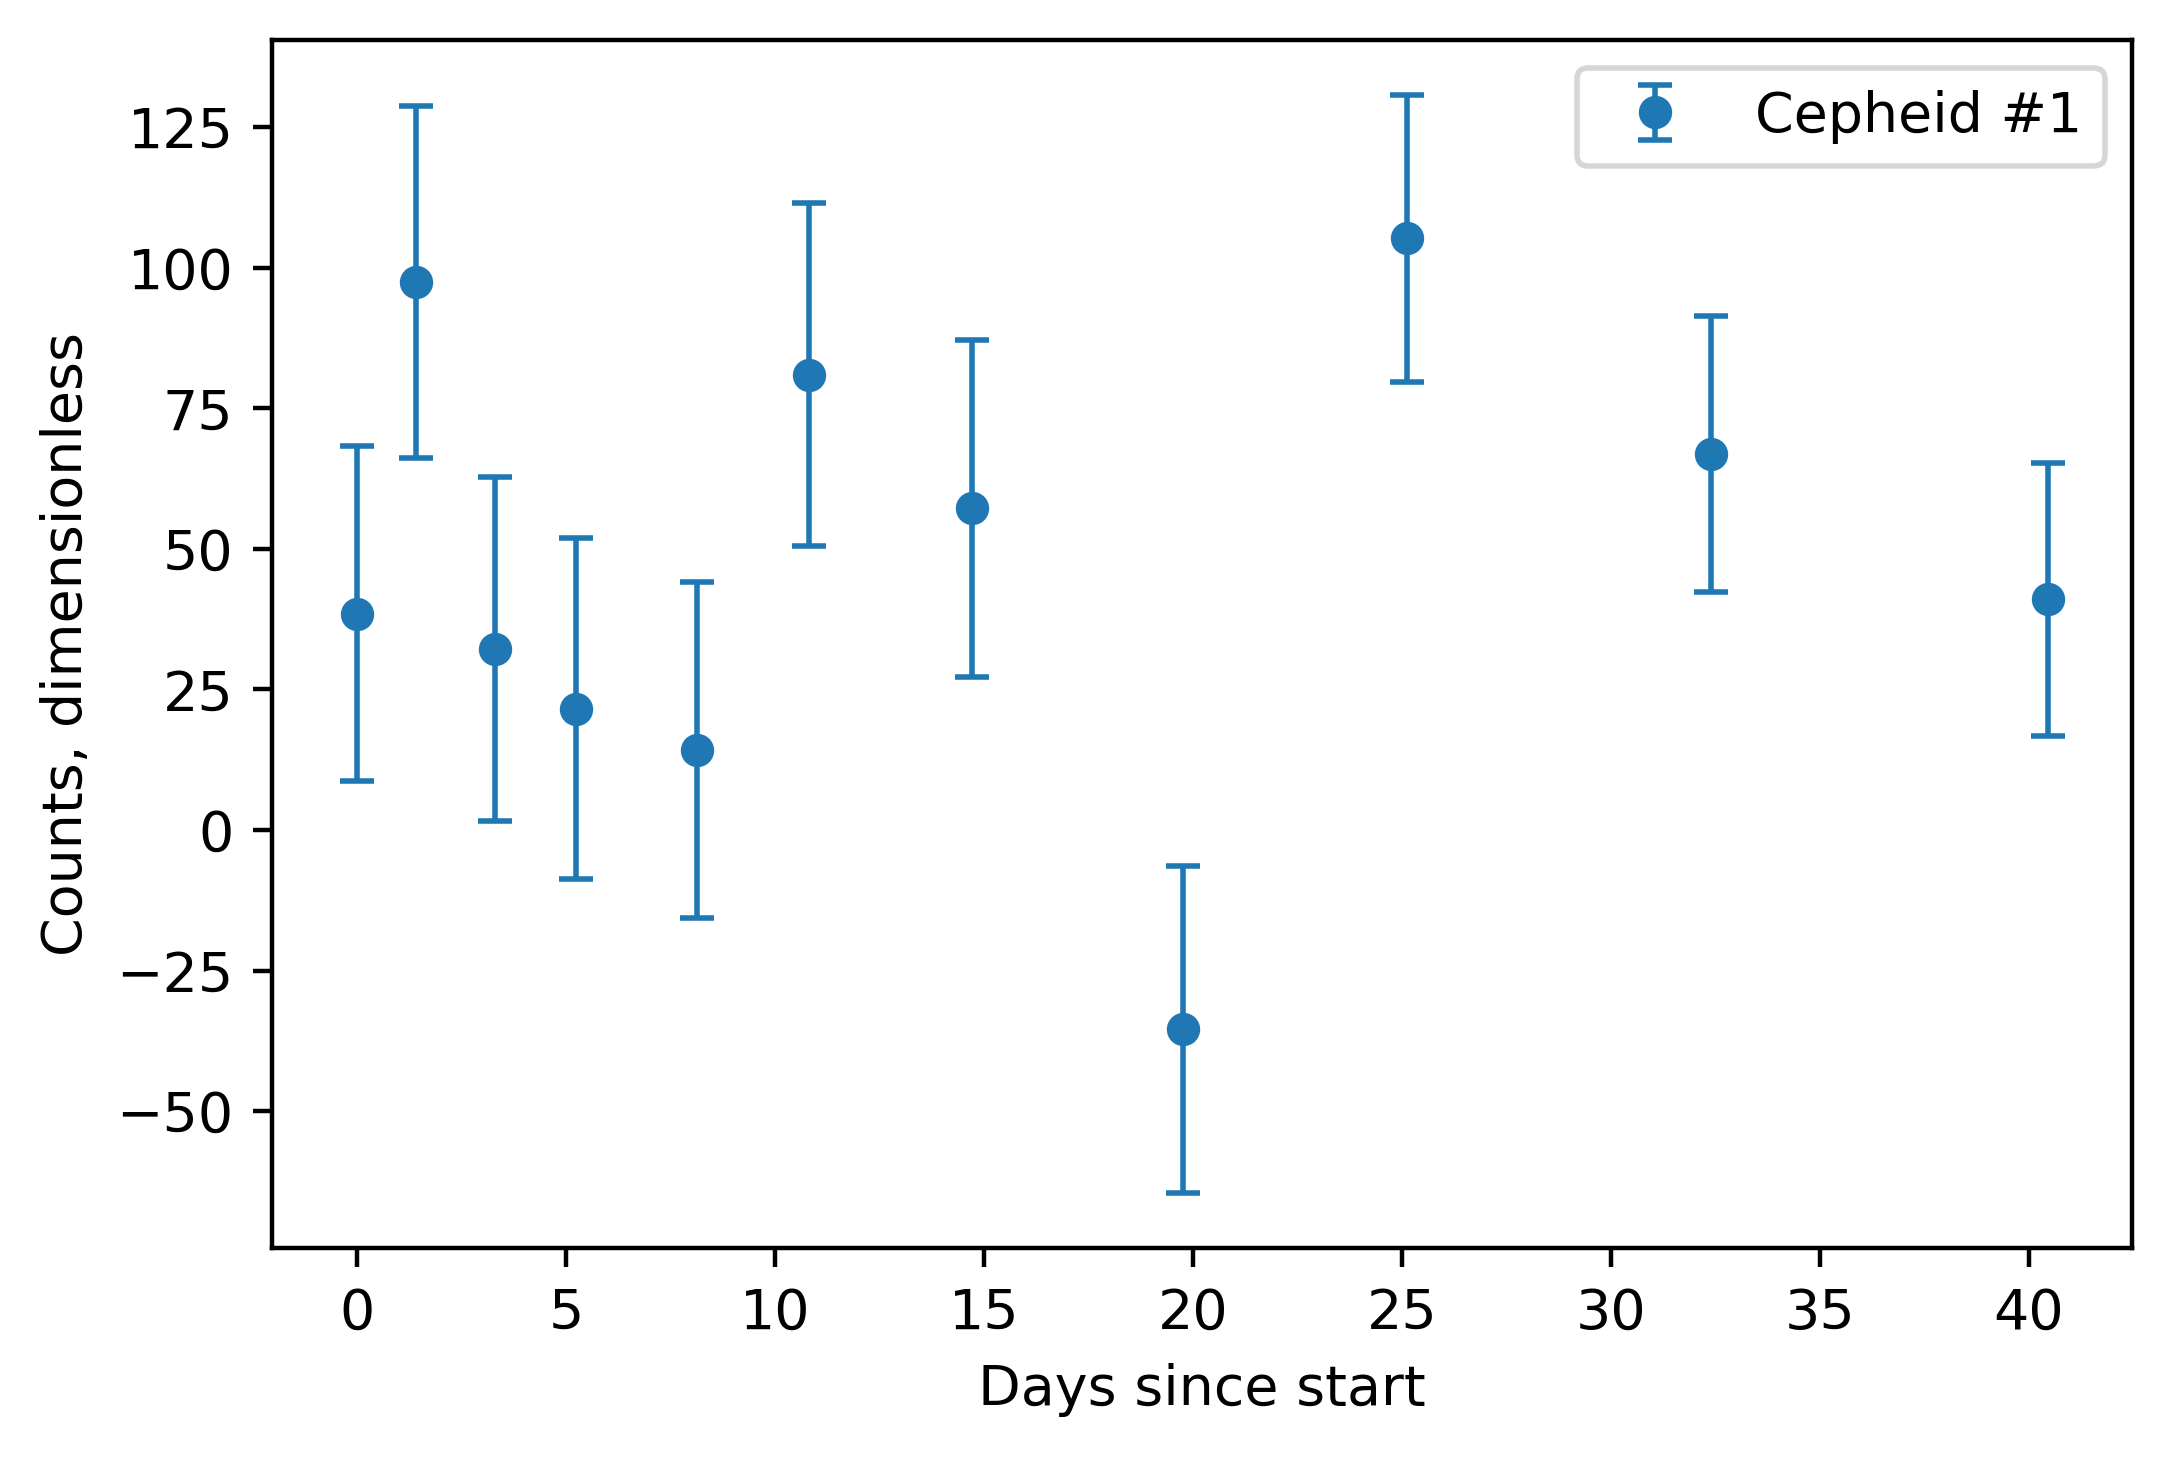

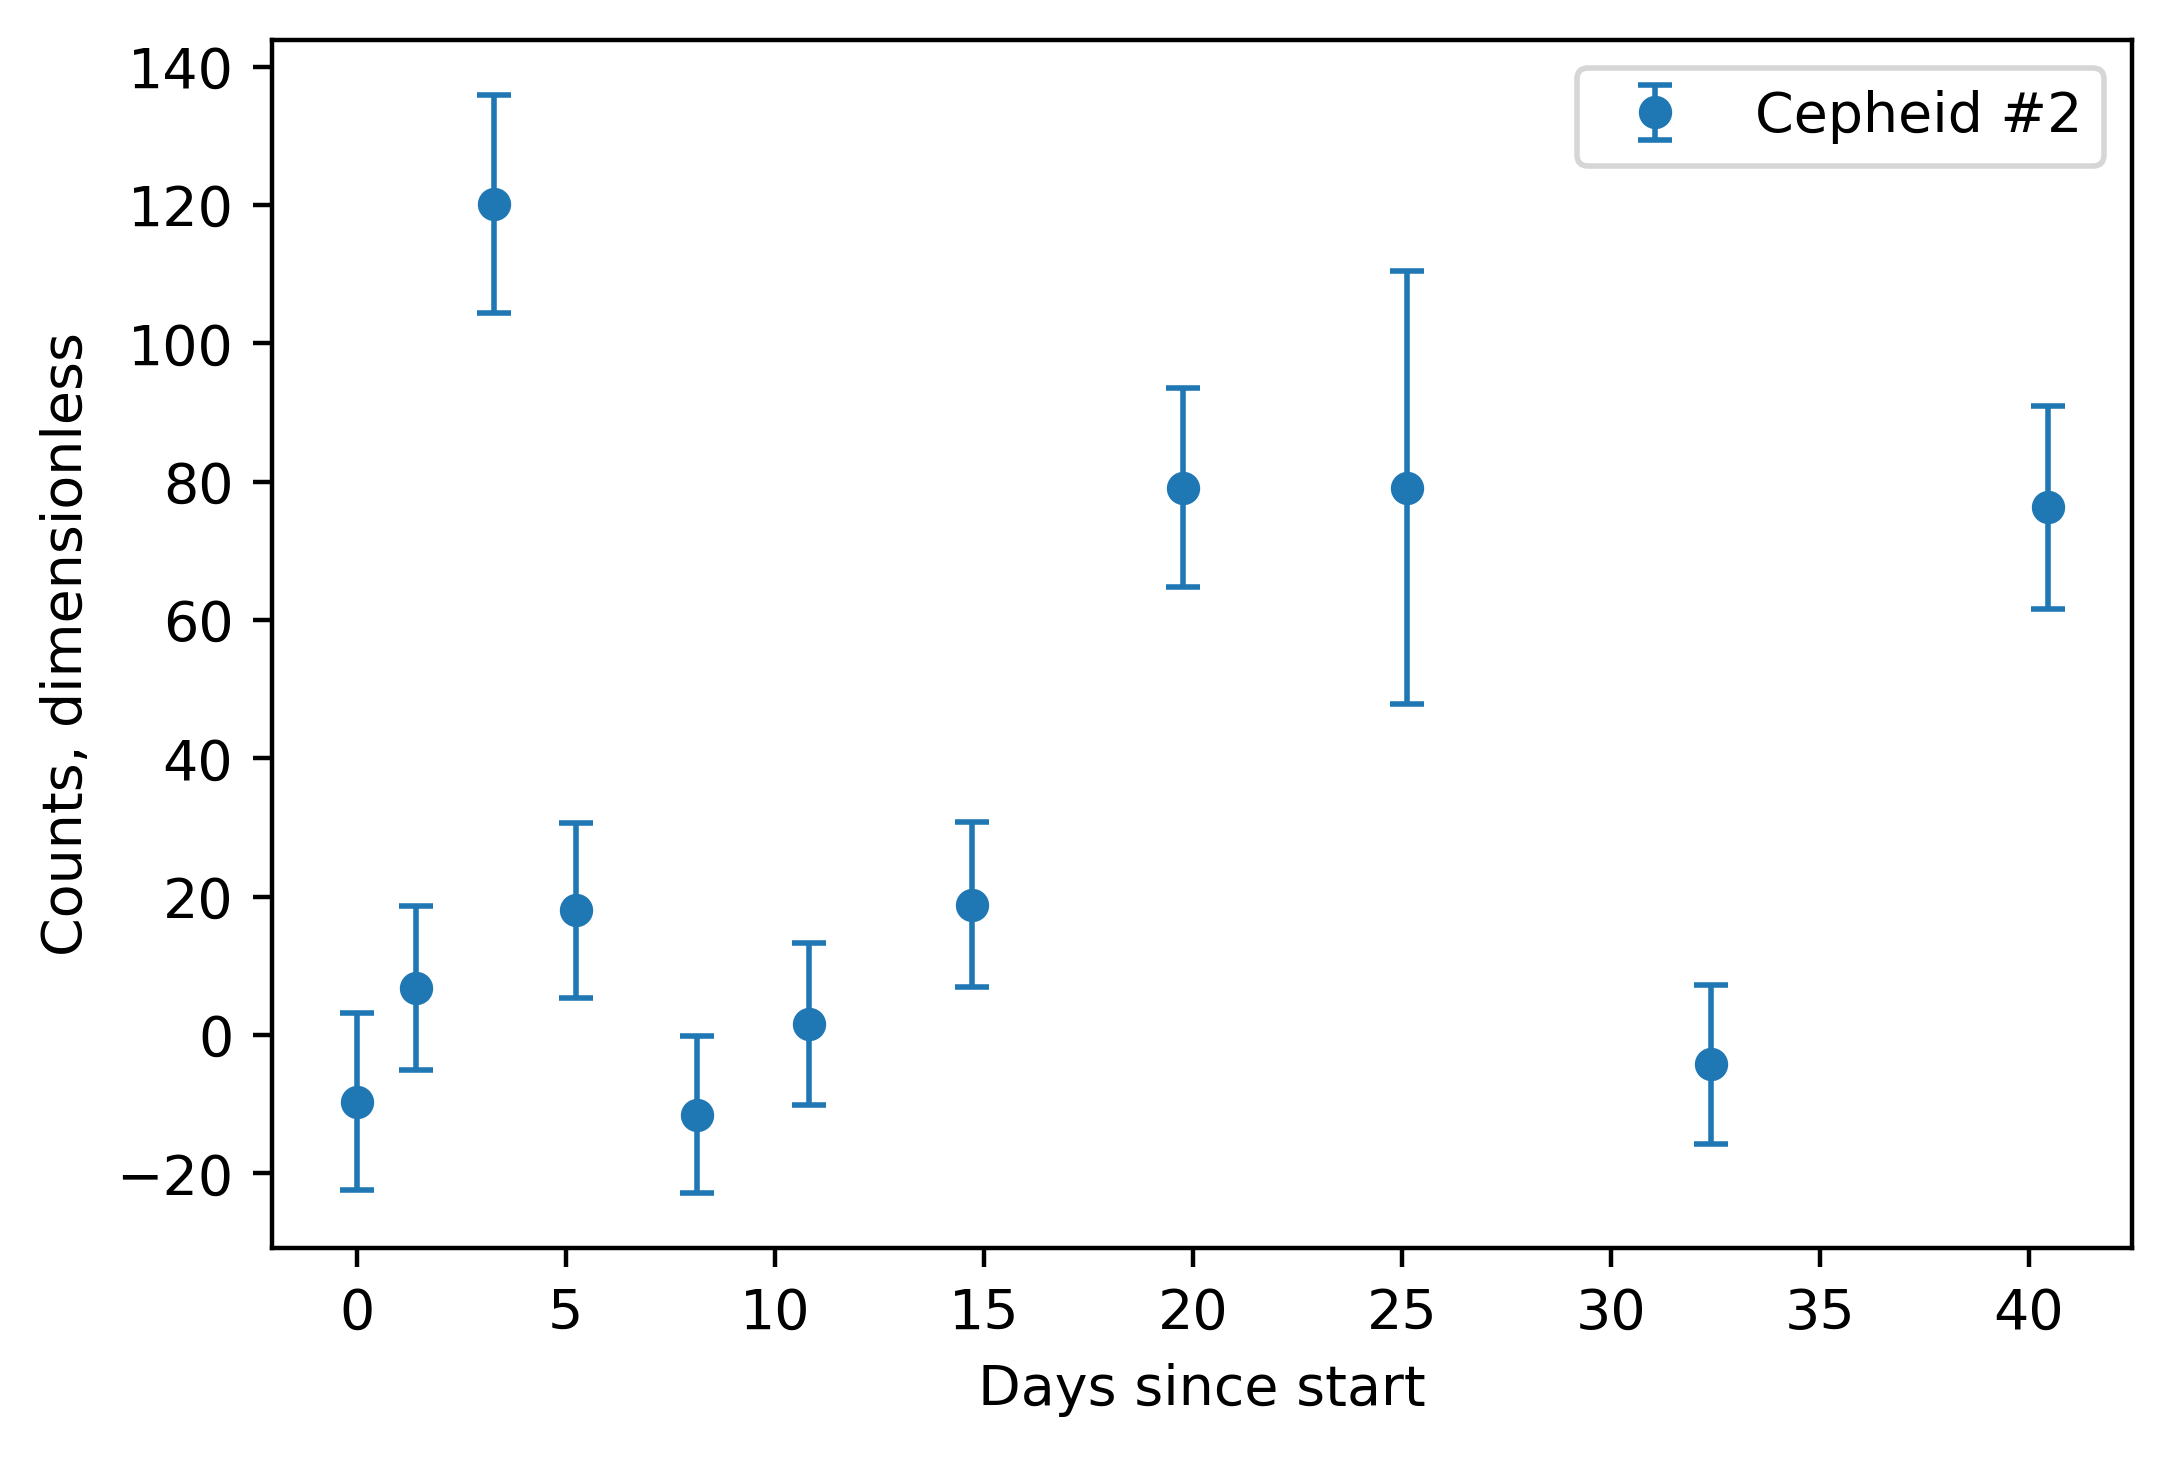

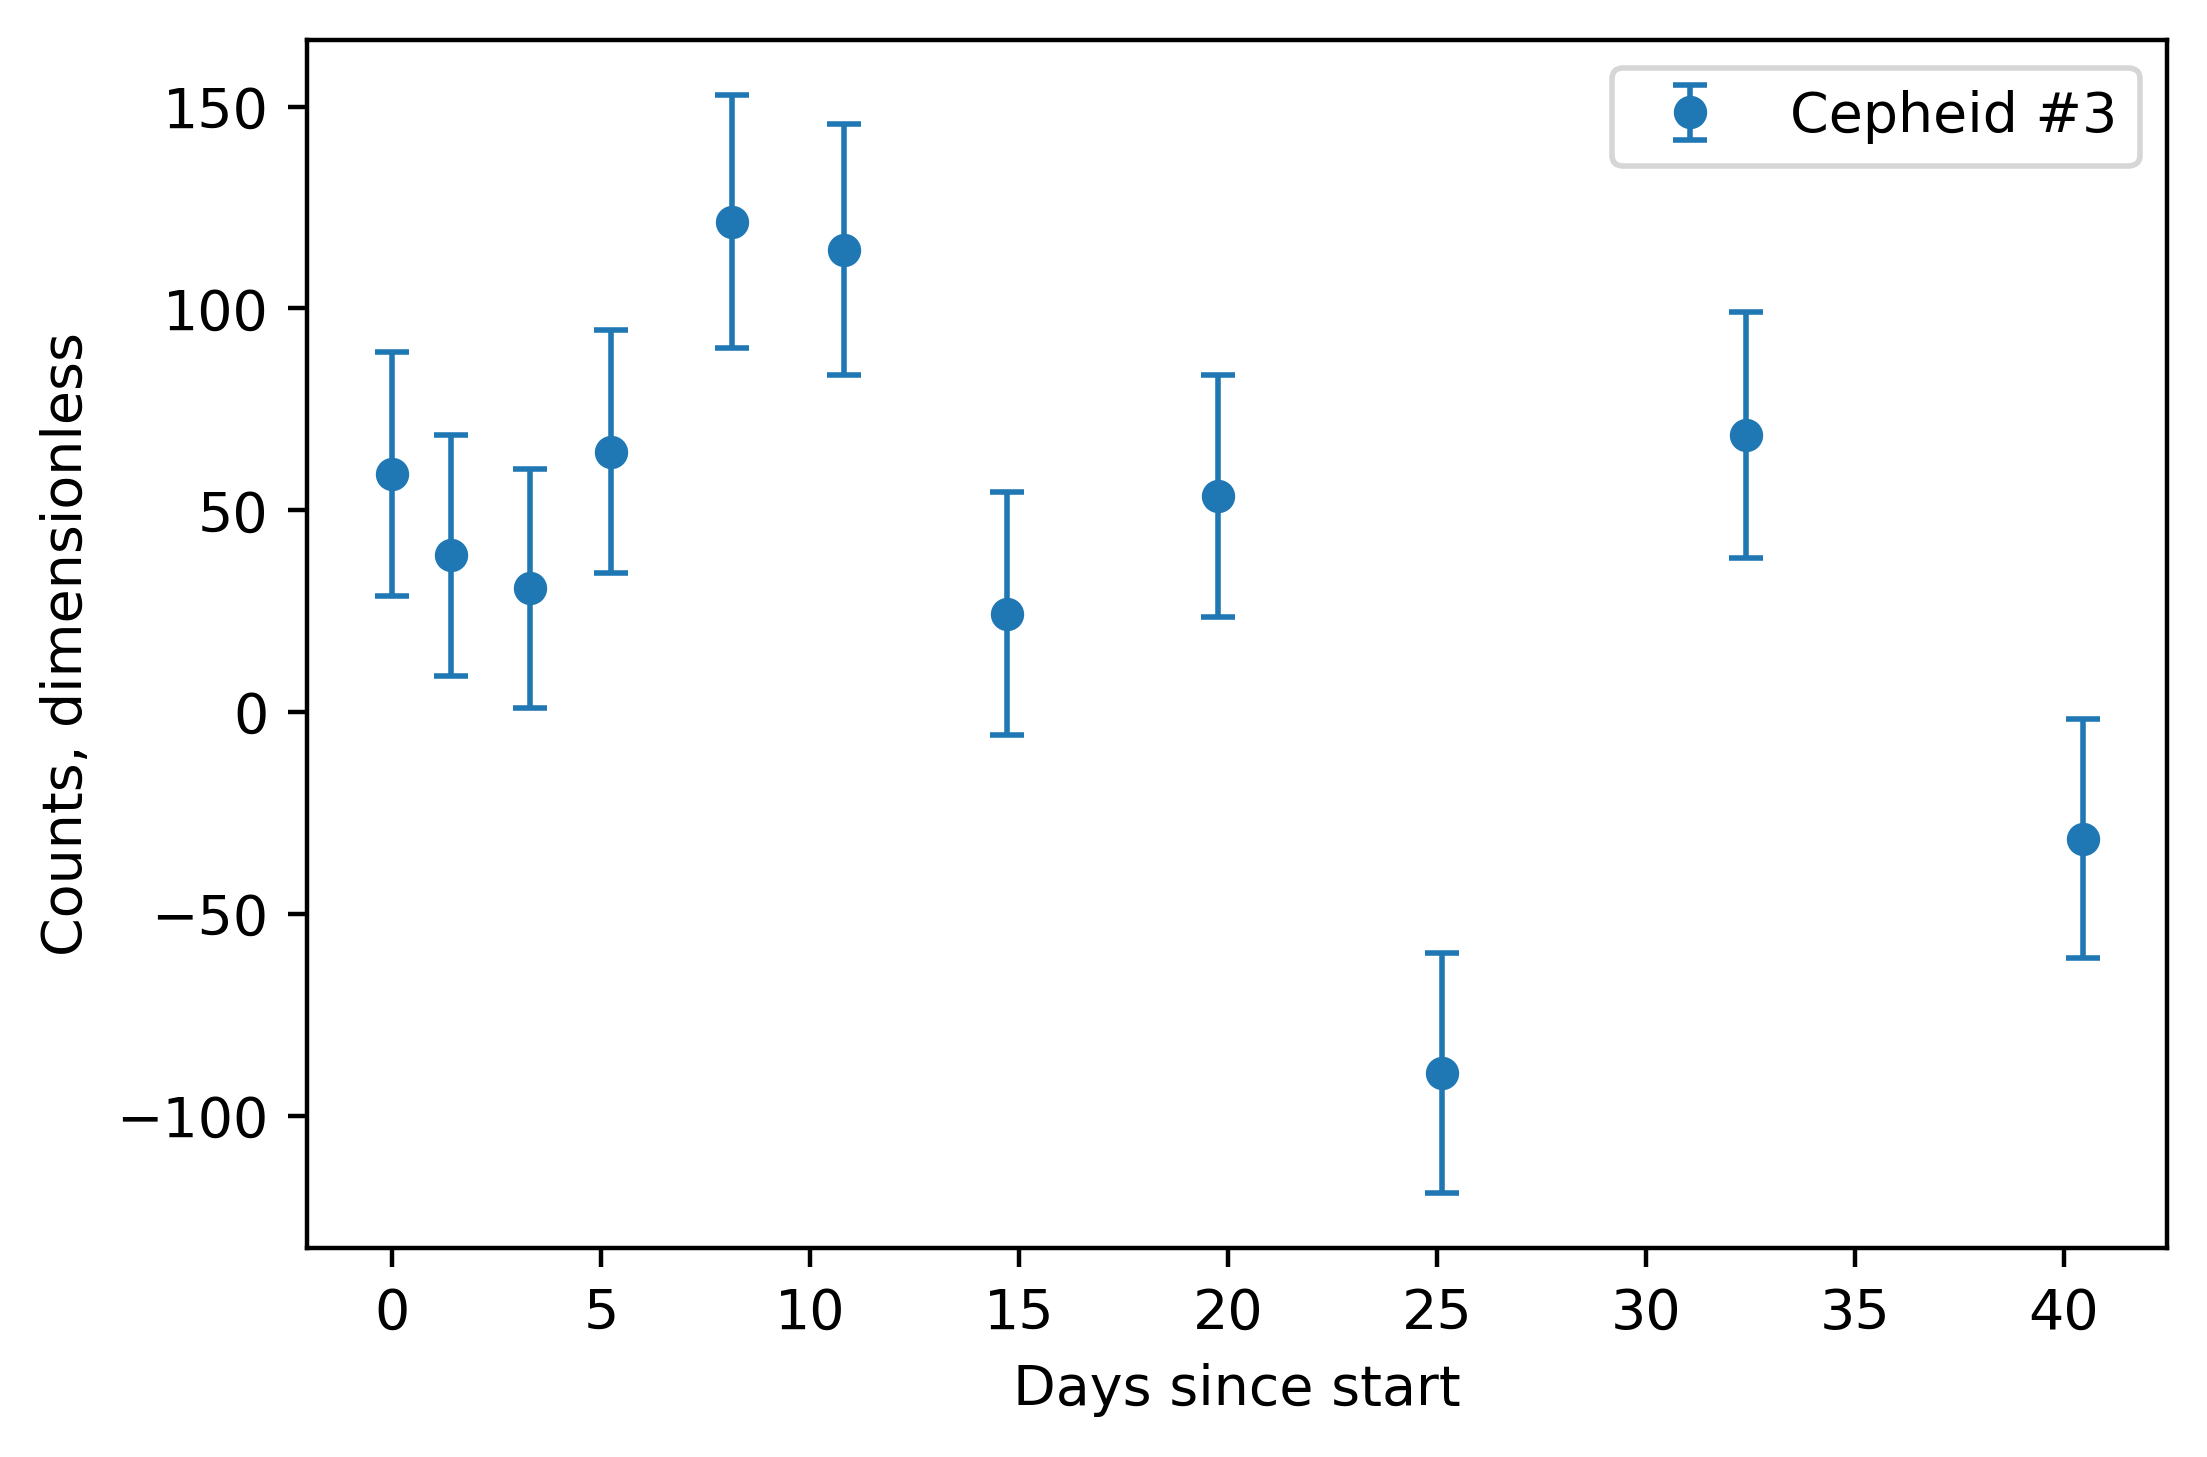

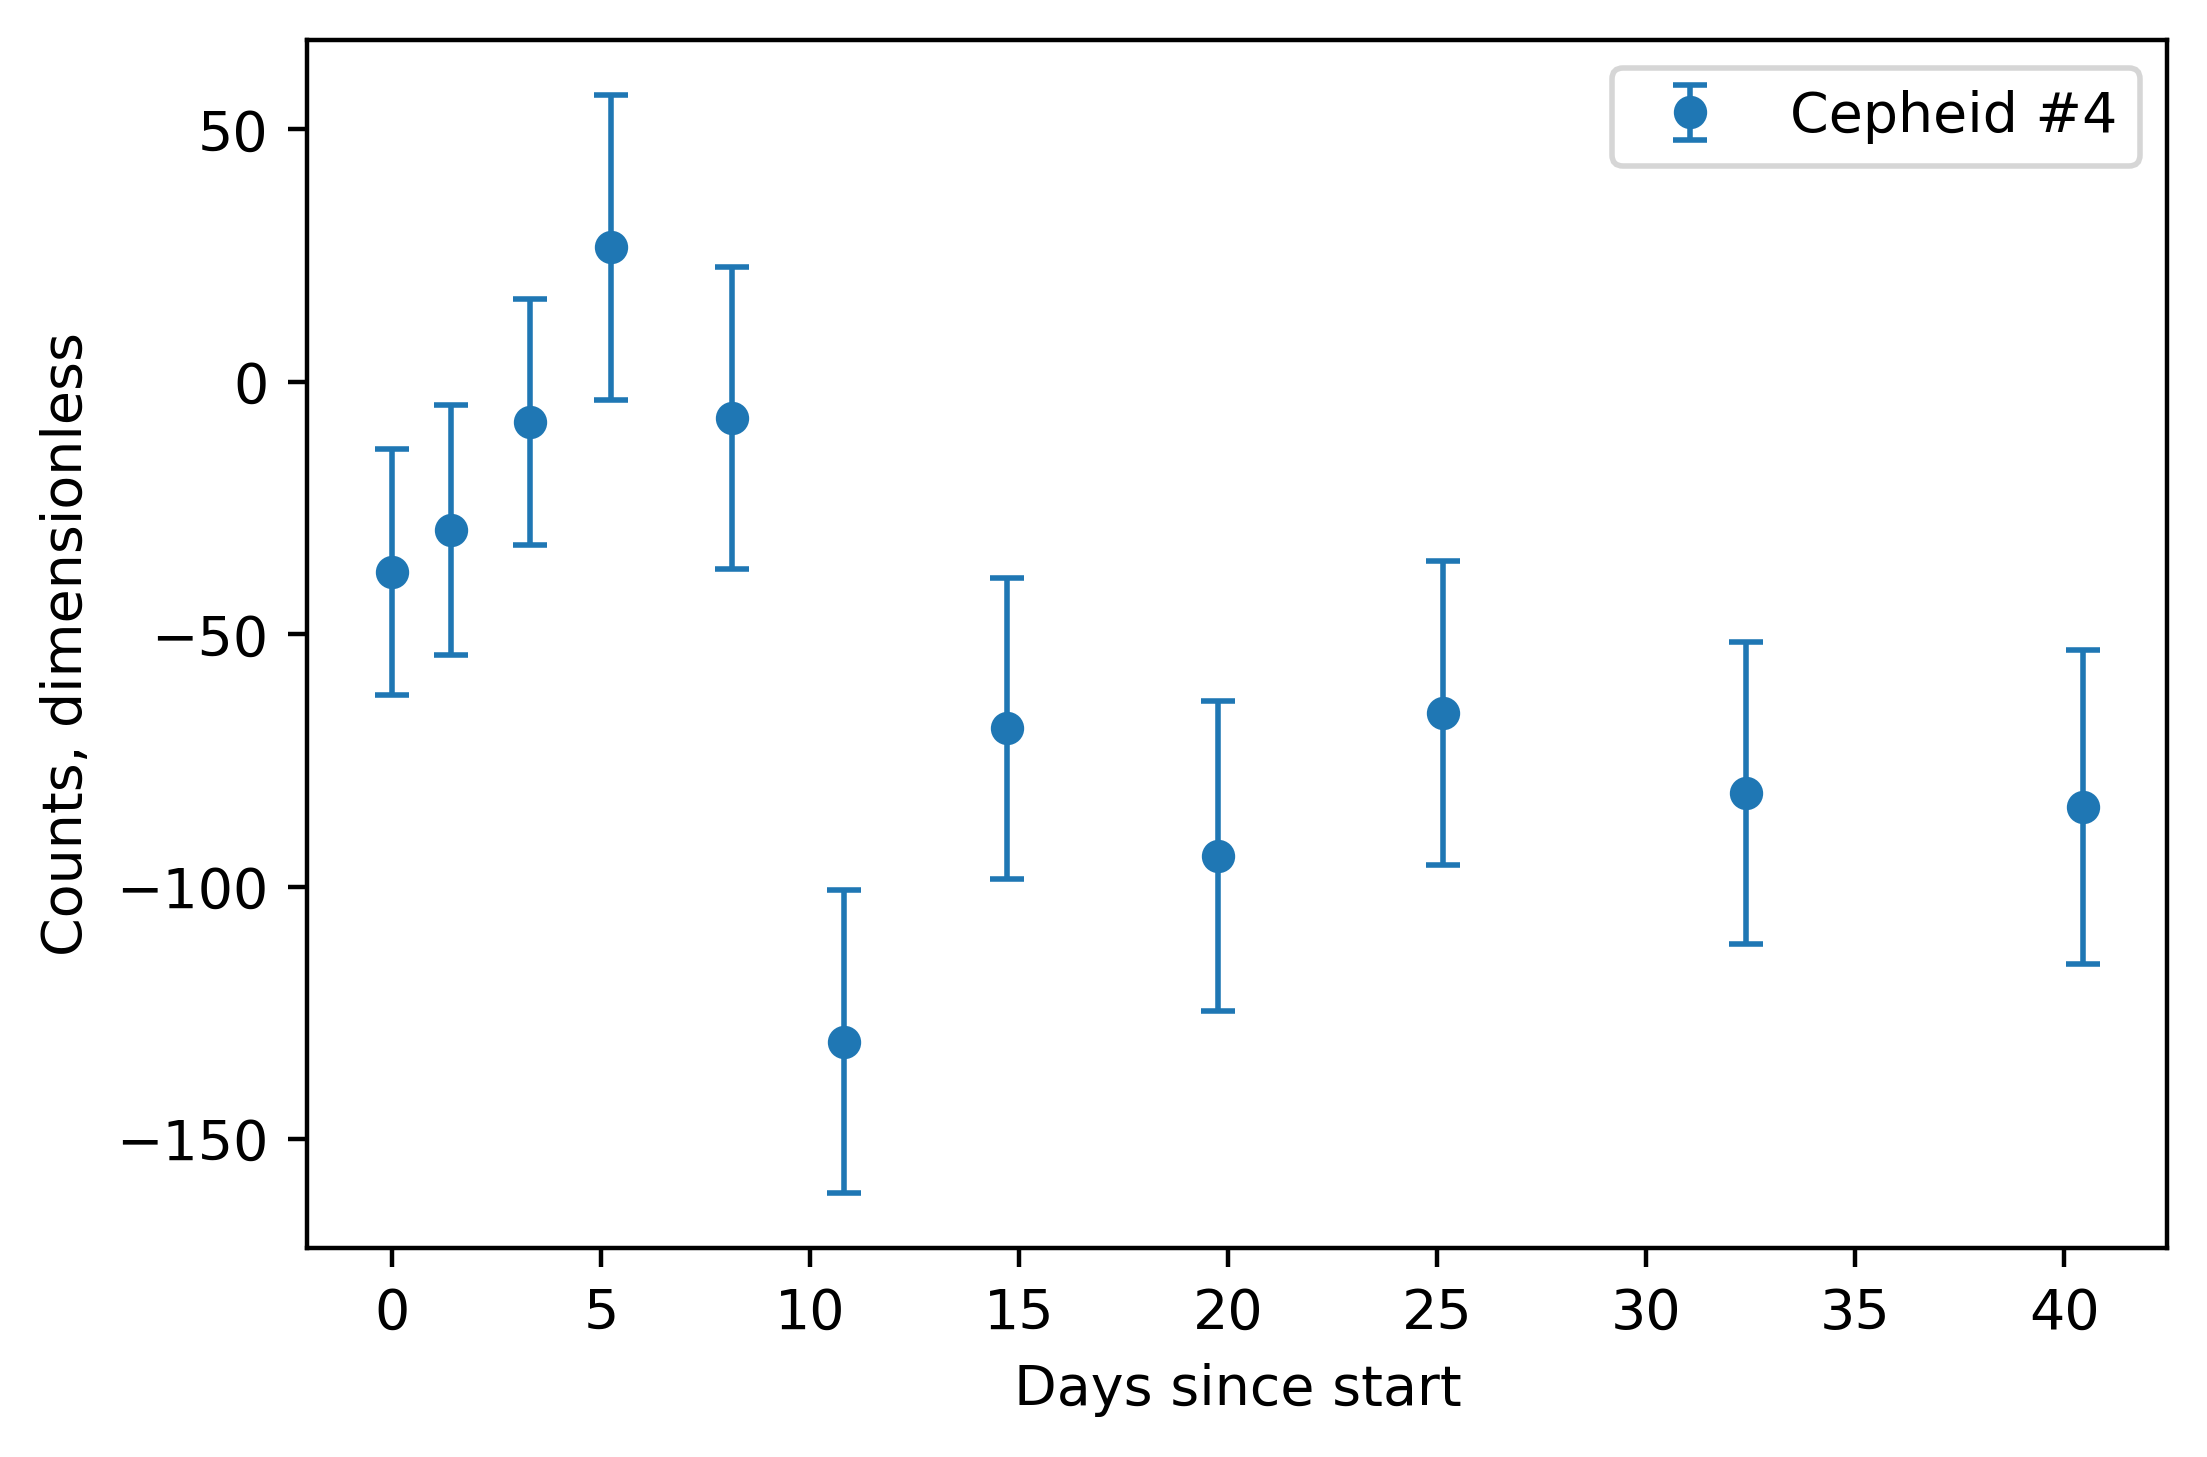

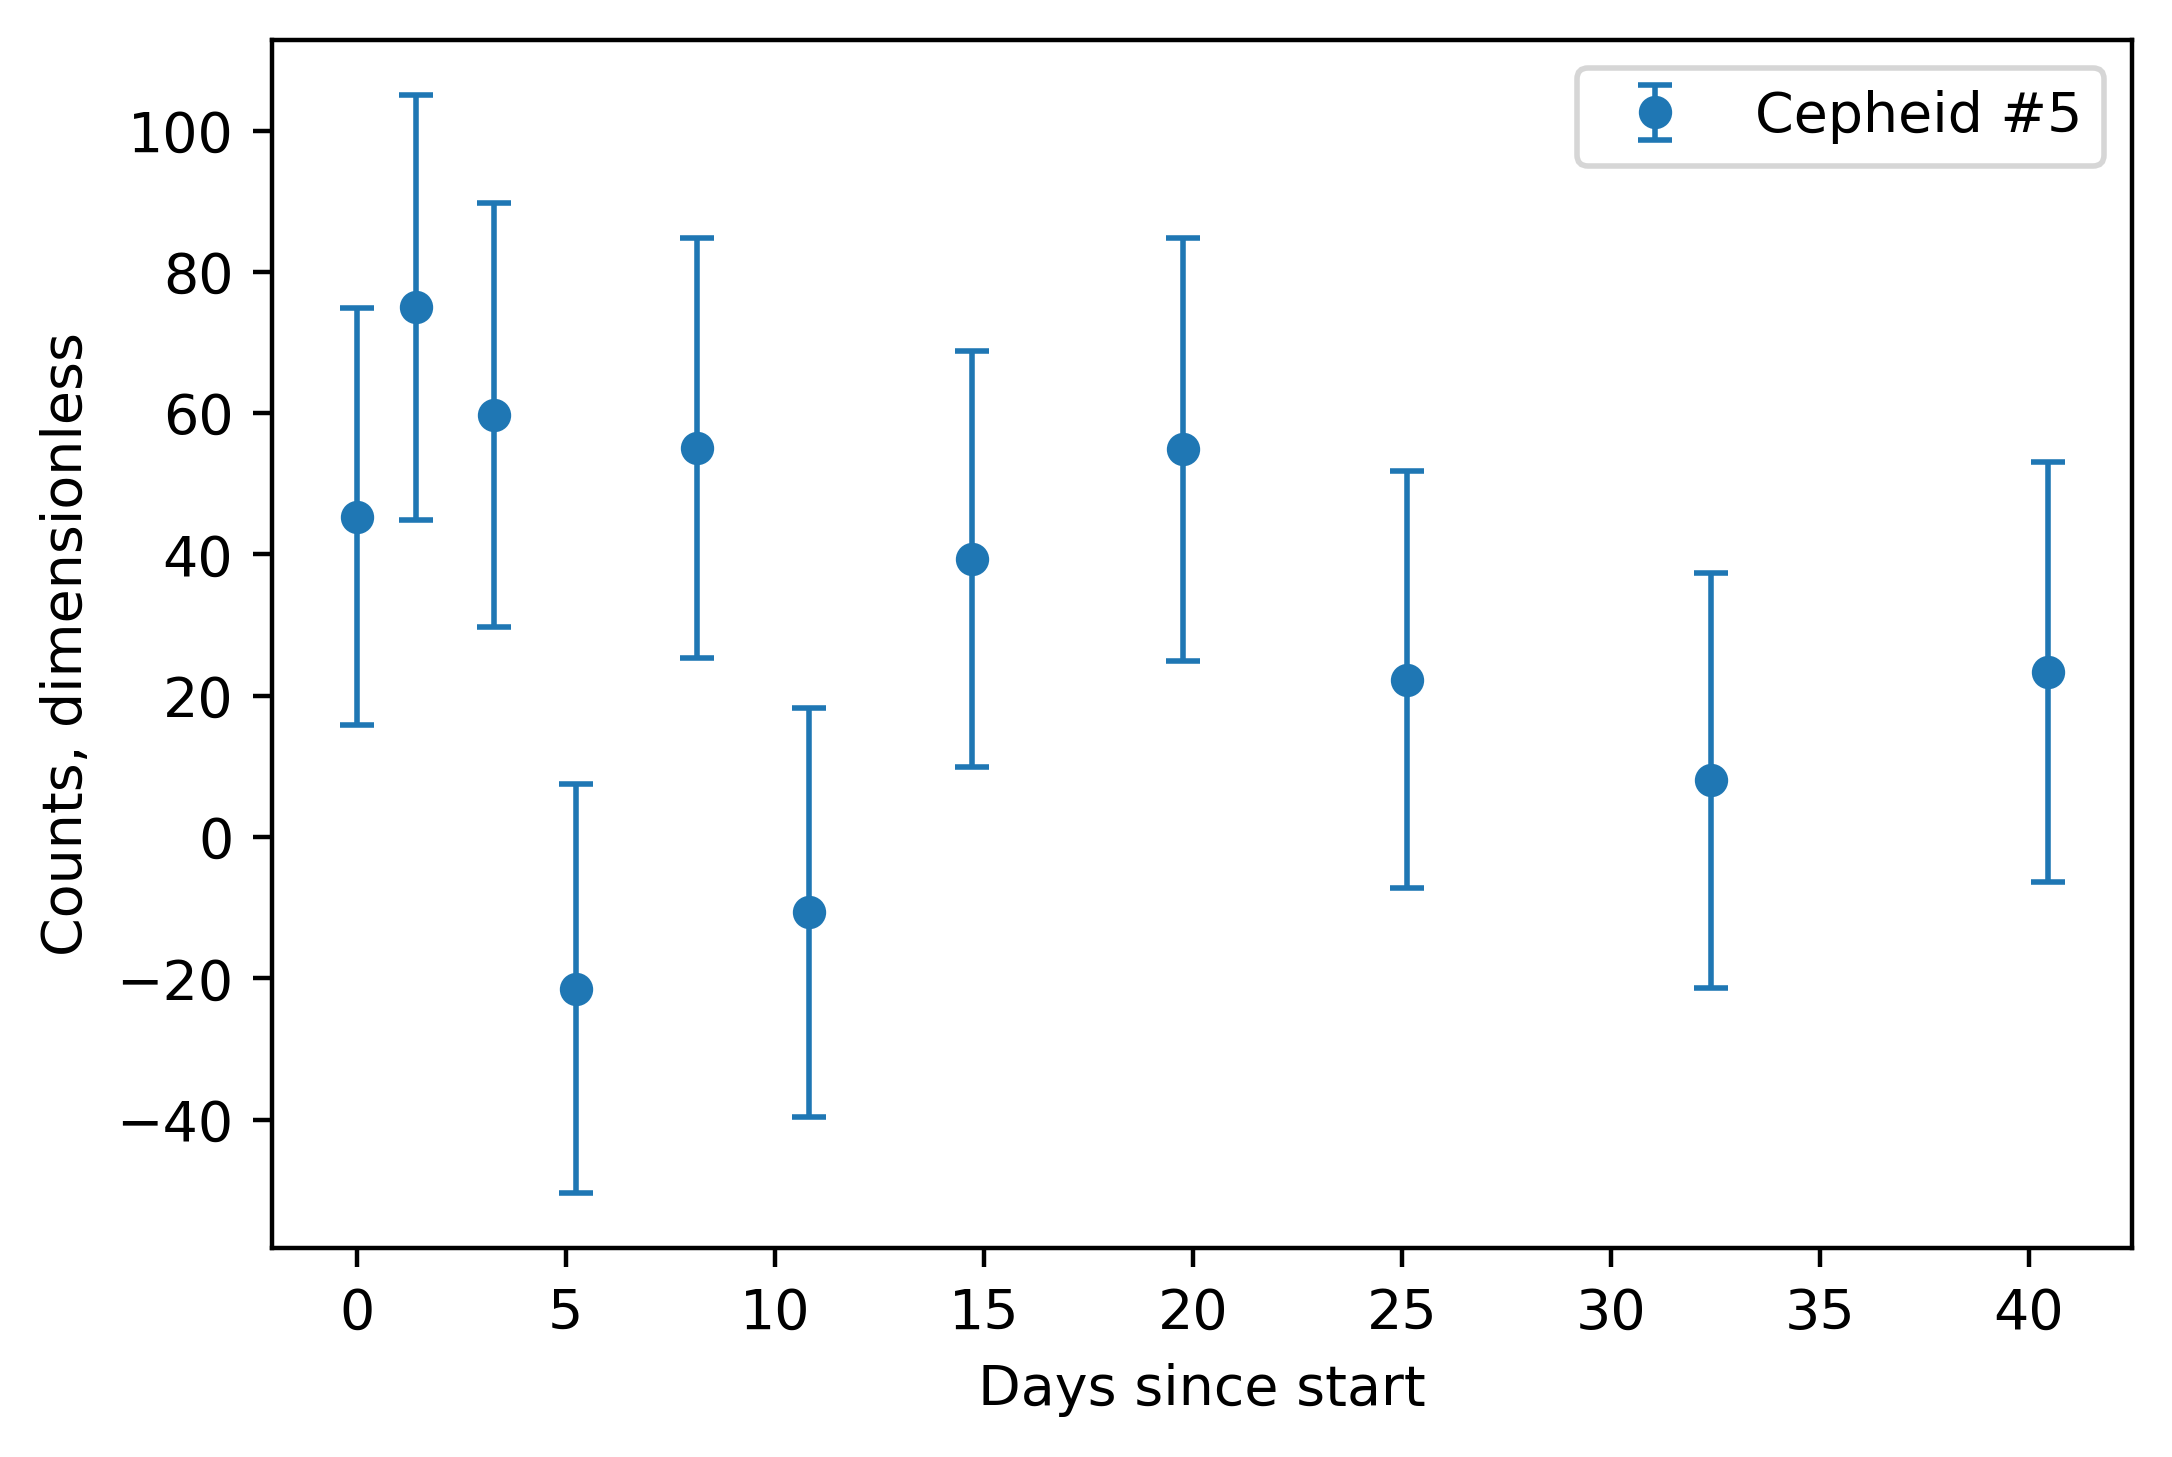

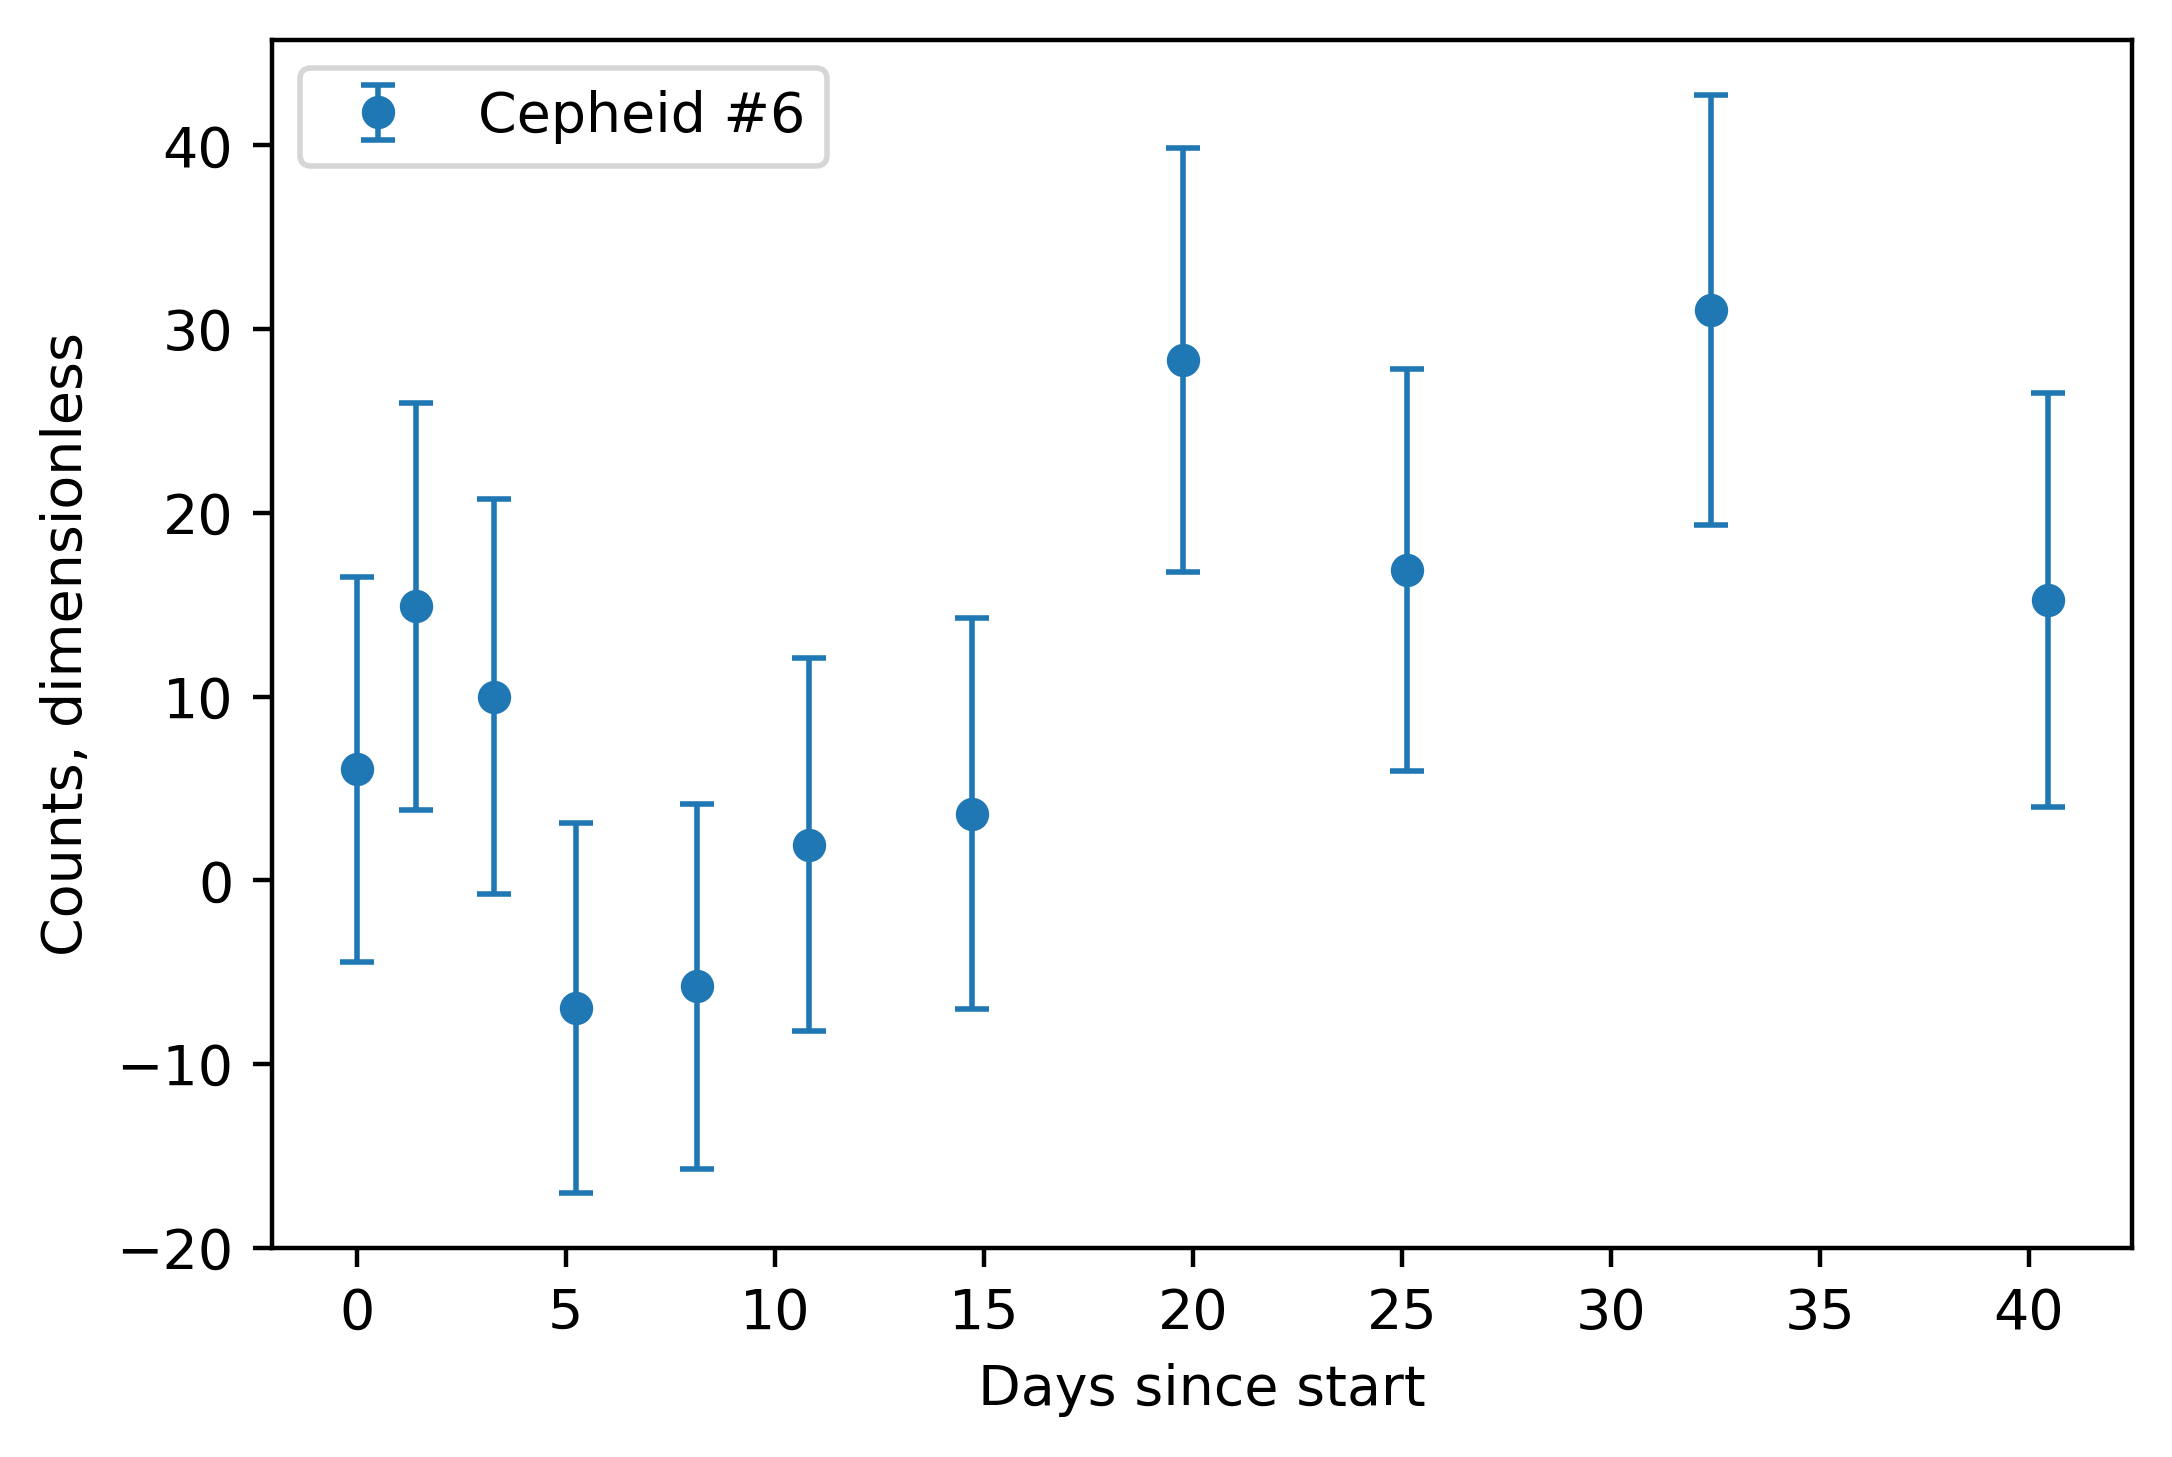

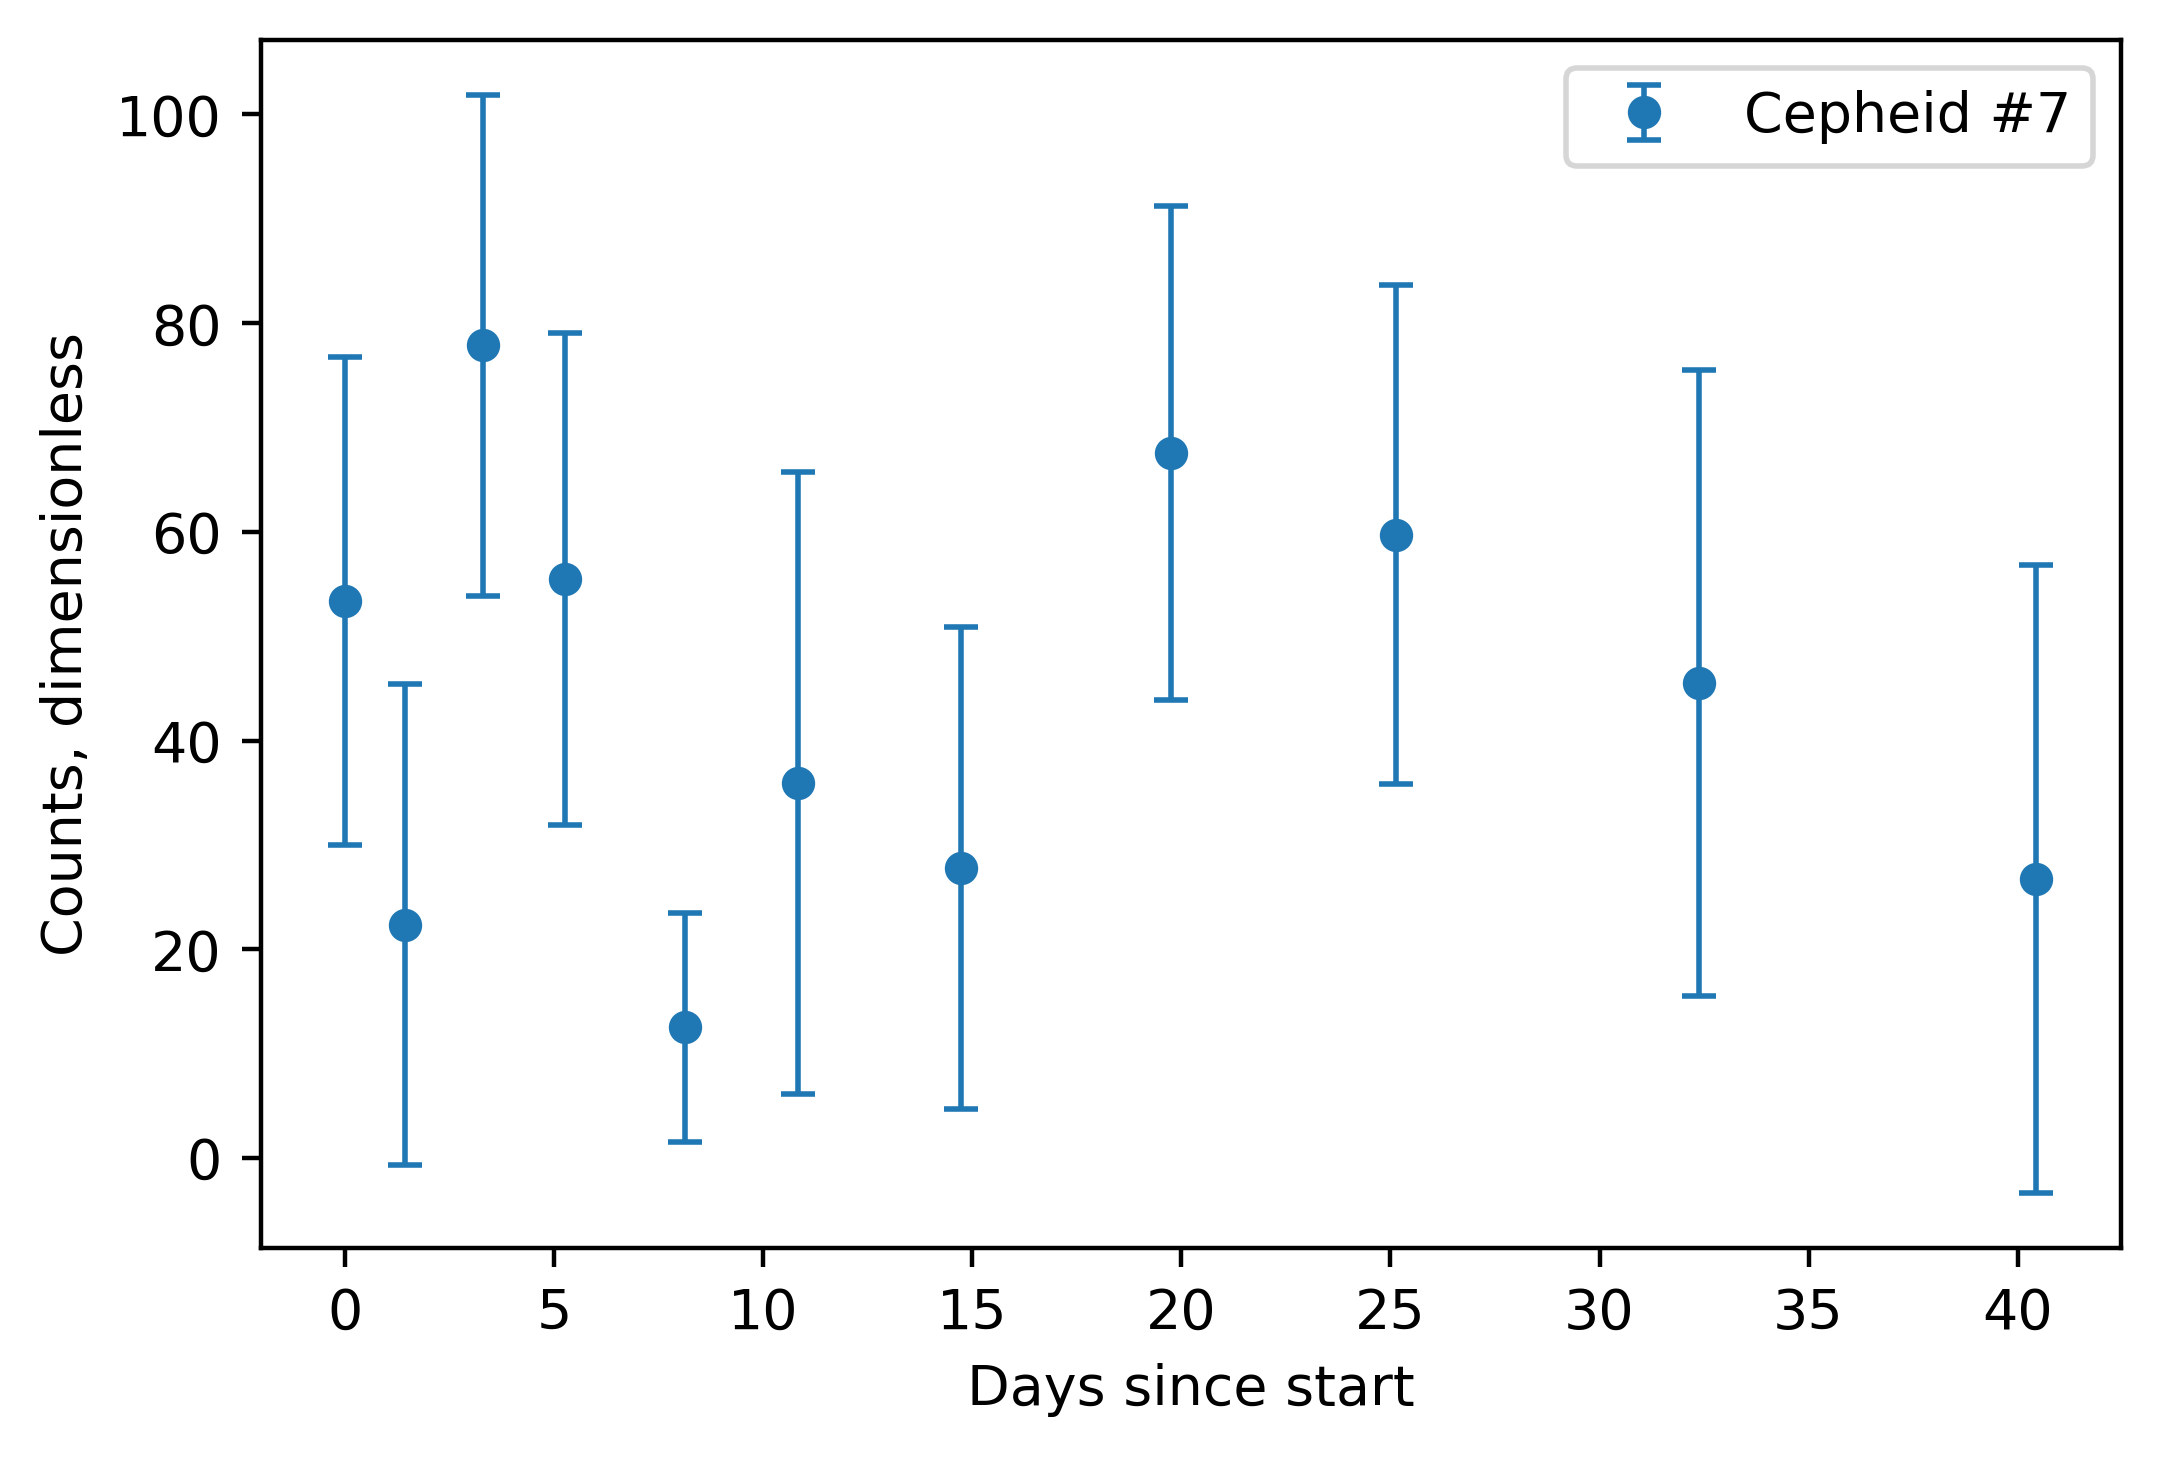

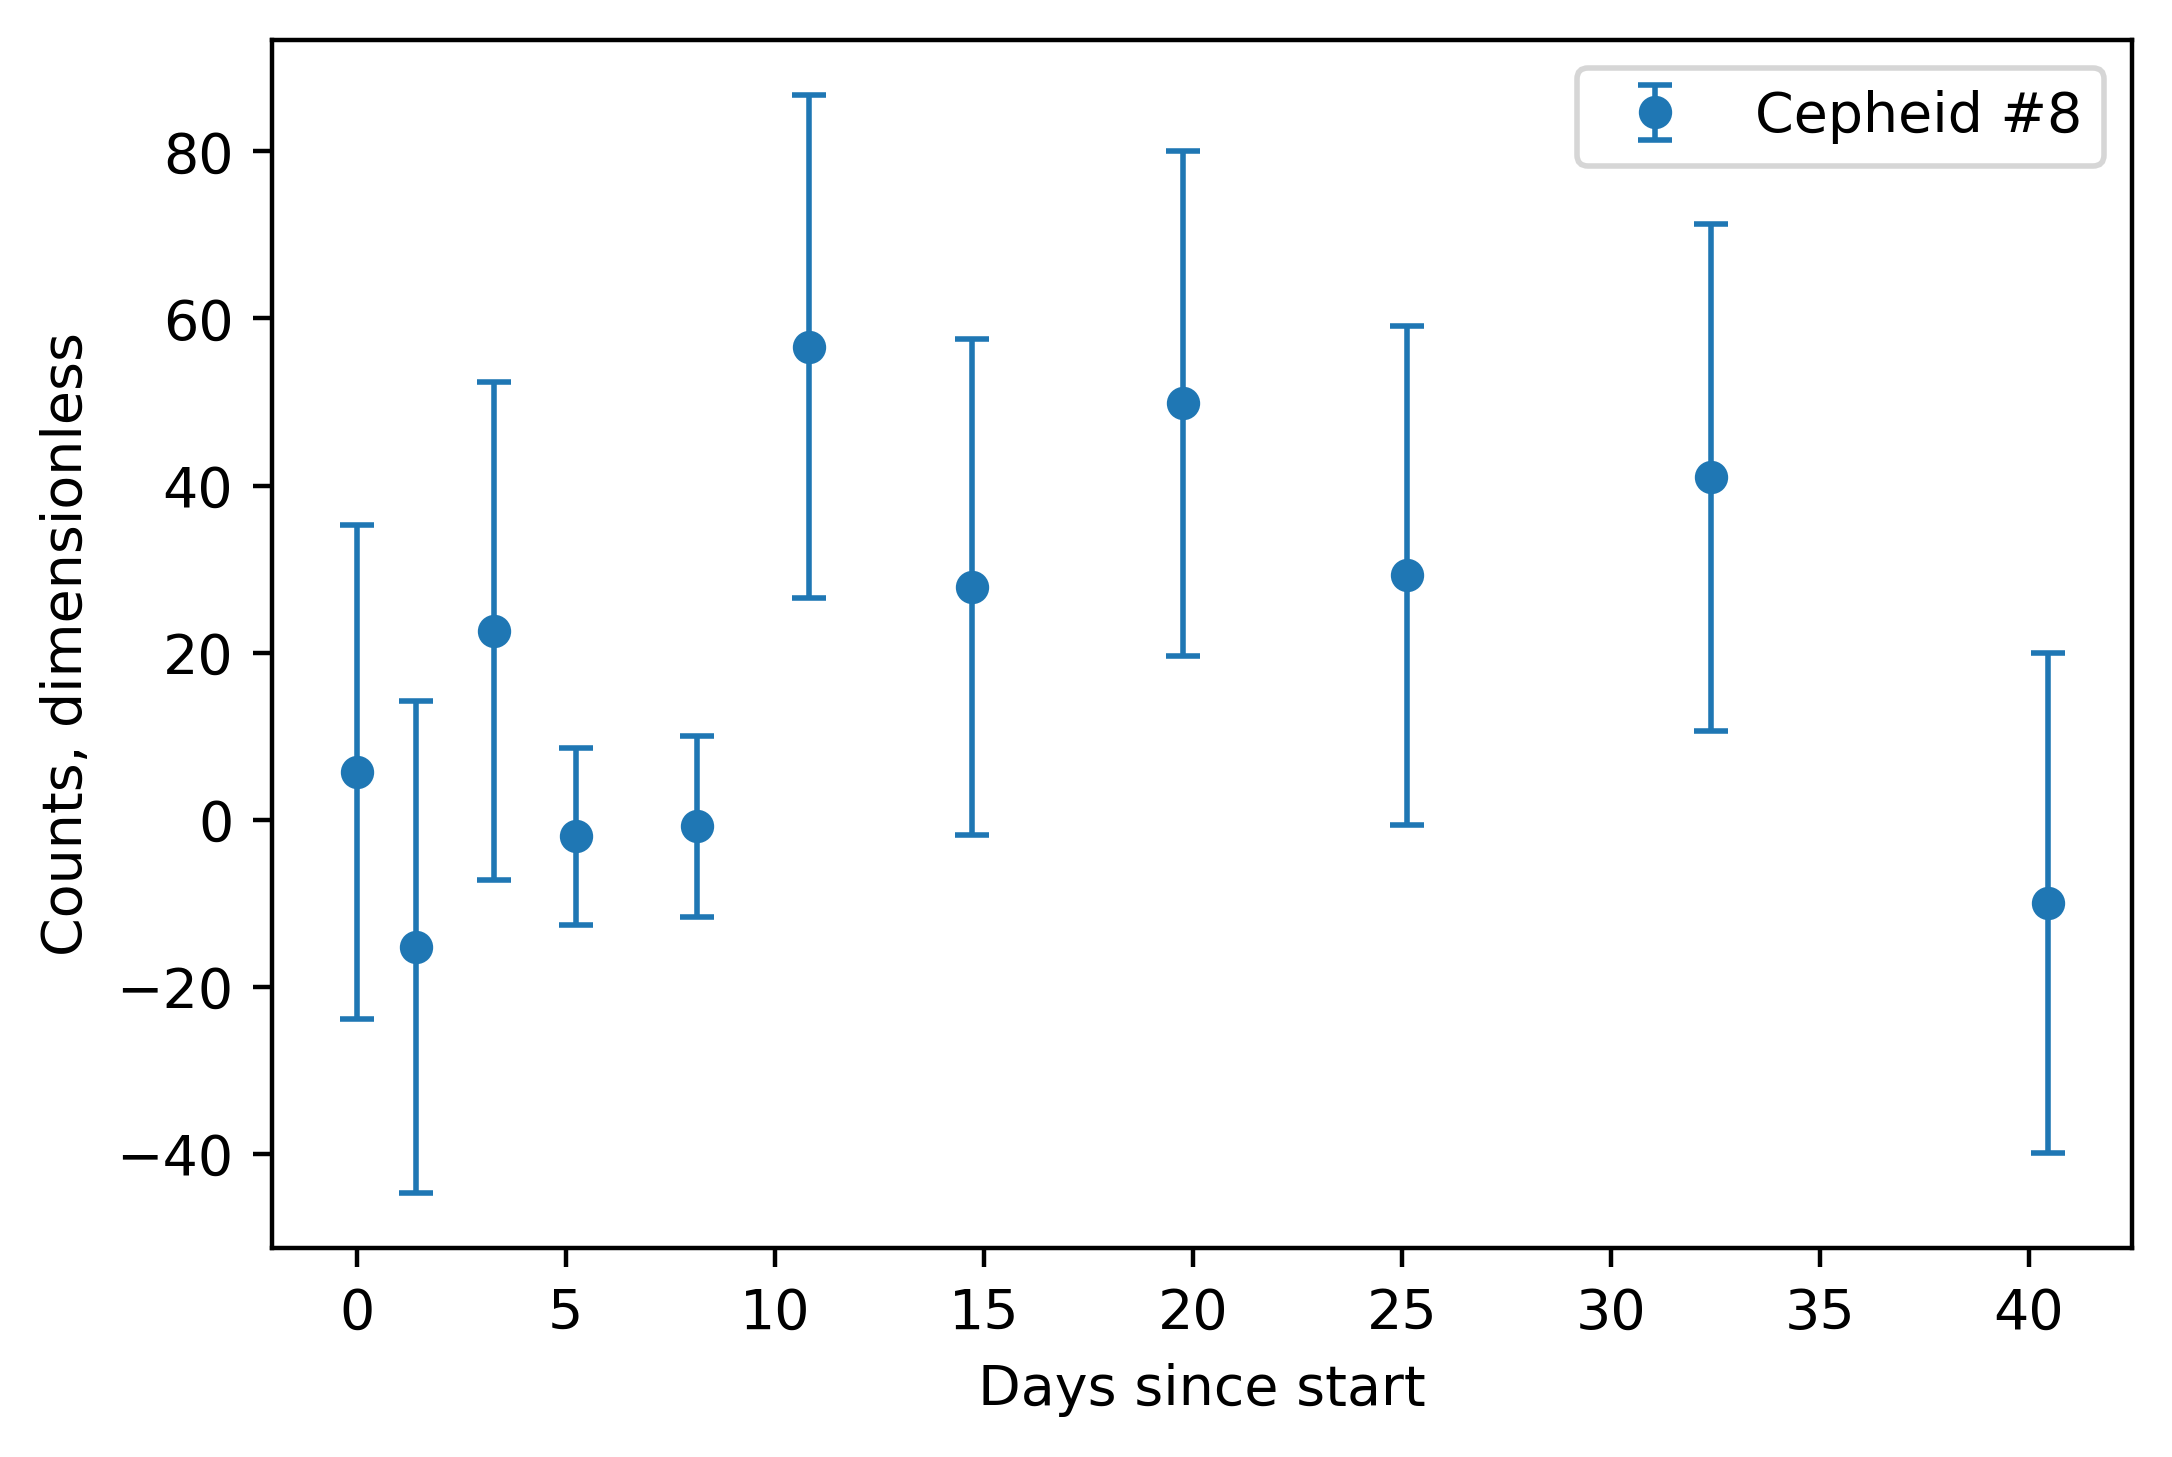

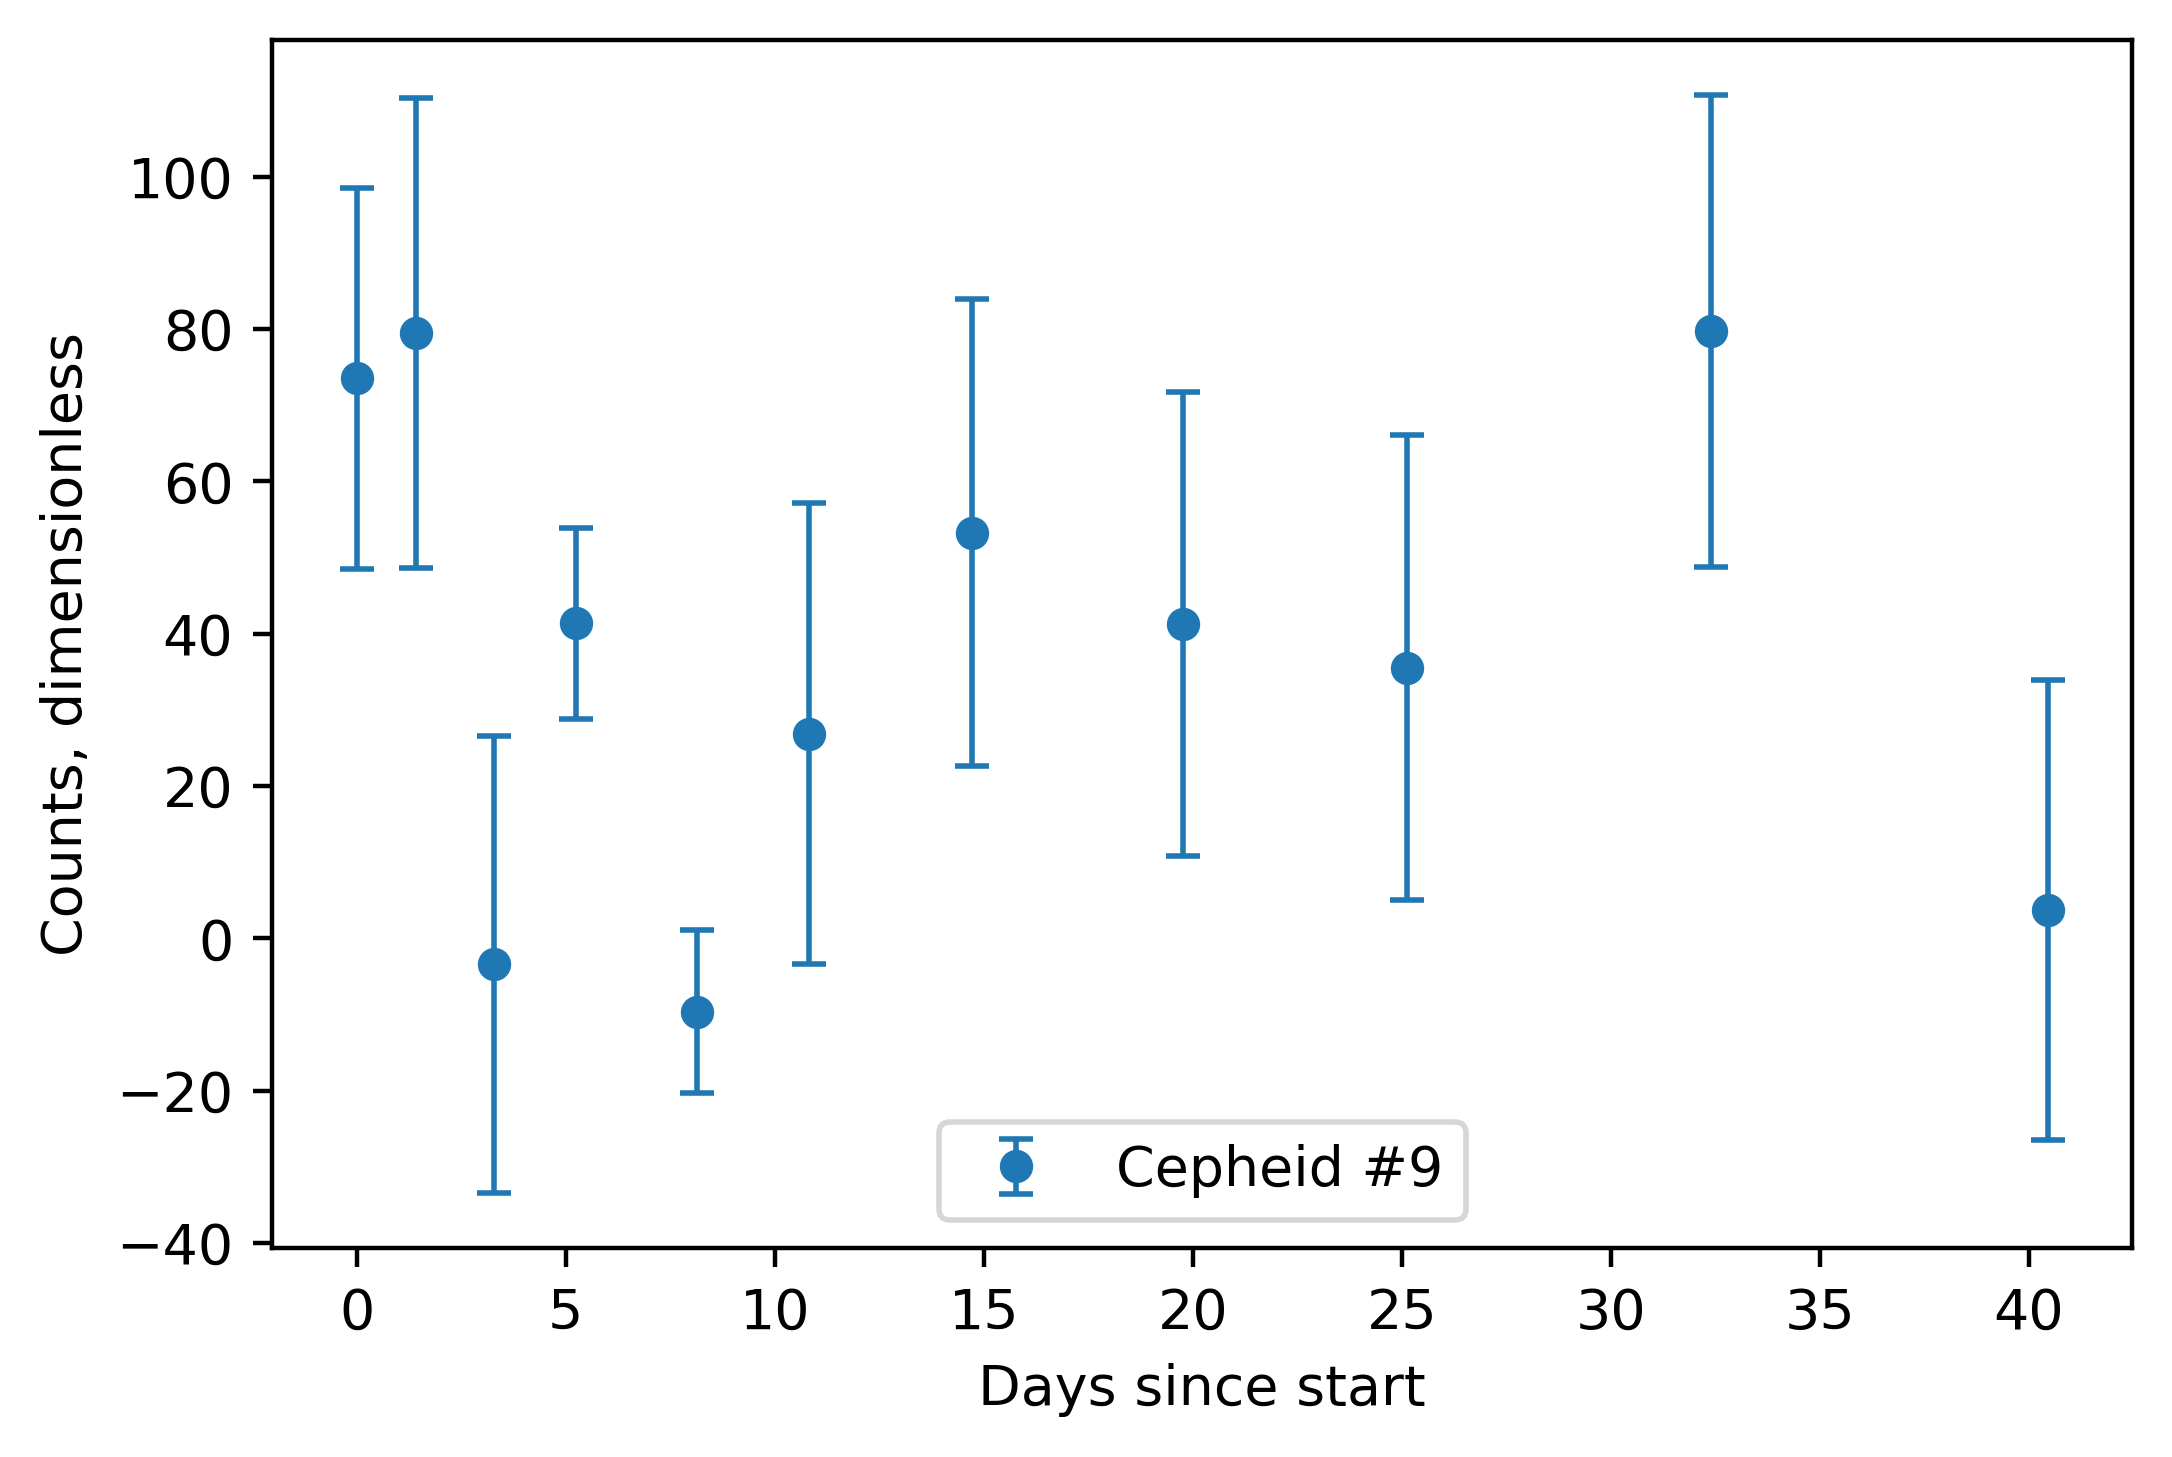

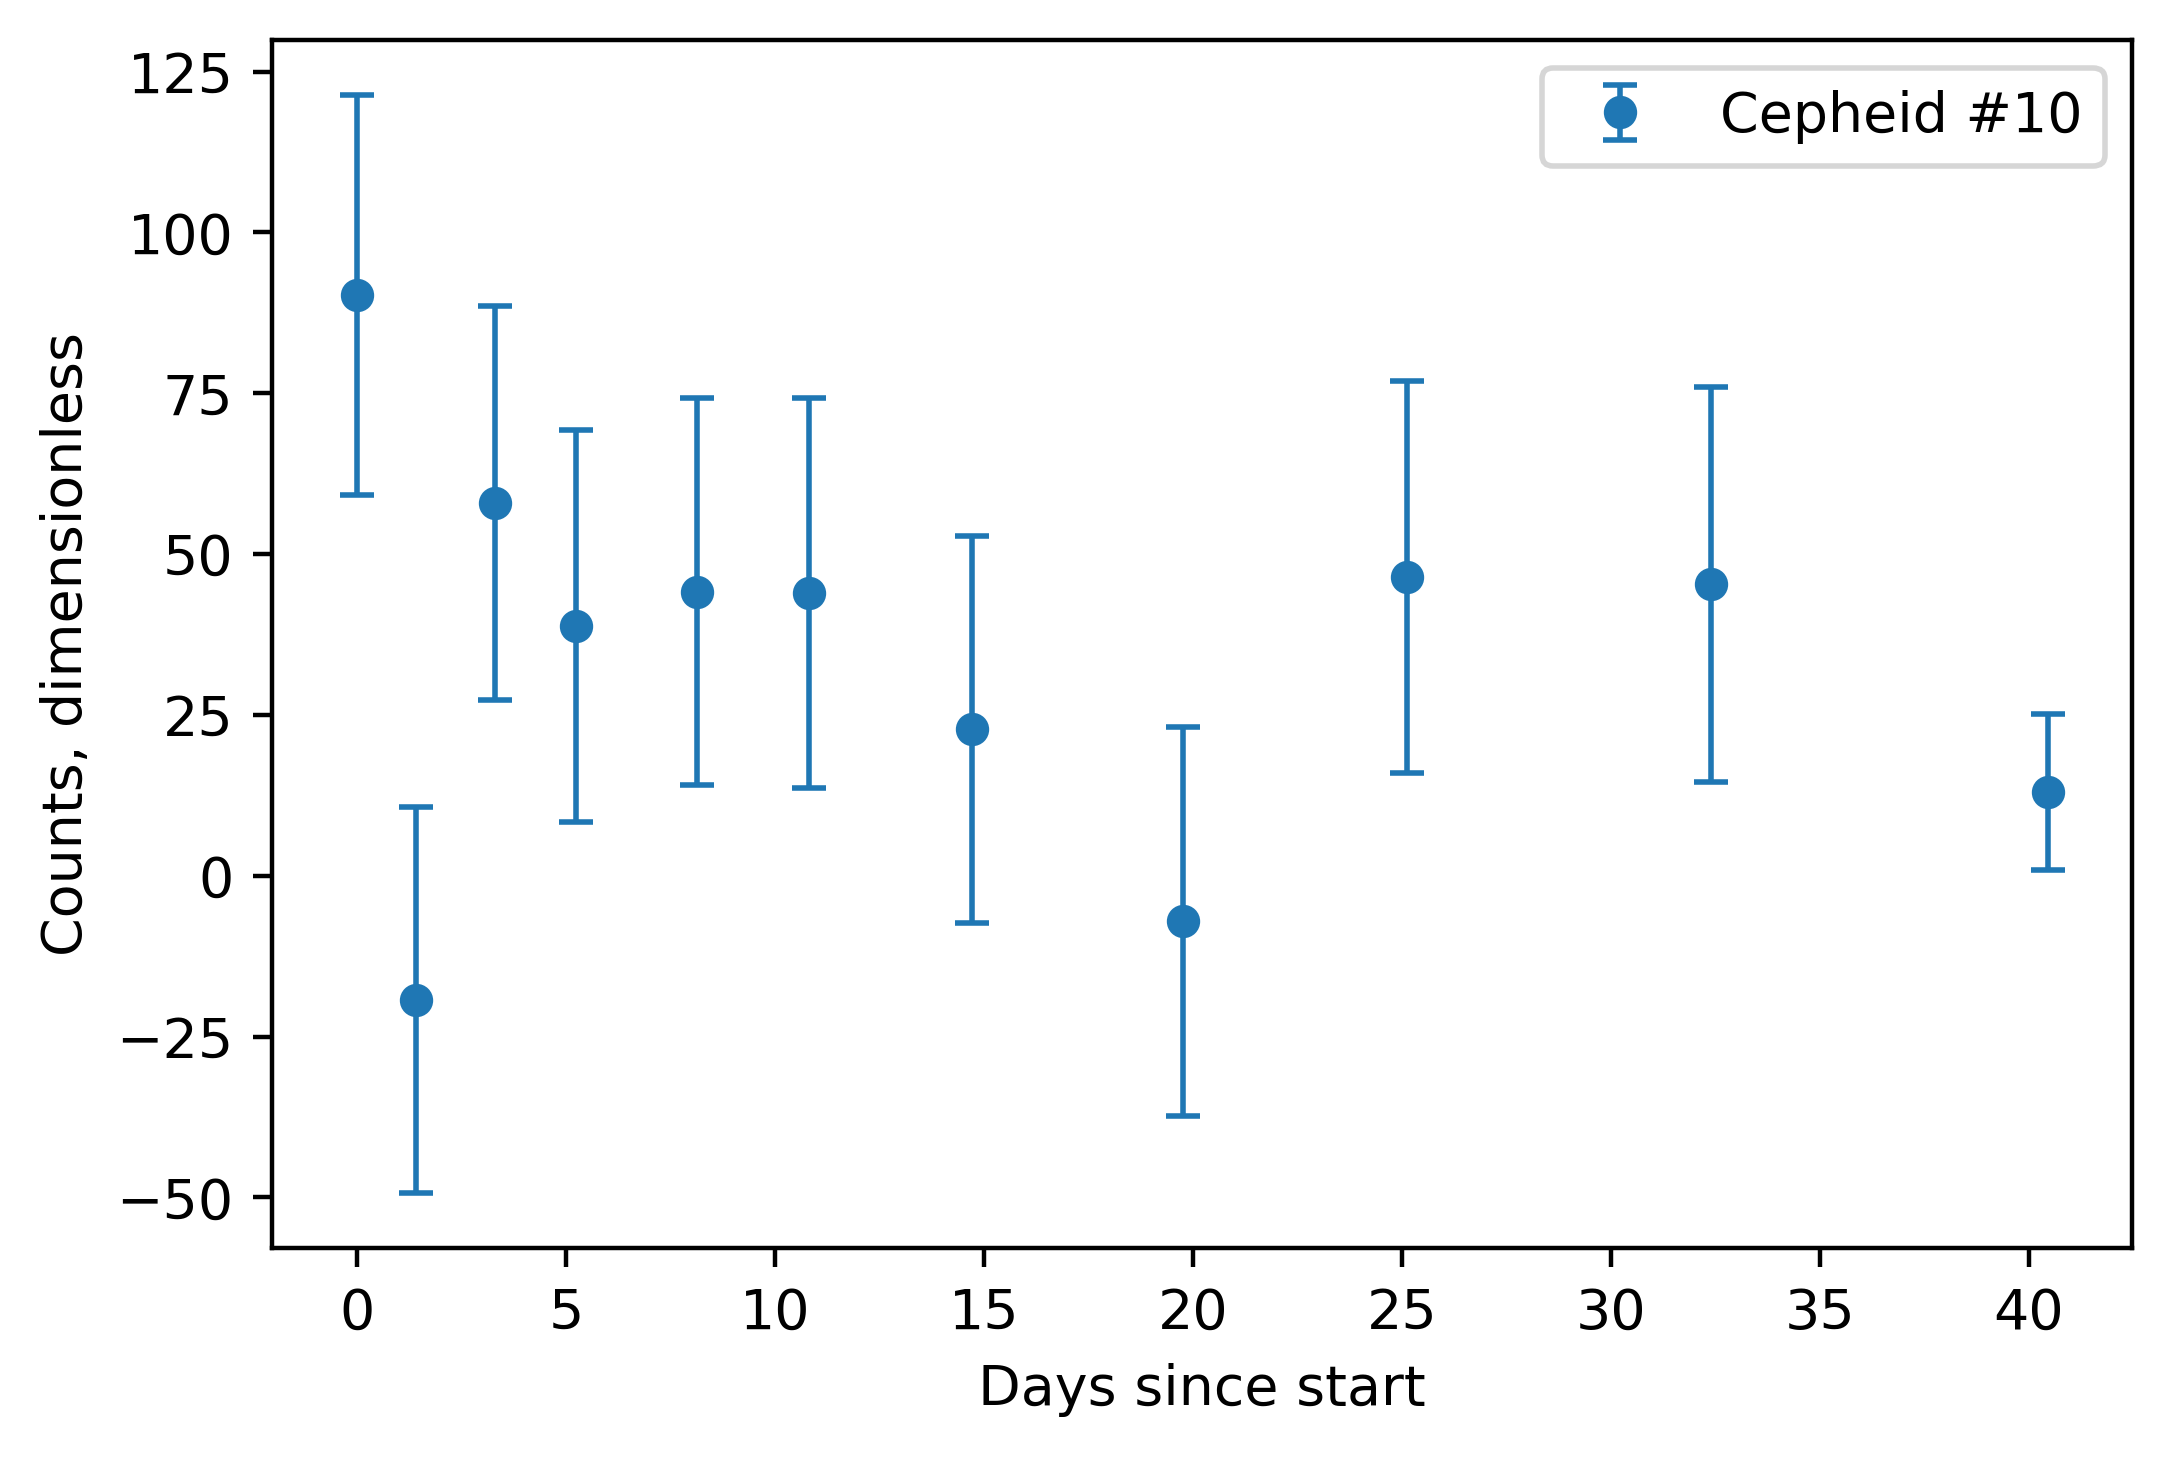

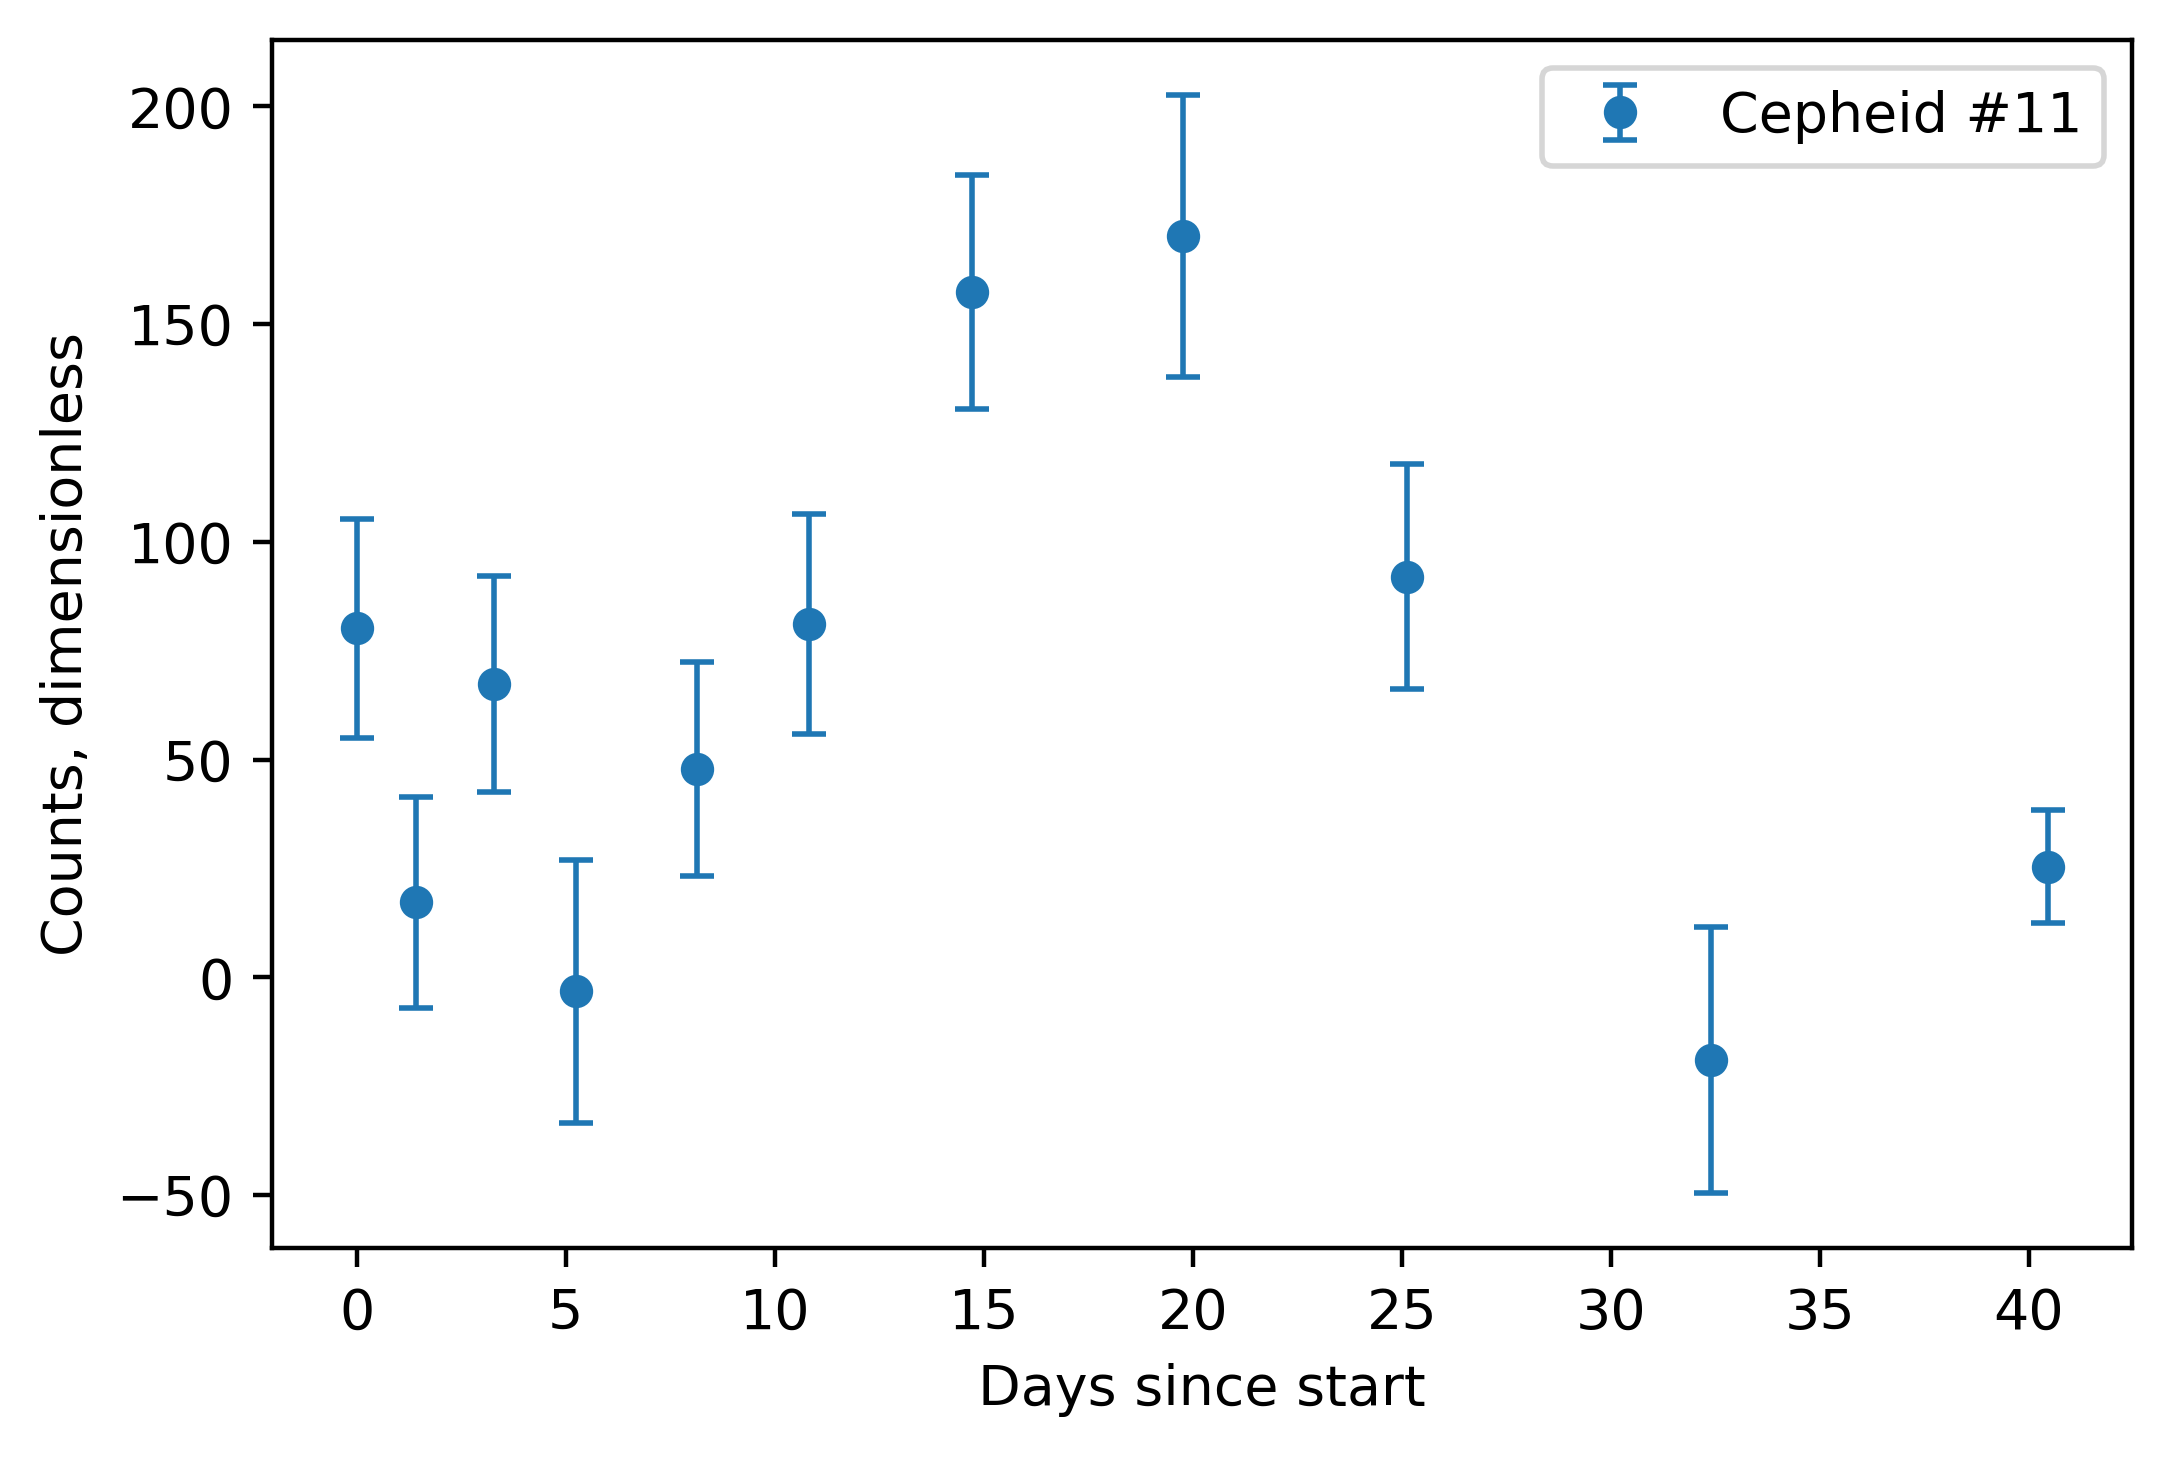

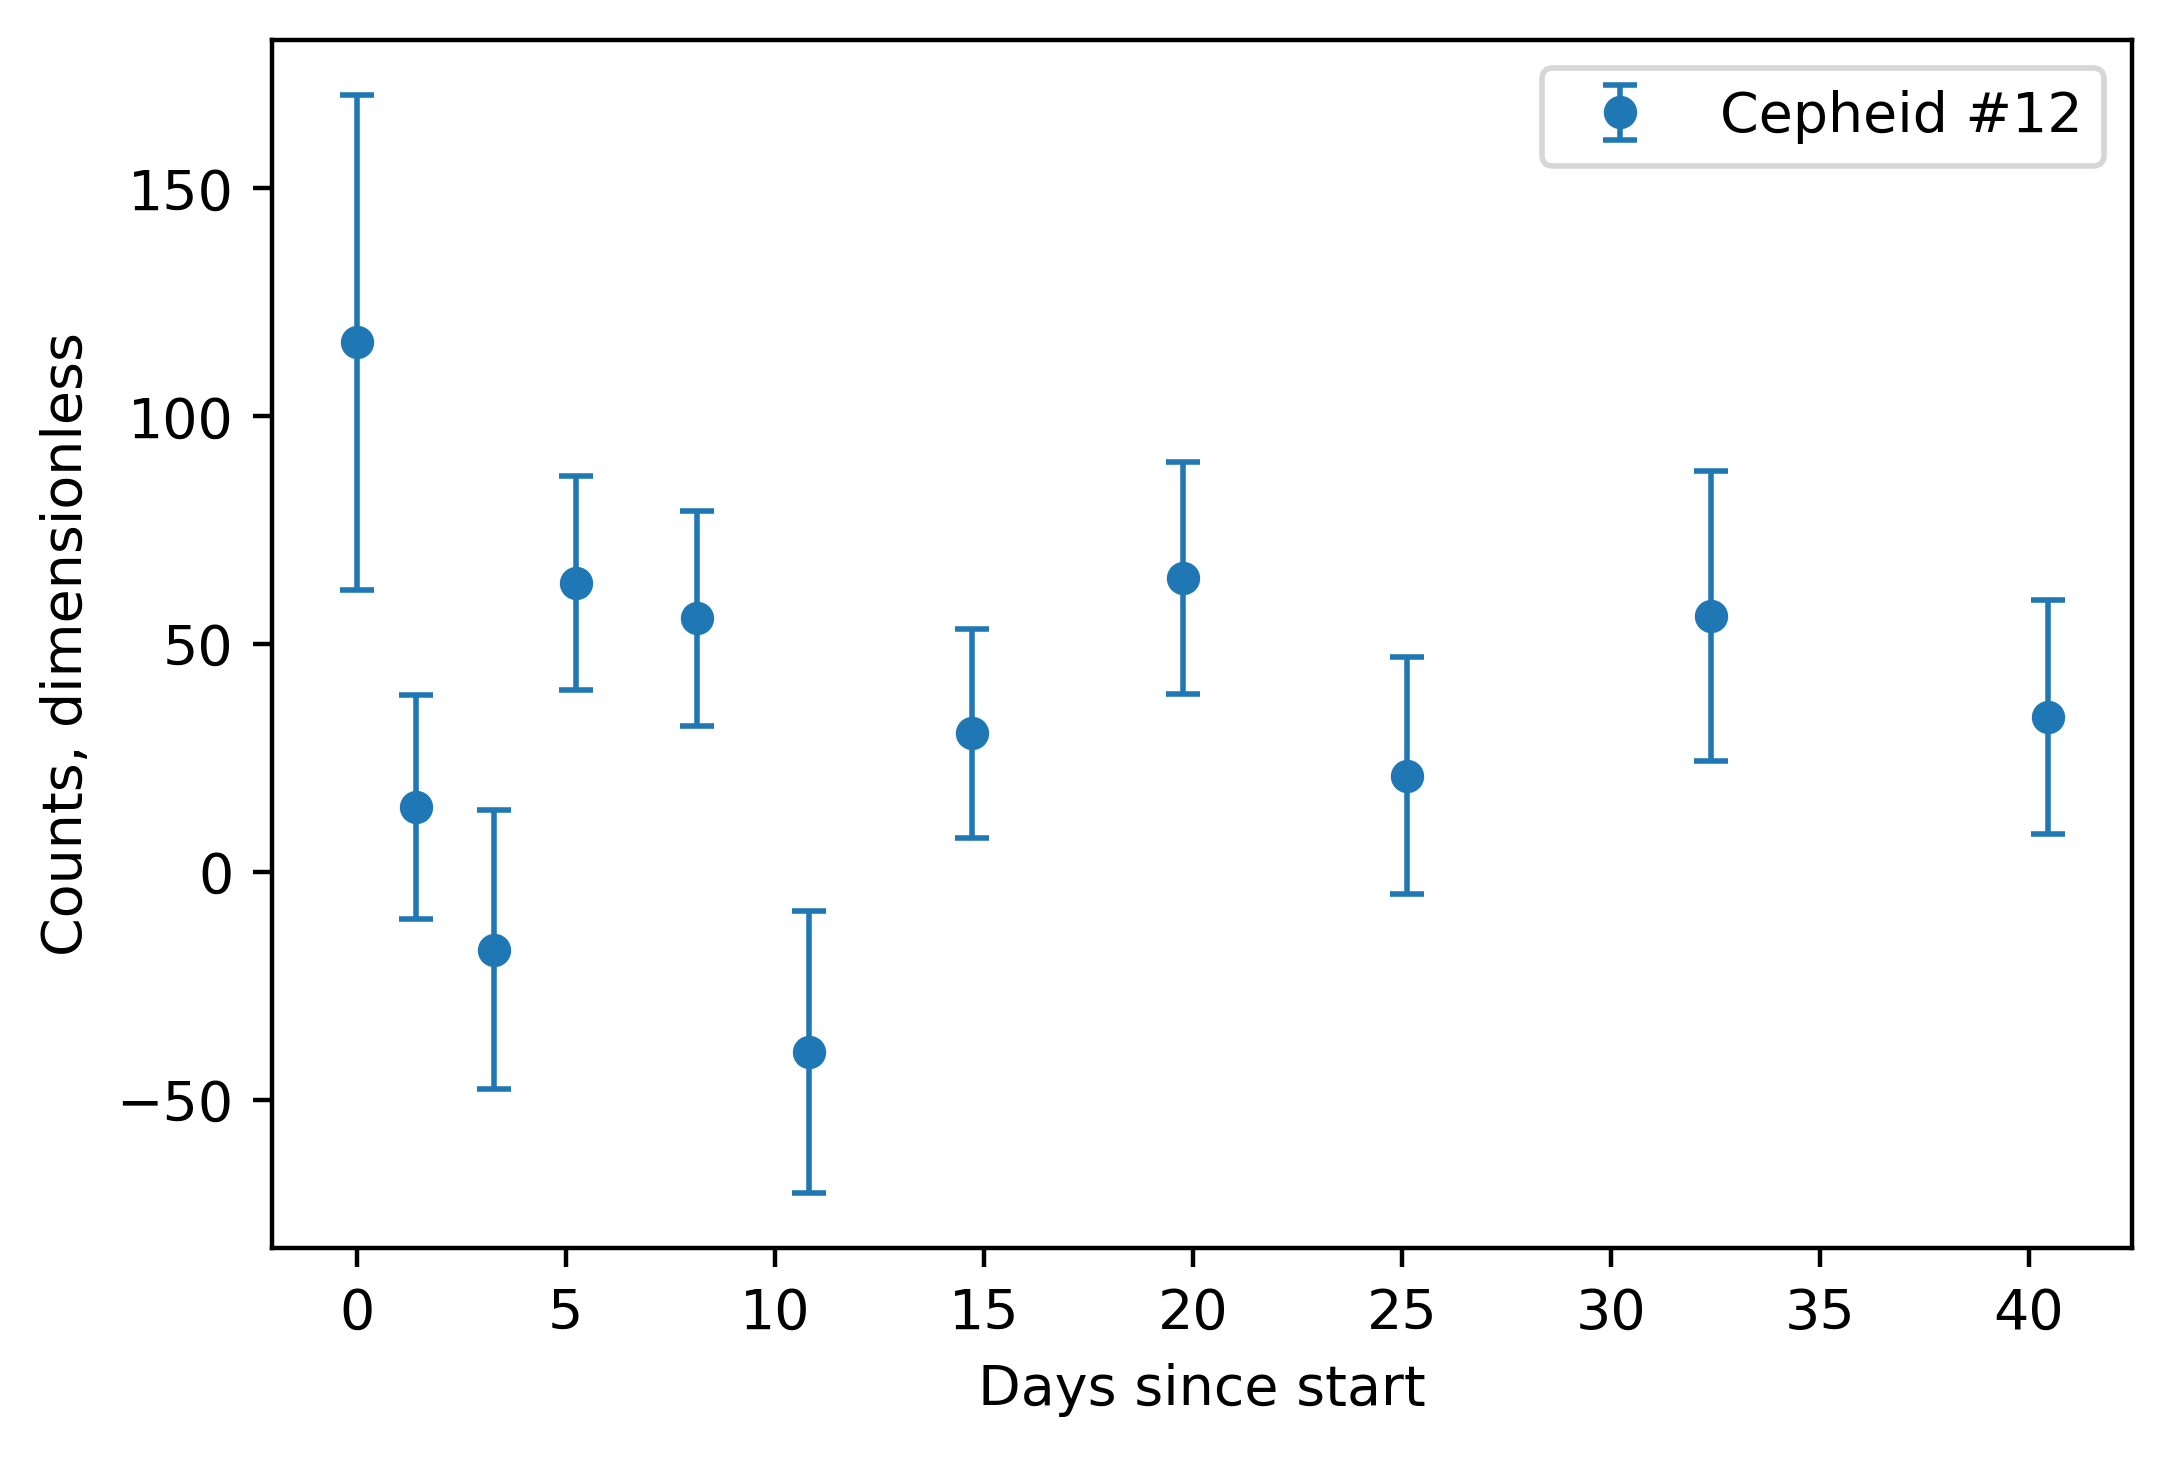

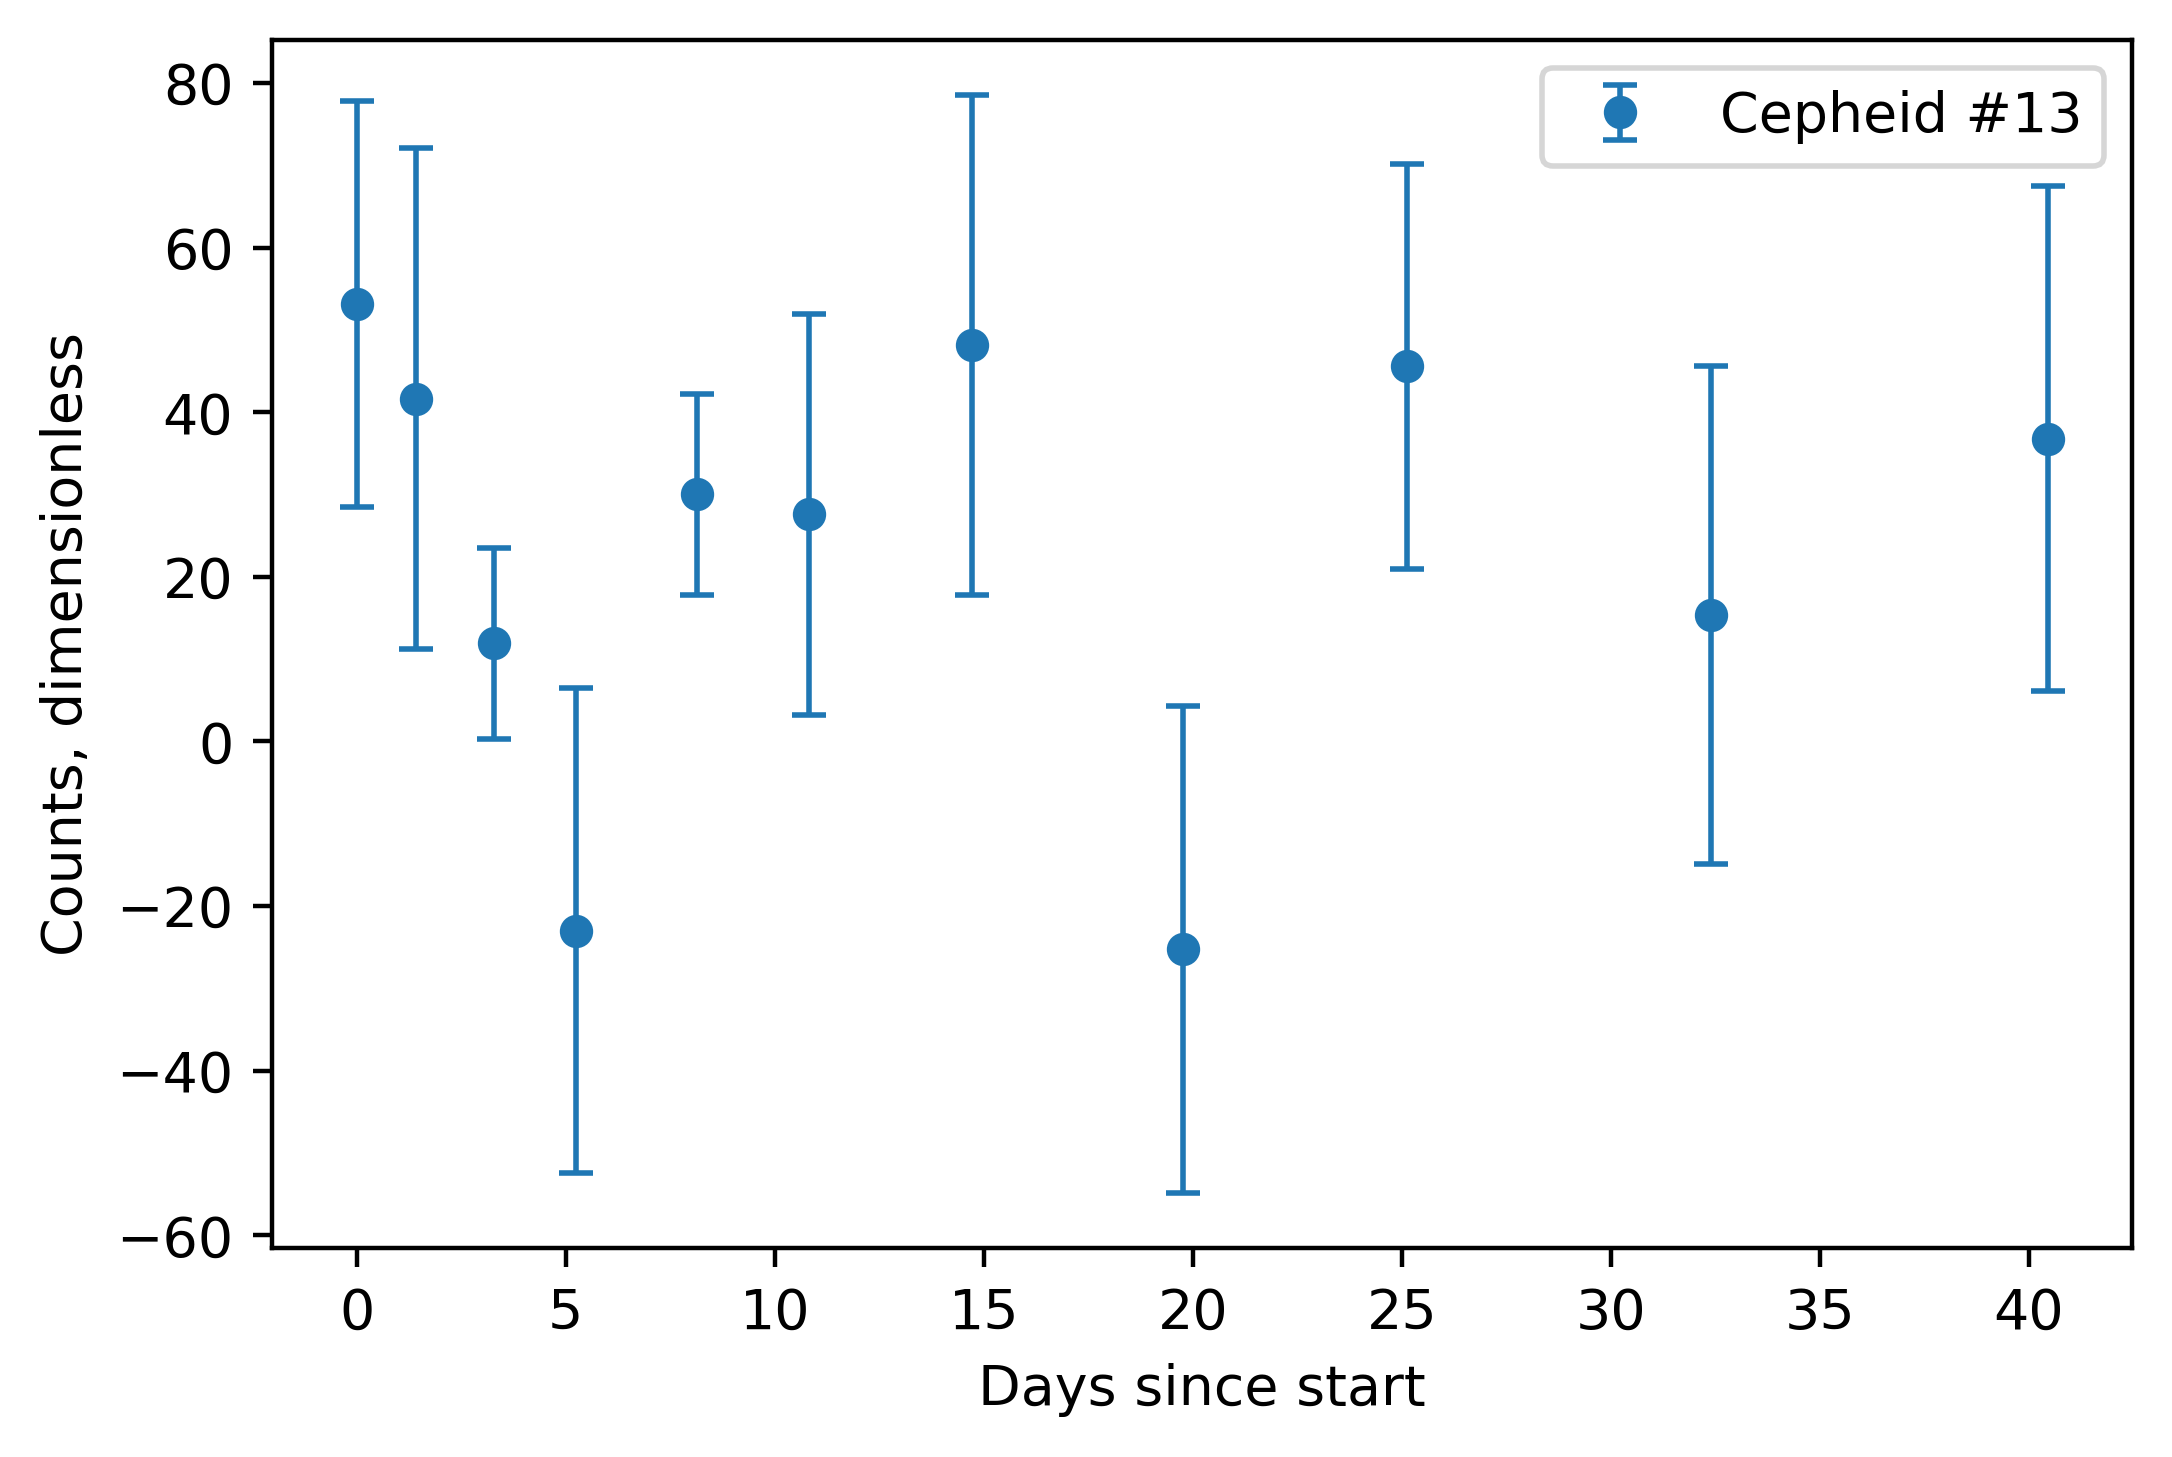

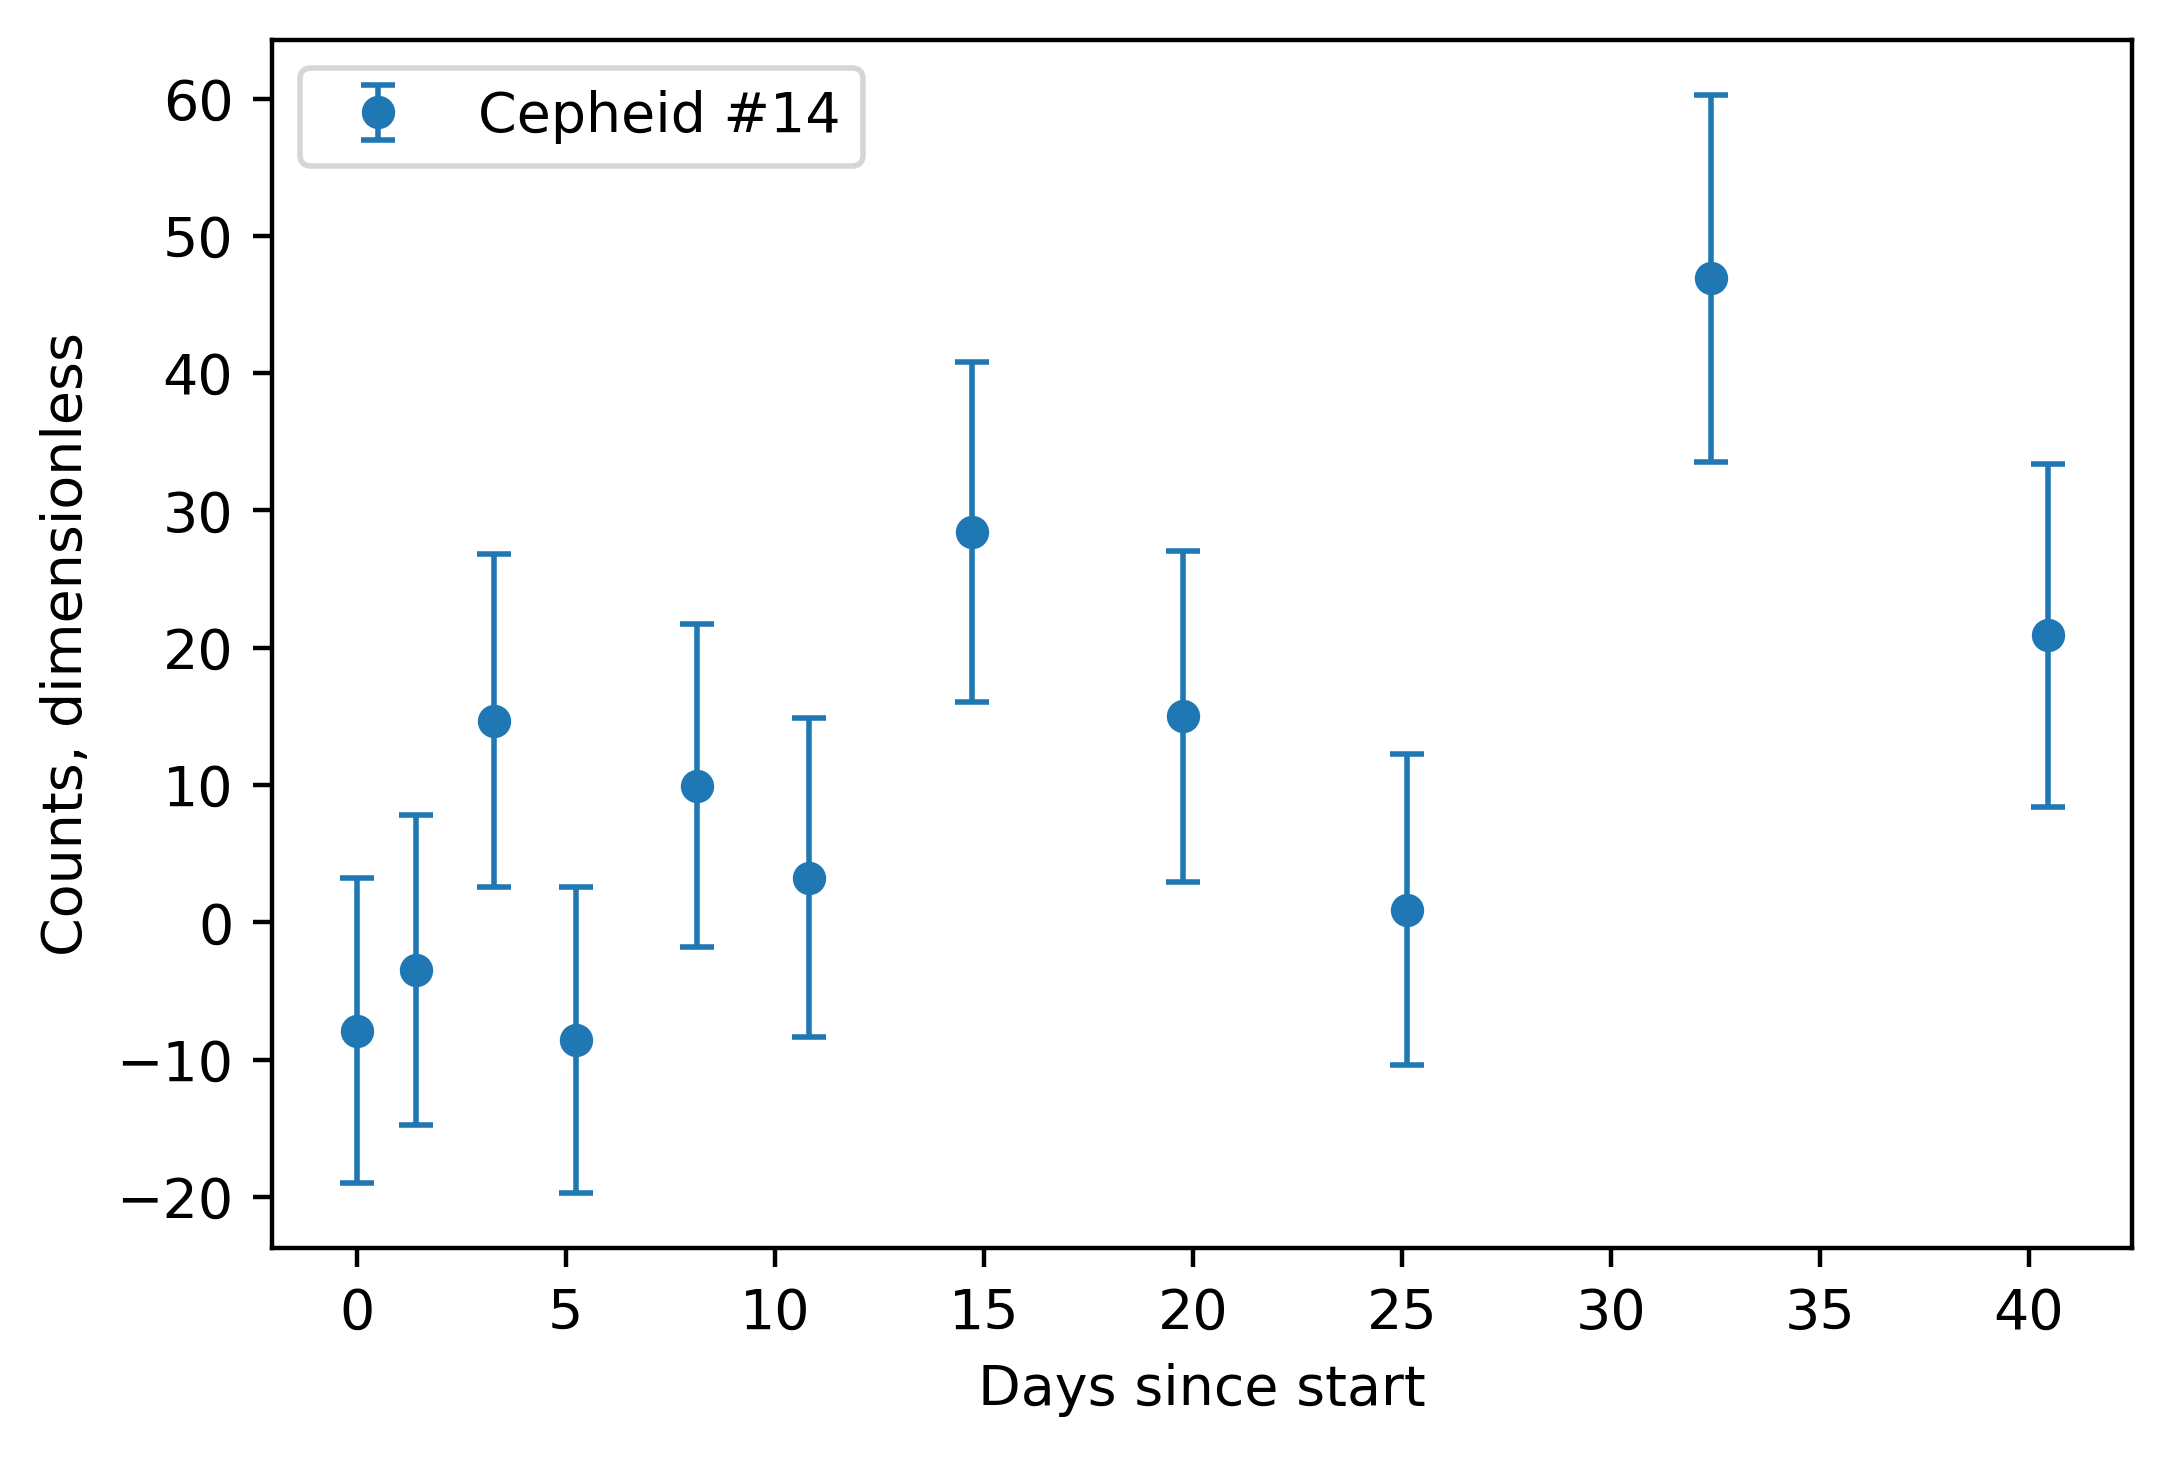

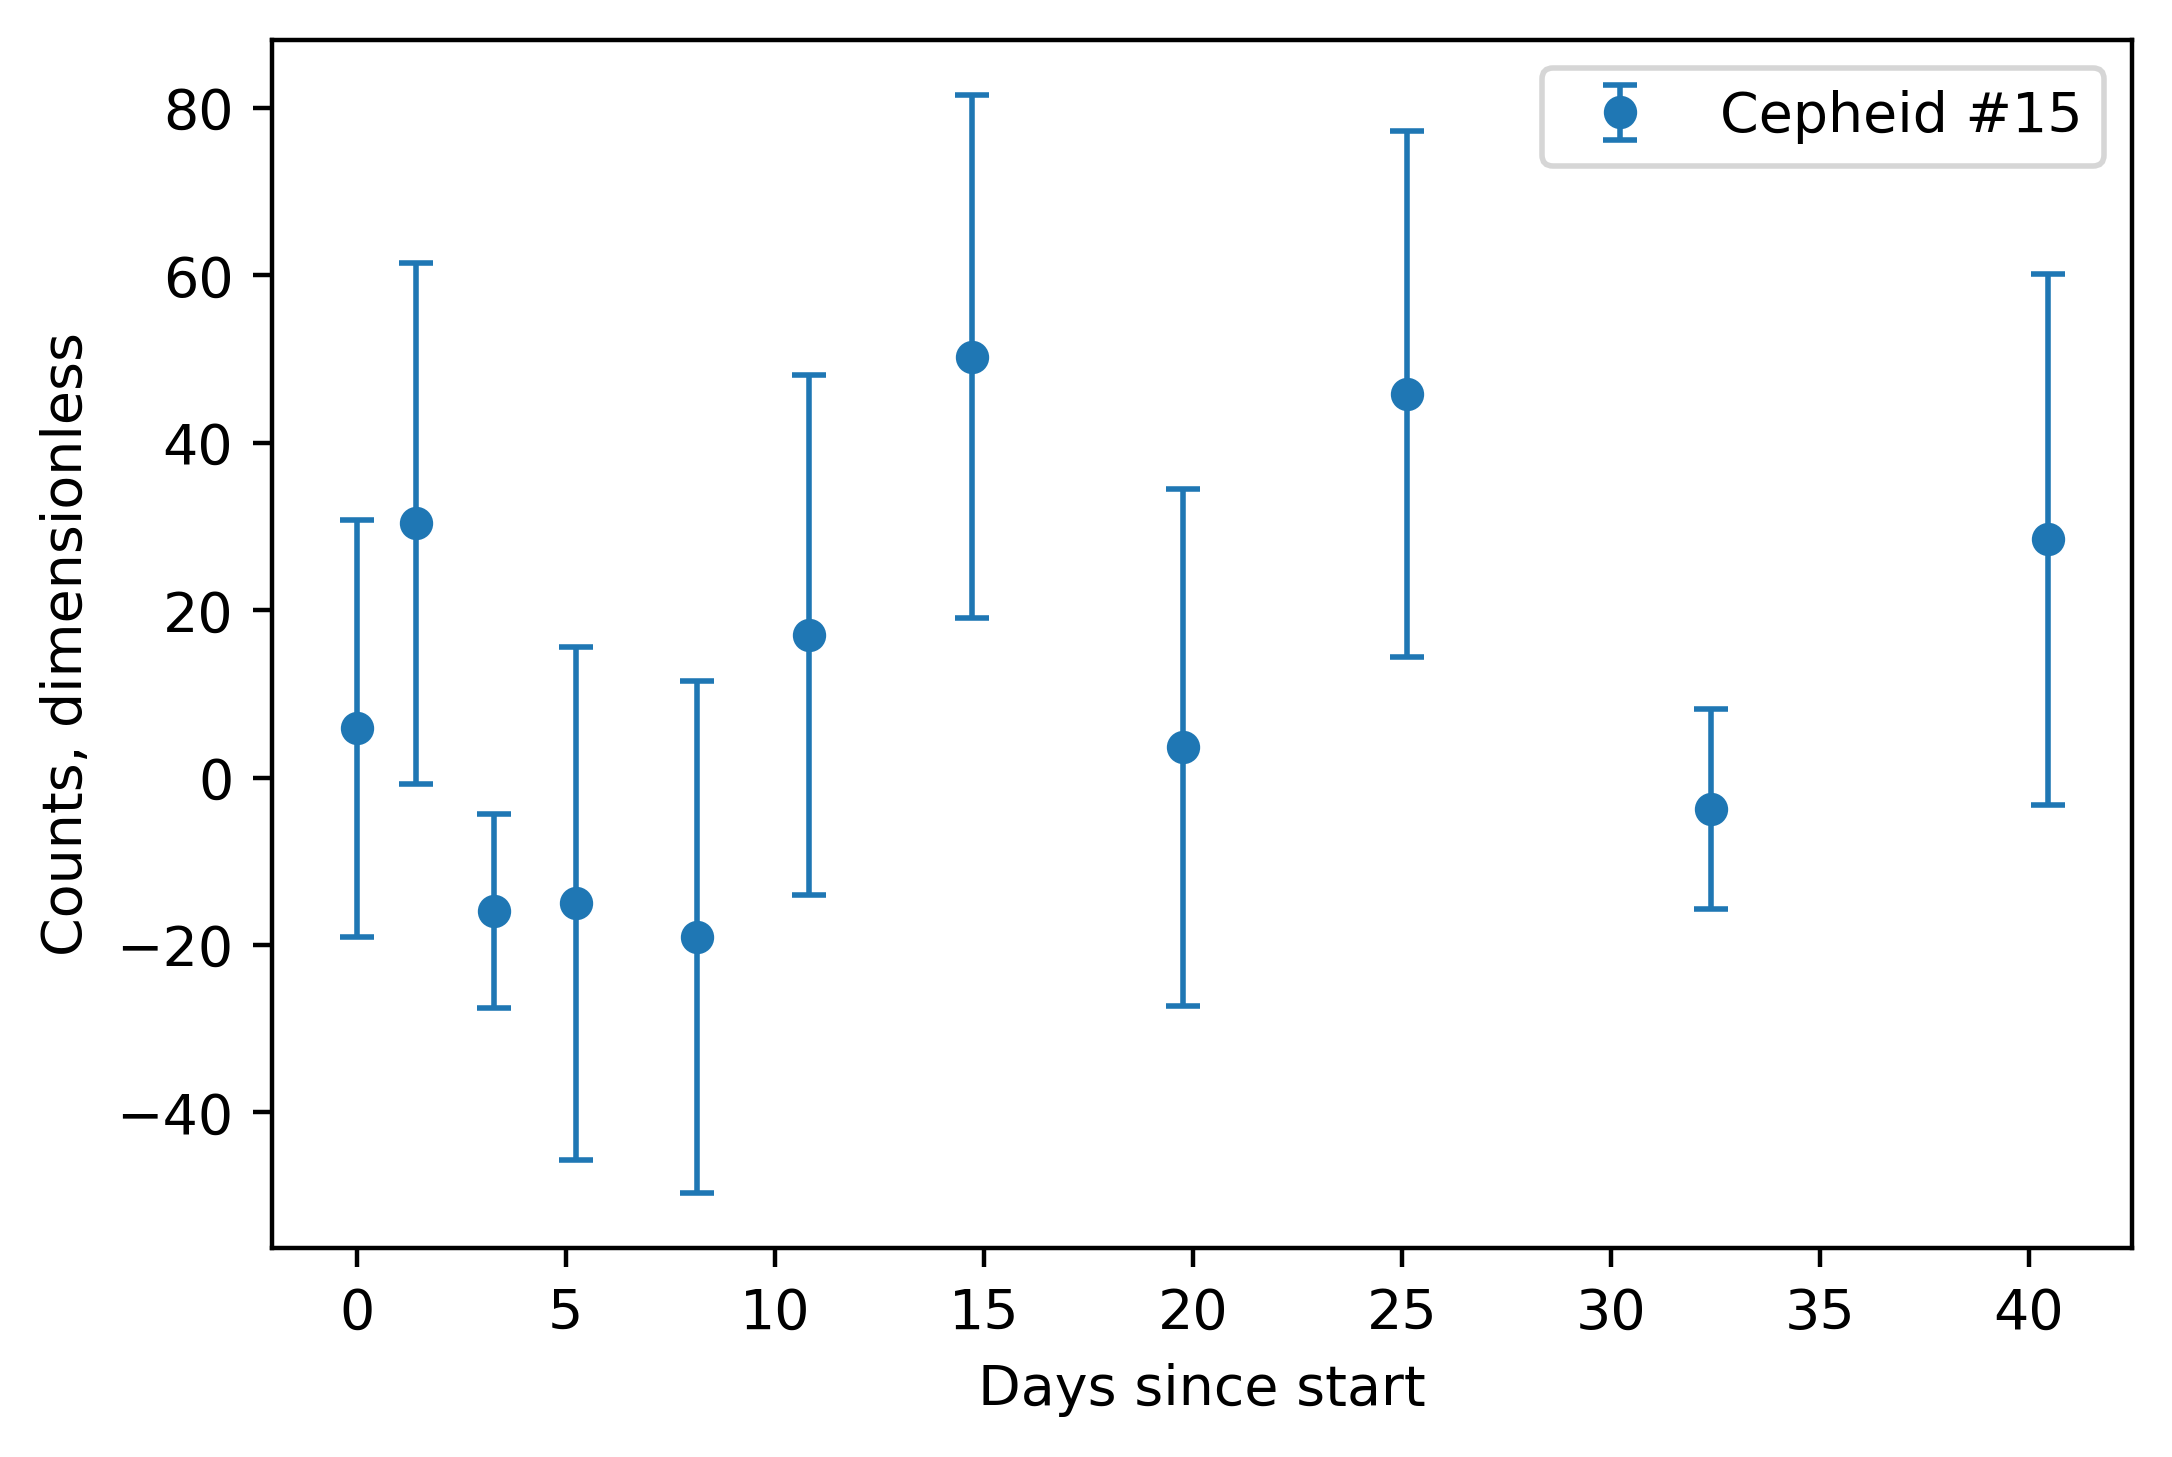

In [ ]:
# plot light curve of cepheid excluding 12th day for viewing conveinence
mpl.rcParams["figure.dpi"] = 400
for cepheid_index in np.arange(0, len(counts[0, :])):
    plt.errorbar(
        dates[:11],
        counts[:11, cepheid_index],
        errors[:11, cepheid_index],
        fmt="o",
        markersize=5,
        elinewidth=1,
        label=r"Cepheid #" + str(cepheid_index + 1),
        capsize=3,
    )
    # plt.title(
    #     r"Variations in counts for cepheid number " + str(cepheid_index + 1),
    # )
    plt.xlabel("Days since start")
    plt.ylabel("Counts, dimensionless")
    plt.legend(loc='best')
    # plt.tight_layout()
    plt.show()


In order to determine the period T, we need to consider phase folding. We trial many values of T in the formula for phase folding and minimise to find accepted value.
Phase folding equation:
$$\Phi = \frac{mod(t,T)}{T}$$

In [ ]:
test_T = np.linspace(1, 30, 100)
accepted_period_array = np.array([])
given_period_array = np.array(
    [
        21.3,
        17.2,
        17,
        20.5,
        14.0,
        13.9,
        10.1,
        11.2,
        15.2,
        17.6,
        30.7,
        17.6,
        12.4,
        13.7,
        13.0,
    ]
)
for i in range(len(counts[0, :])):
    accepted_period_array = np.append(
        accepted_period_array, find_period_by_folding(dates, counts[:, i], test_T)
    )
    print("For cepheid {0}, accepted period = {1:.2f}, given period = {2:.2f}".format((i+1), accepted_period_array[i], given_period_array[i]))
    # print("cepheid number", str(i+1), ": Accepted period =", accepted_period_array[i], ", given period =",given_period_array[i]) 


For cepheid 1, accepted period = 24.43, given period = 21.30
For cepheid 2, accepted period = 5.39, given period = 17.20
For cepheid 3, accepted period = 29.12, given period = 17.00
For cepheid 4, accepted period = 7.74, given period = 20.50
For cepheid 5, accepted period = 7.74, given period = 14.00
For cepheid 6, accepted period = 28.83, given period = 13.90
For cepheid 7, accepted period = 1.29, given period = 10.10
For cepheid 8, accepted period = 24.43, given period = 11.20
For cepheid 9, accepted period = 1.29, given period = 15.20
For cepheid 10, accepted period = 2.46, given period = 17.60
For cepheid 11, accepted period = 28.83, given period = 30.70
For cepheid 12, accepted period = 1.00, given period = 17.60
For cepheid 13, accepted period = 24.43, given period = 12.40
For cepheid 14, accepted period = 28.83, given period = 13.70
For cepheid 15, accepted period = 28.83, given period = 13.00


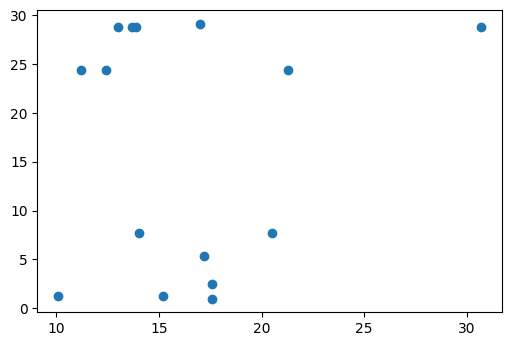

In [ ]:
mpl.rcParams["figure.dpi"] = 100
plt.scatter(given_period_array, accepted_period_array)

In [ ]:
print(given_period_array)

[21.3 17.2 17.  20.5 14.  13.9 10.1 11.2 15.2 17.6 30.7 17.6 12.4 13.7
 13. ]


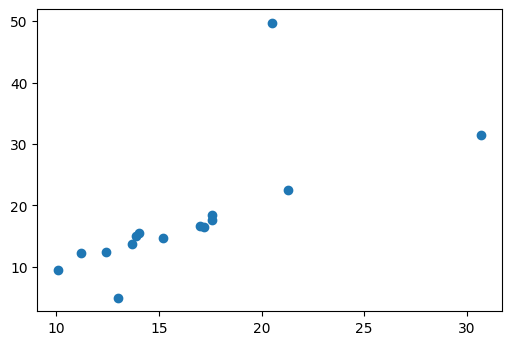

In [ ]:
accepted_period_array_hoax = np.array([22.43, 16.55, 16.69, 49.69, 15.555 , 15, 9.5, 12.3, 14.69, 18.5, 31.5,
       17.6, 12.4, 13.7, 5])

plt.scatter(given_period_array, accepted_period_array_hoax)

*How big do you think the χ2 of each fit is?* - A χ2 measurement is not defined for a non-analytic function.

*Measure the mean apparent brightness of each Cepheid. The scaling of the HST data is such that a star which gives 1000 counts would have an apparent magnitude of 22.57. You may wish to look up the definitions of absolute and apparent magnitude in PHYS10191 notes or any textbook on introductory astronomy (e.g. [2]). Use your data to calculate the absolute magnitudes of the Cepheids, and hence the distance to NGC4258 with an estimate of the error.*


Apparent magnitude: brightest stars have $$m=1,$$ while the dimmest stars have $$m=6$$ with their intensity being 100 times higher. $$\therefore\frac{I_2}{I_1}≈2.51^{m_1-m_2}.$$ Absolute magnitude depends only on luminosity and not the distance and shows what apparent magnitude would be if the distance to the star would be 10 parsecs. $$m-M=5\log_{10}\left({\frac{d}{10}}\right),$$ $$\therefore d=10^{\frac{m-M}{5} + 1},$$ $$\sigma_d = \frac{\ln10}{50}  \sqrt{\left(\sigma_m^2 + \sigma_M^2 \right)^2 + 10^{2(m-M)/5}}$$ HST orbits the Earth. <br>
For classical Cepheids, the period luminosity law  for finding the absolute magnitude is $$M=(-2.43\pm0.12)(\log_{10}P-1)-(4.05\pm0.02),$$
$$\sigma_M=\sqrt{\left(0.12 - \frac{0.12 \ln P}{\ln10} \right)^2+0.02^2}$$<br> To convert HST data in counts to apparent magnitude, we use given relation between counts and magnitude in the form $$m=2.51\log{\left(\frac{c}{1000}\right)}+22.57,$$ $$\sigma_m=1.09\frac{\sigma_c}{c}.$$ **The extinction coefficient is assumed to be zero.**

In [ ]:
# As we have points with a count below zero, we ignore them for the 
# apparent magnitude calculation

# Find the mean brightness for each cepheid:
# make the values to use for the mean (not nan) to FALSE
indices_to_mask = np.isnan(np.log10(counts))
masked_counts = np.ma.array(counts, mask=indices_to_mask)
masked_errors = np.ma.array(errors, mask=indices_to_mask)

stars_mean_apparent_magnitudes = np.mean(
    (-2.51 * np.log10(masked_counts / 1000) + 22.57), axis=0
)

stars_mean_apparent_magnitudes_errors = np.mean(
    (1.09 * masked_errors / masked_counts), axis=0
)


# absolute_magnitudes = (-2.43) * (np.log10(accepted_period_array)- 1) - 4.05
stars_absolute_magnitudes = (-2.81) * (np.log10(accepted_period_array) - 1) - 4.26
stars_absolute_magnitudes_errors = np.sqrt(
    (0.12 - (0.12 * np.log(accepted_period_array) / np.log(10))) ** 2 + 0.02**2
)

print("Apparent magnitudes of each star:", str(stars_mean_apparent_magnitudes), "\n")
print("Absolute magnitudes of each star:", str(stars_absolute_magnitudes), "\n")

average_apparent_magnitude = np.mean(stars_mean_apparent_magnitudes)
average_absolute_magnitude = np.mean(stars_absolute_magnitudes)

average_apparent_magnitude_error = np.sqrt(
    np.sum(stars_mean_apparent_magnitudes_errors**2)
) / len(stars_mean_apparent_magnitudes_errors)
average_absolute_magnitude_error = np.sqrt(
    np.sum(stars_absolute_magnitudes_errors**2)
) / len(stars_absolute_magnitudes_errors)


print("Average absolute magnitude: {}".format(average_absolute_magnitude))
print("Average apparent magnitude: {}\n".format(average_apparent_magnitude))

distance = 10 ** ((average_apparent_magnitude - average_absolute_magnitude) / 5 + 1)
error_distance = (
    np.log(10)
    / 50
    * np.sqrt(
        (average_apparent_magnitude_error**2 + average_absolute_magnitude_error**2)
        + 10 ** ((average_apparent_magnitude - average_absolute_magnitude) / 2.5)
    )
)

print(
    "This means the mean distance is ",
    si_format(distance),
    "Pc ± ",
    si_format(error_distance),
    "Pc",
)


Apparent magnitudes of each star: [25.91670868845819 26.397832556107588 25.635949523341214
 26.932485608656997 26.183372034580326 27.41914586456324
 26.047979565913636 26.48517176778697 26.14433456760378 26.246989981389255
 25.539342022188837 26.237643965122267 26.35322132683658 27.50677878945051
 26.921809918814436] 

Absolute magnitudes of each star: [-5.35028189 -3.50665604 -5.56442855 -3.94694795 -3.94694795 -5.55209076
 -1.76352512 -5.35028189 -1.76352512 -2.55083052 -5.55209076 -1.45
 -5.35028189 -5.55209076 -5.55209076] 

Average absolute magnitude: -4.183471328534933
Average apparent magnitude: 26.397917745387595

This means the mean distance is  13.1 M Pc ±  60.2 k Pc


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
error_distance / 1000000

0.0601898830034561

In [ ]:
average_absolute_magnitude_error

0.017843375820578048

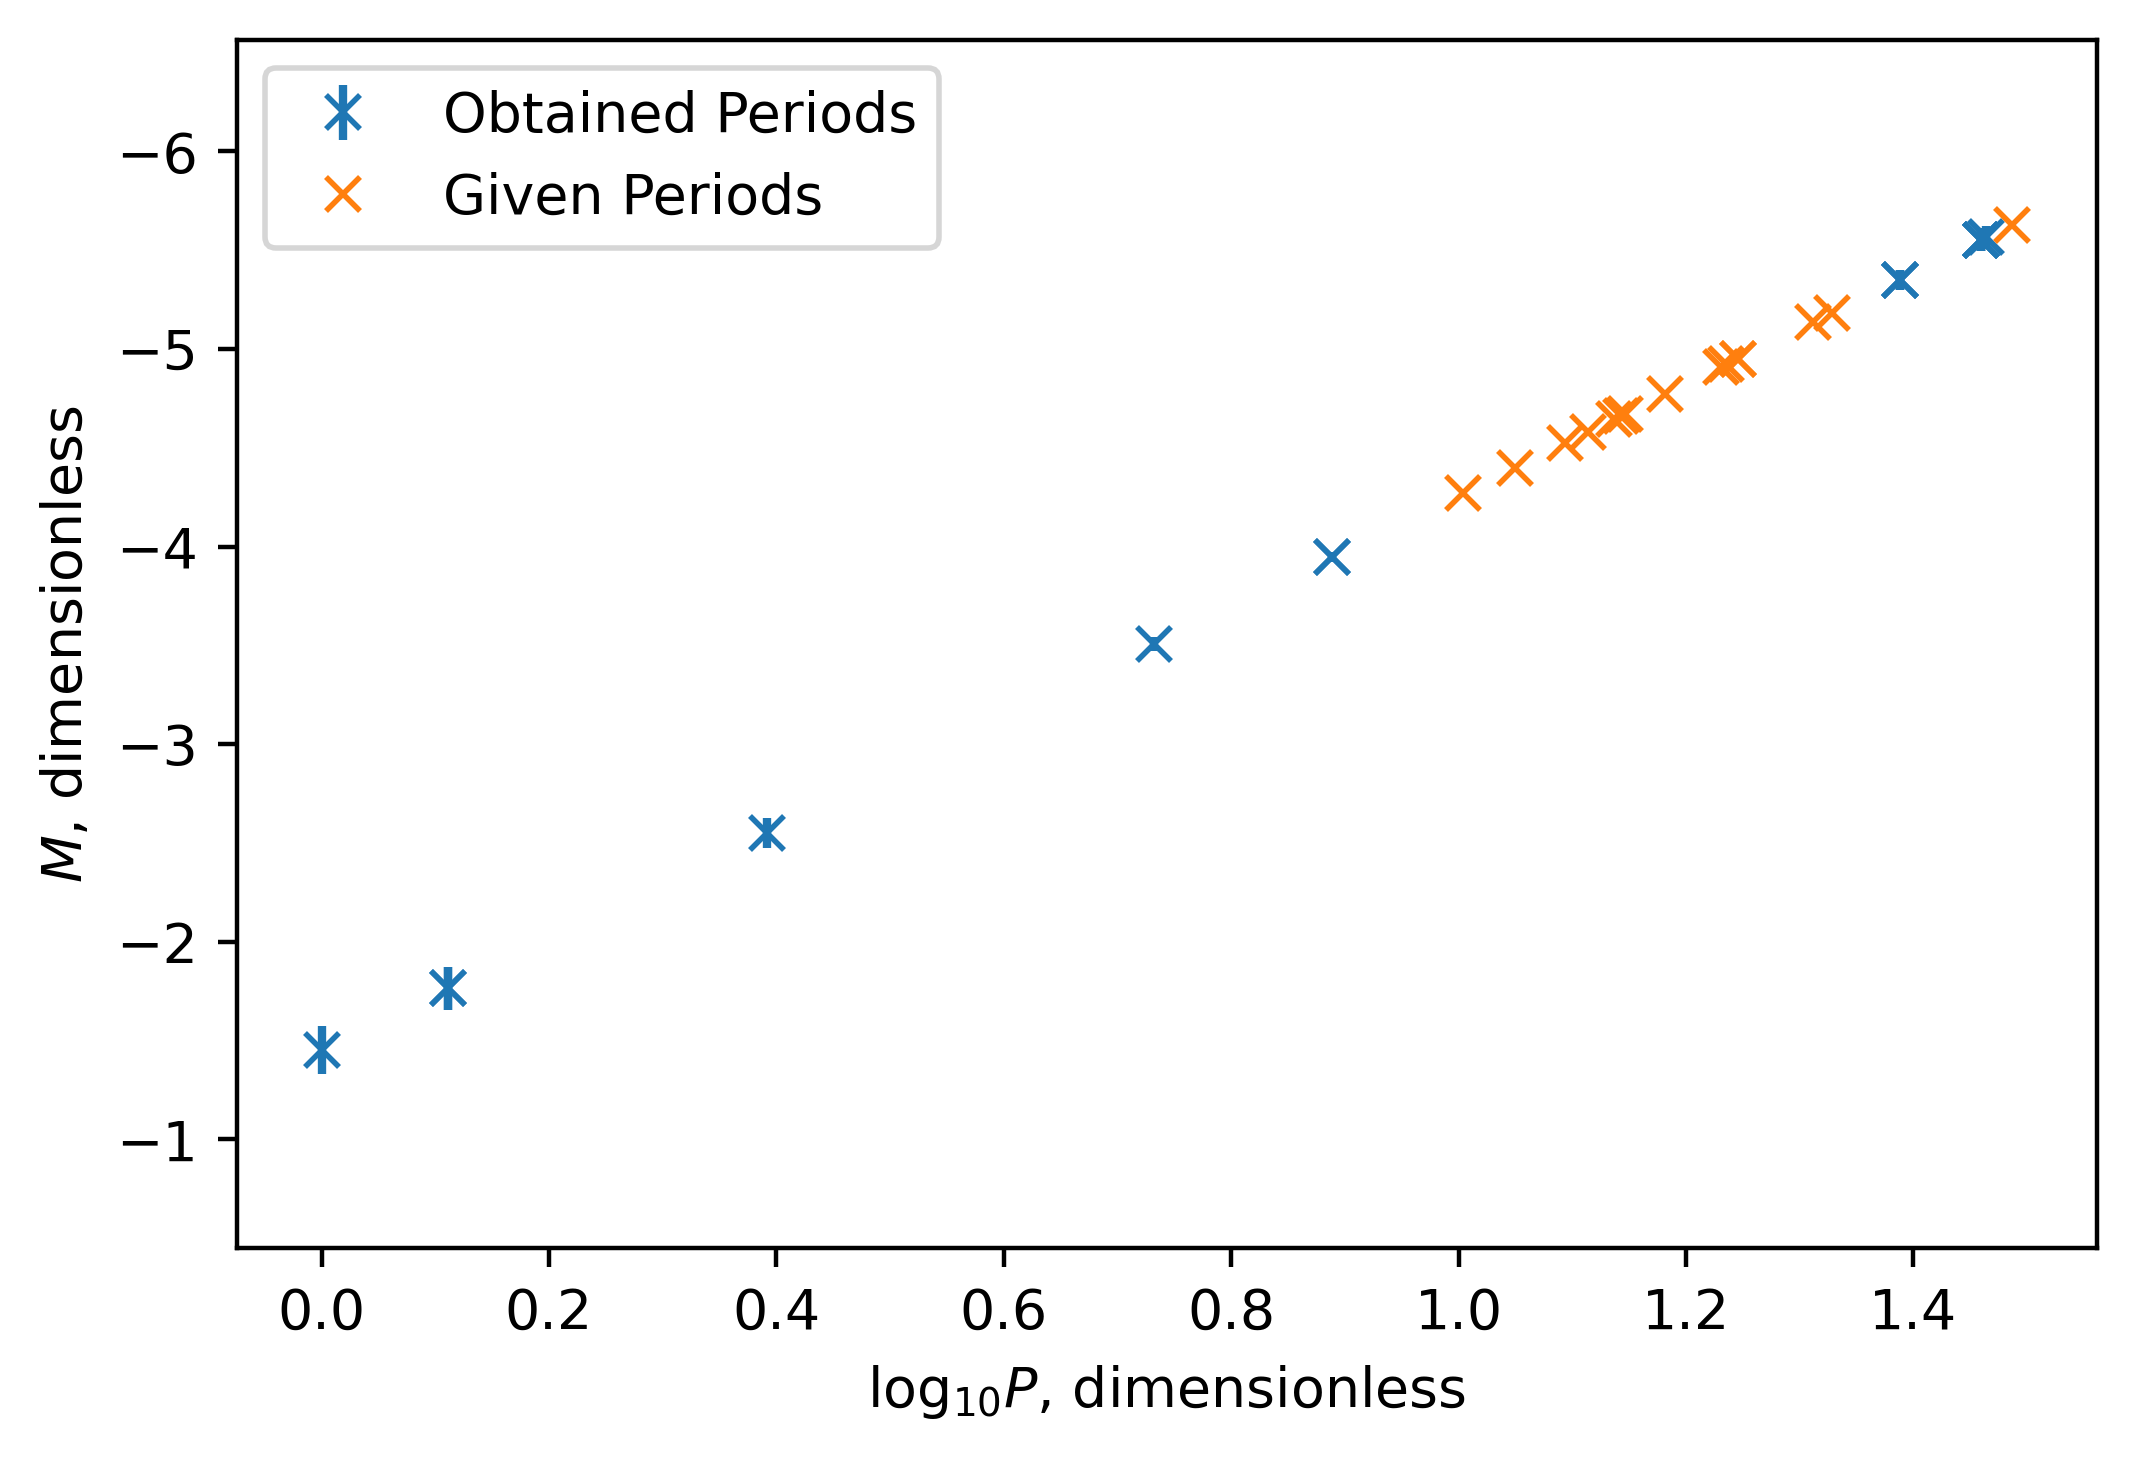

In [ ]:
#plot period against magnitude

given_abs_mags = (-2.81) * (np.log10(given_period_array) - 1) - 4.26

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(np.log10(accepted_period_array), stars_absolute_magnitudes, yerr=stars_absolute_magnitudes_errors, fmt='x', label='Obtained Periods')
ax.errorbar(np.log10(given_period_array), given_abs_mags, fmt='x', label='Given Periods')
ax.set_ylim([np.max(stars_absolute_magnitudes)+ 1,np.min(stars_absolute_magnitudes) -1])

ax.set_xlabel(r'$\log_{10}{P}$, dimensionless')
ax.set_ylabel(r'$M$, dimensionless')
plt.legend(loc='upper left')

# plt.savefig('Logged period luninosity relation.png', dpi=600)
# files.download('Logged period luninosity relation.png')
plt.show()

*If the redshift of NGC4258 corresponds to a recession velocity of 440km/s, deduce a value for the Hubble constant. What is the major error likely to be? How is the Hubble constant derived from Cepheid measurements in practice?*<br>
Recession velocity can be measured by observing the wavelength shifts of spectral lines emitted by the object, known as the object's cosmological redshift, and can be assumed to have little error. The formula for the Hubble constant then is $$H_0=\frac{v_r}{D},$$ $$ \sigma_{H_0}=\frac{v_r\sigma_D}{D^2}$$ where distance is in Mpc. The real Hubble constant is 69.8 km/s/Mpc. <br>

The major error comes from our methodology in the distance measurement, in which there is both error in the absolute and apparent magnitude calculation. However, the errors from the absolute magnitude (i.e. the calculated periods) are much less prominent, as the fitting range for the period is limited by the physics of cepheids, and the average absolute magnitude is always going to be of similar order. As for the relative magnitude, we took the datapoints for which the counts are smaller than 0 as anomalous due to their incompatibility with the logarithm, which, in turn, substantially increased the average absolute magnitude, as the deleted points would be smaller by definition (we eliminated the pixel shift by typing all the coordinates for all regions manually). Assuming all of the coordinates are correct, the problem of negative datapoints boils down to the fact that many pixels in every picture have negative values, an aspect for which the demo and further discussion is below. Another small source of error is the fact that we do not take into account the effects of the light attentuation due to dust and gas in the way. To sum up, we got a much higher average apparent magnitude than expected; this is why we get the result that the galaxy is further away than it should be, the Hubble constant is much smaller than expected, and, in turn, the universe is much older than expected.

<br>In practice, a Gaussian function approximation is fitted the absolute magnitude and period of Cepheid variables in our galaxy. The calculations are carried out on samples of Cepheids observed in 23 galaxies to derive the distance modulus (DM) of these galaxies based on the frequency distributions of their periods and intrinsic apparent
magnitudes.


In [ ]:
distance_mpc = distance / 1000000
error_distance_mpc = error_distance / 1000000
hubble_constant = 440 / distance_mpc
error_hubble_constant = 440 * error_distance_mpc / (distance_mpc**2)
print("Hubble constant = ", str(hubble_constant), "±", str(error_hubble_constant))


Hubble constant =  33.66470876373863 ± 0.15503171311874814


*It is useful to measure a couple of stars of different brightnesses randomly chosen from the field. Why?* To make sure that we are really measuring cepheids, which are characterised by periodic pulsation and overall relatively large brigthness. As the exposures from the images from HST can be as long as an hour, we have to check against other sources of variable brightness, such as other variable stars (which may not be cepheids), cosmic rays and other high-energy particles, varying nebulosity (changes in cosmic gas and dust distributions in the galaxy), asteroids, and potential bad pixels.

*What sort of statistics are obeyed by the photon counts that you have obtained by the photometry? Given that 7 photons are detected per count registered on the CCD, what does this tell you about your photometric accuracy and is this consistent with your results?* 

Poisson statistics (Binomial distribution - independent consecutive events, with N=infty). This is why we use the estimation that the error is the square root of the measurement. Also, we can see that at the wavelength of interest the quantum efficiency of the CCD is pretty constant at both configurations of the polariser:<br>
![picture](https://drive.google.com/uc?id=1lXRm66Aa_uW42VyXDBnT9KQi4Qq9KtT_) <br> However, the photometric accuracy is pretty low (which can be seen from relatively large errors on the measured counts), which is consistent with the fact that the number of photons required to record a count is pretty high and the size of the star may be as small as a couple of pixels.

*Can the observations be done from a telescope on the ground instead of the HST?* No, at least not with the same sensors and optics, due to reduced background light and and higher visibility due to te lack of atmosphere.

*Where do Cepheids lie on the Hertzsprung-Russell diagram?*<br>
![picture](https://drive.google.com/uc?id=1q8Jz-pvYgvjFB-CMGN0Cgd1zzy-ldNty) <br> 

That is, classic cepheids typically are giants, bright giants or supergiants, range in absolute magnitude from -1 to -7, in temperature from 3700 to 5500K, have yellow white or yellow vega-relative chromaticity and yellowish-white or pale yellow orange chromaticity.

**Extension - estimating the age of the universe** <br> Not accounting for the variability in the Hubble constant due to the density changes in the universe, we can find its age as $$t=1/H_0,$$ $$\sigma_t=\sigma_{H_0}/H_0^2$$<br>The real age of the universe is approximately 13.8 billion years.


In [ ]:
hubble_constant_years = (
    hubble_constant * 1000 / (3.09e19) * (3.15e7)
)  # kilometers, parsecs, years in si
hubble_constant_years_error = error_hubble_constant * 1000 / (3.09e19) * (3.15e7)
age_of_universe = 1 / hubble_constant_years
age_of_universe_error = hubble_constant_years_error / (hubble_constant_years**2)
print(
    "Age of the universe = ",
    str(age_of_universe),
    "±",
    str(age_of_universe_error),
    "years",
)


Age of the universe =  29138894.022127923 ± 134189.5660033762 years


# Additional notes, questions
Counts are by definition equal to the received flux divided by the exposure time,so how can you have negative pixels? For example, the number of negative pixels is extremely large here:

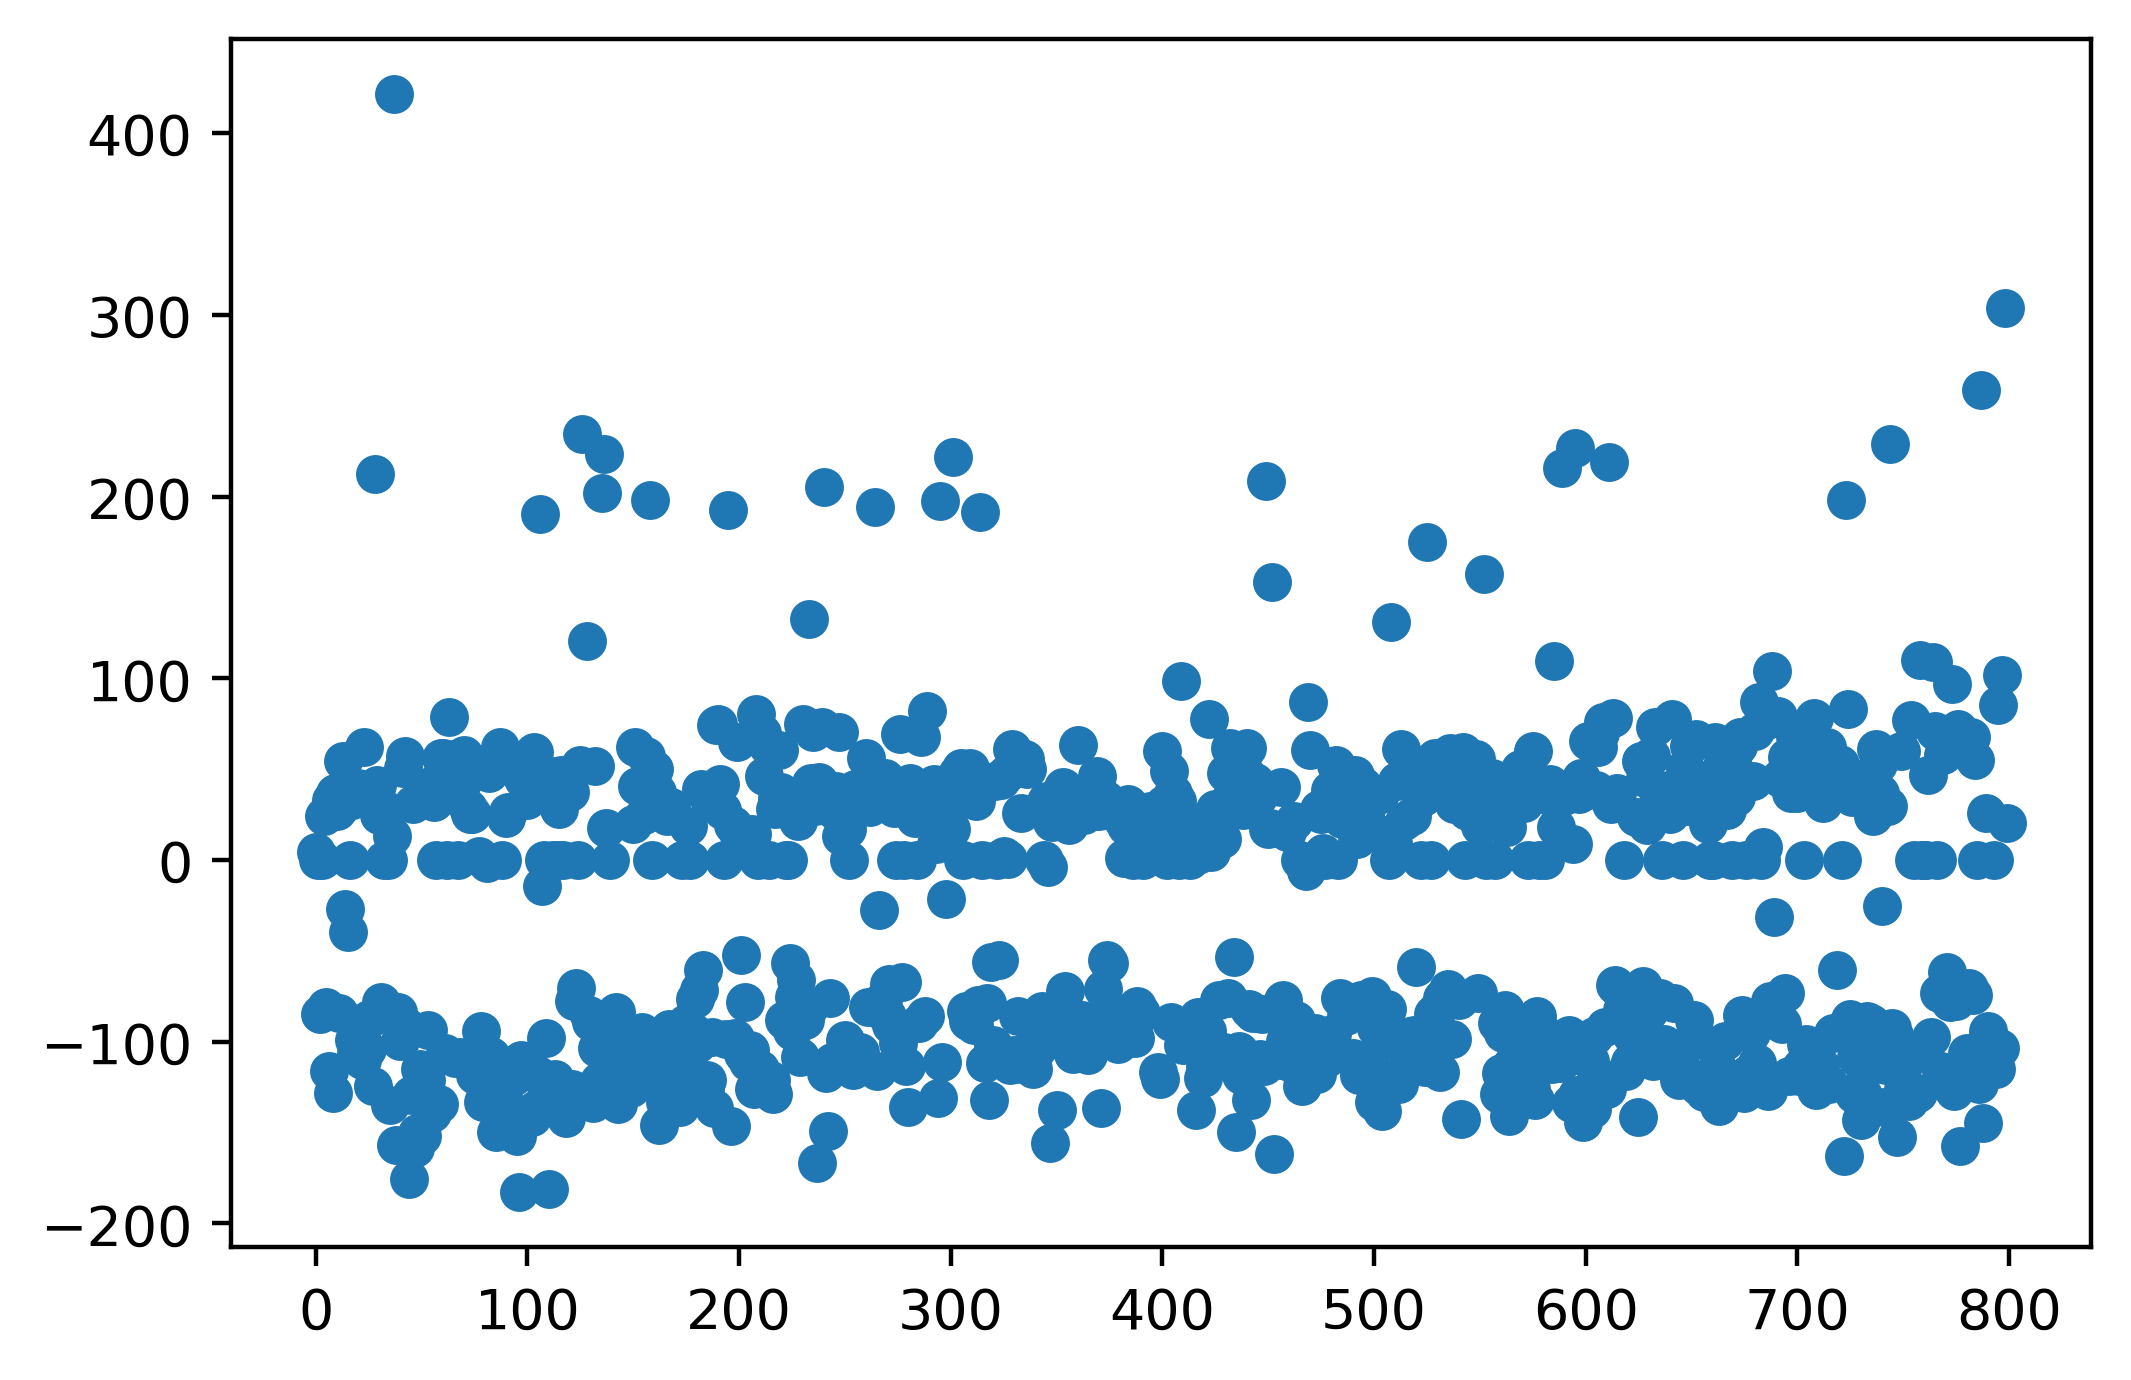

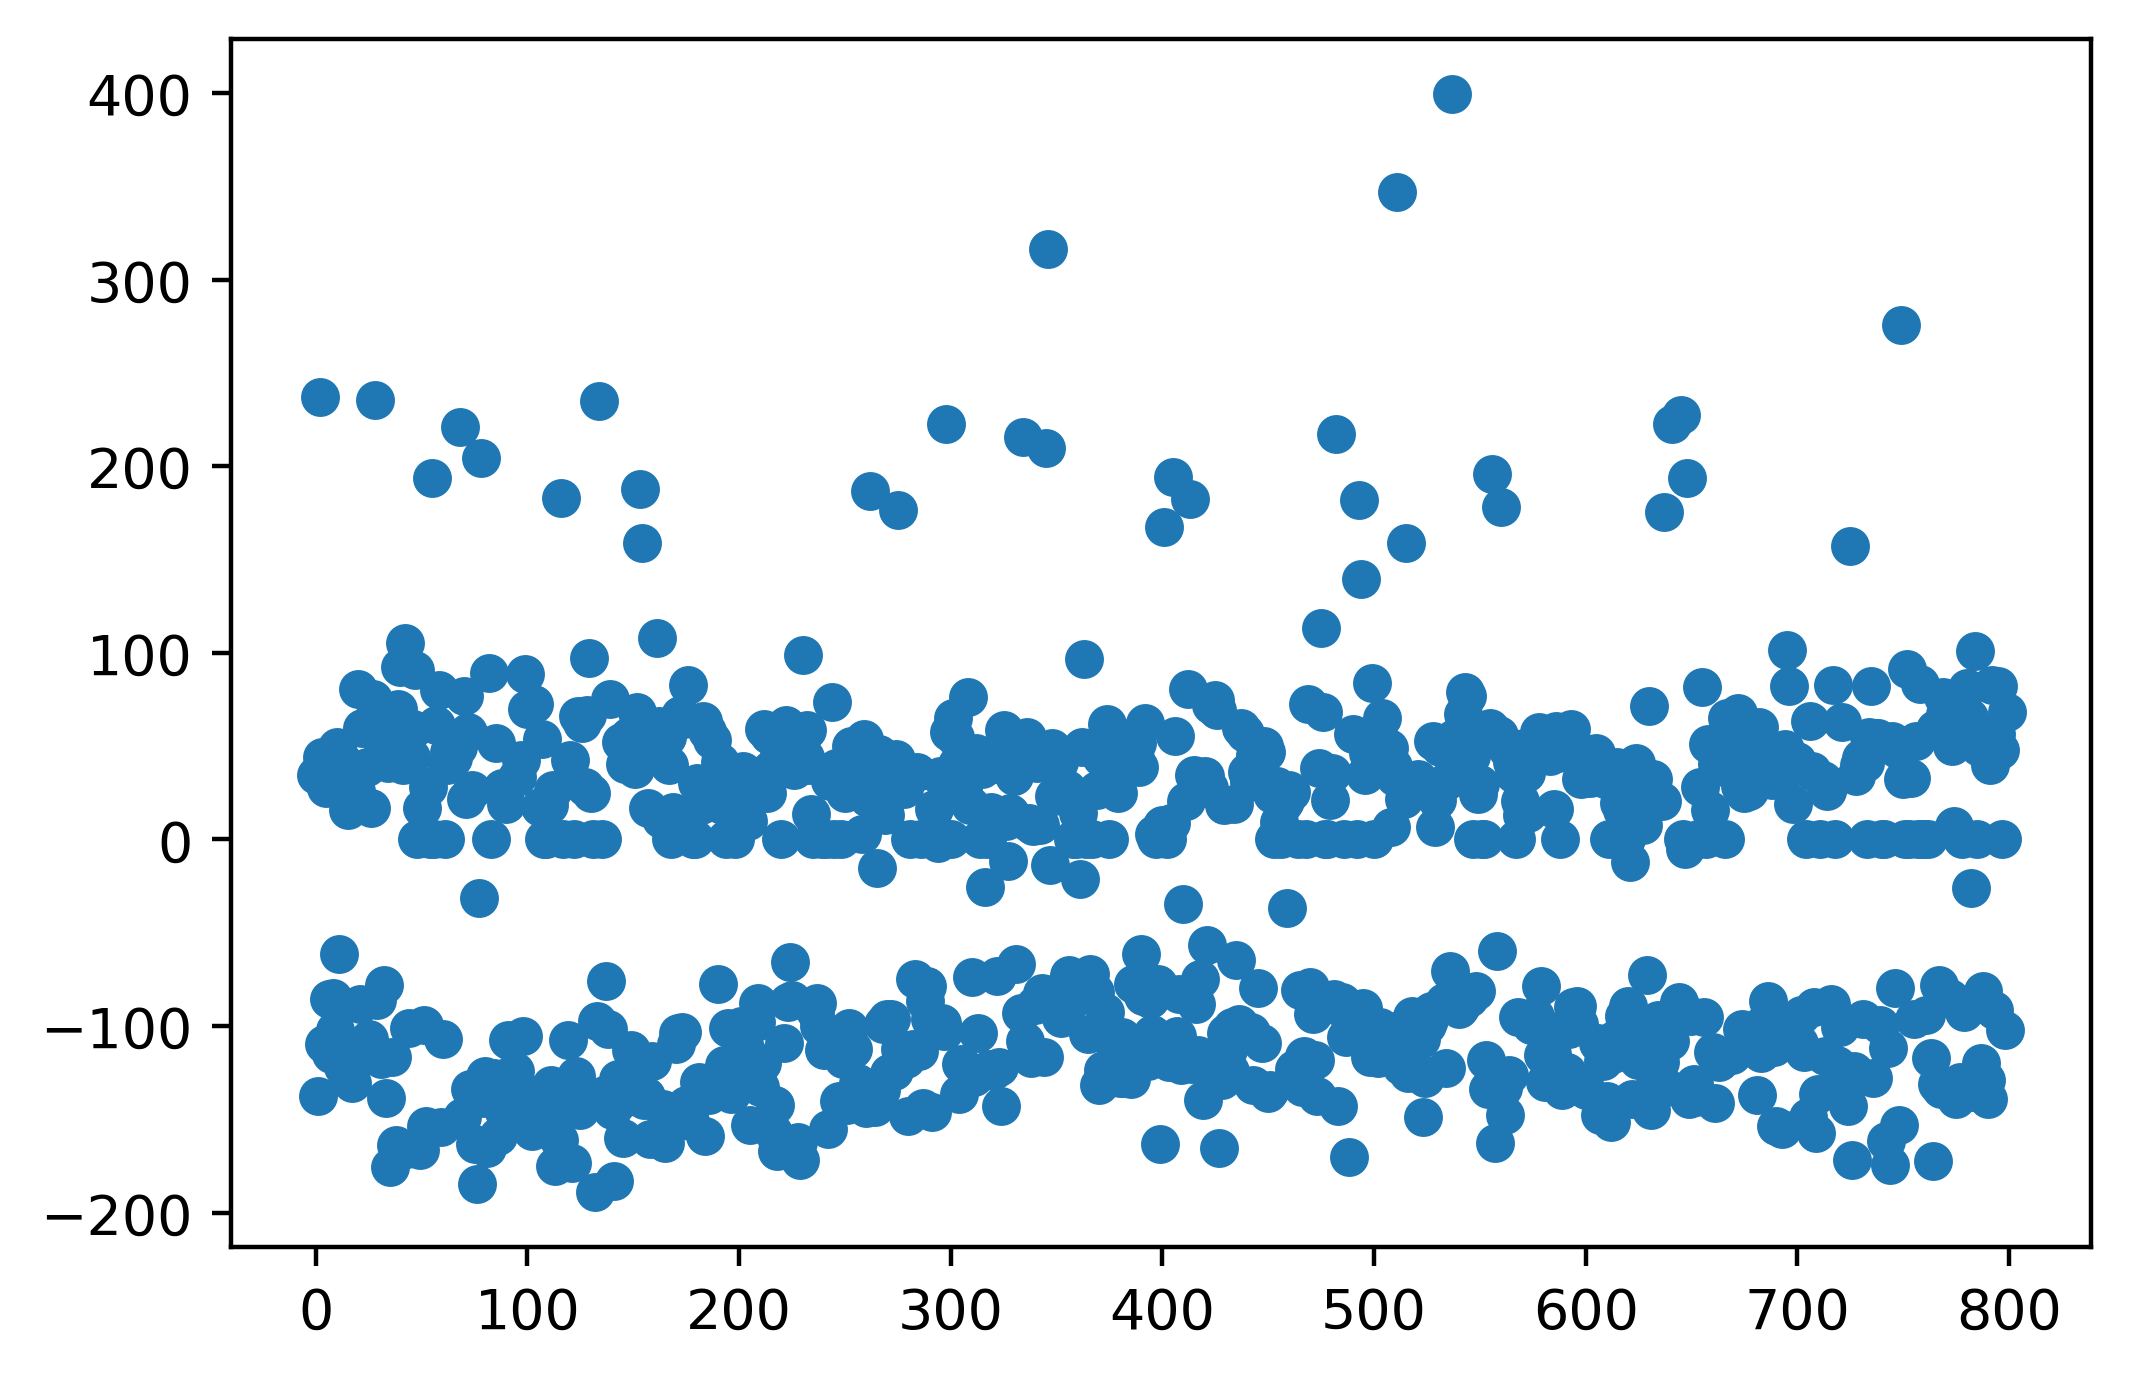

In [ ]:
test_img = img_array_WF3[0]
plt.scatter(np.arange(0,800,1), test_img[0])
plt.show()
plt.scatter(np.arange(0,800,1), test_img[1])

but for the others...

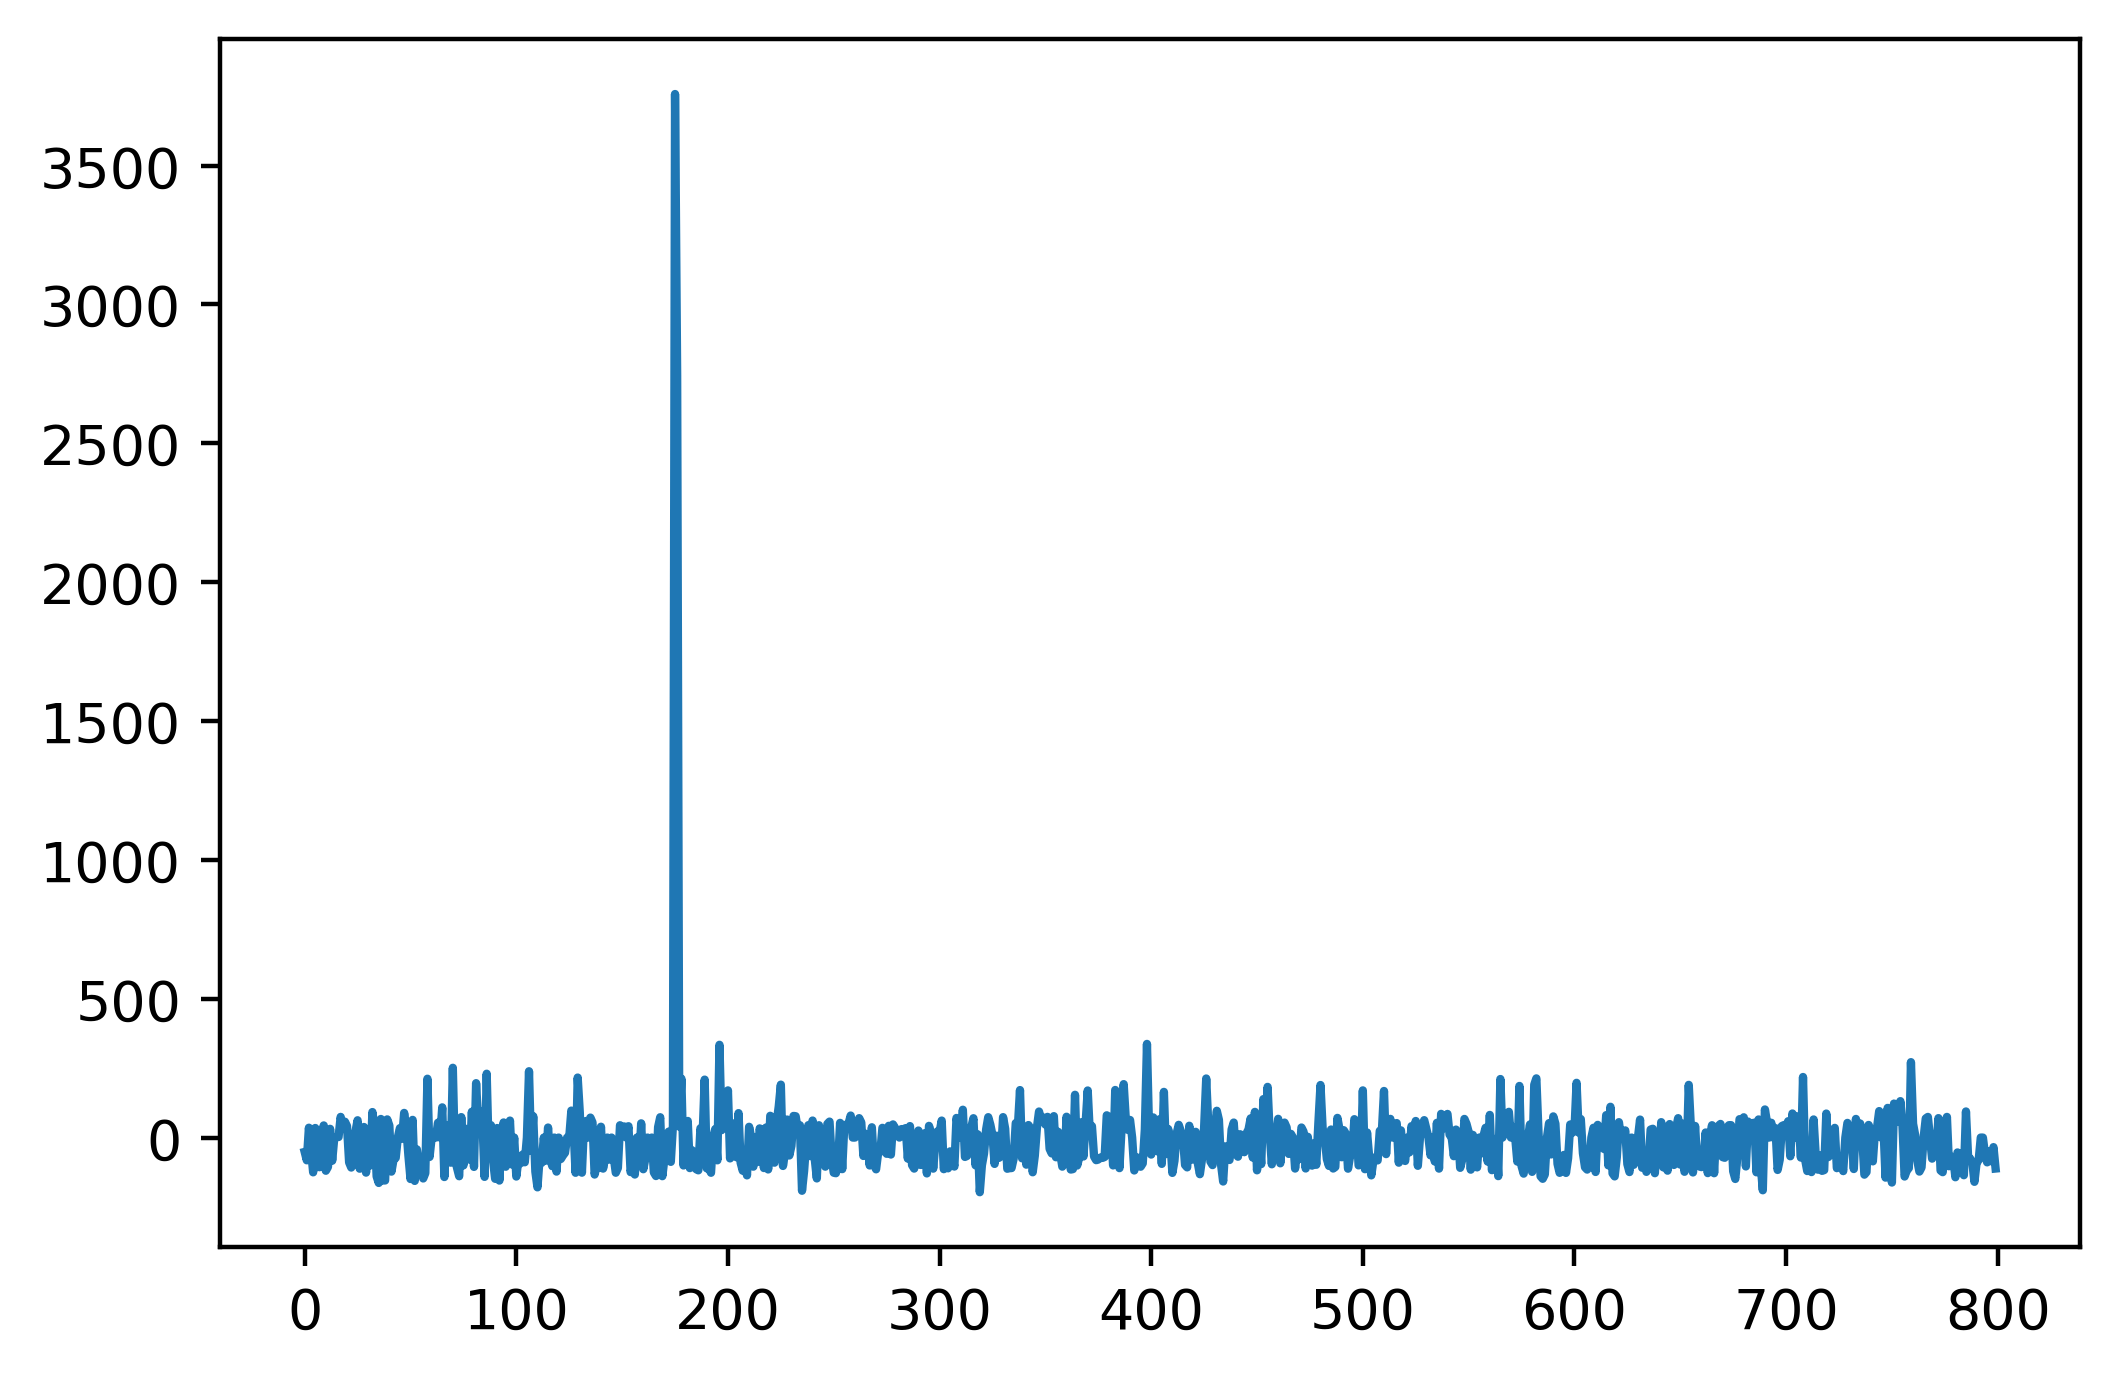

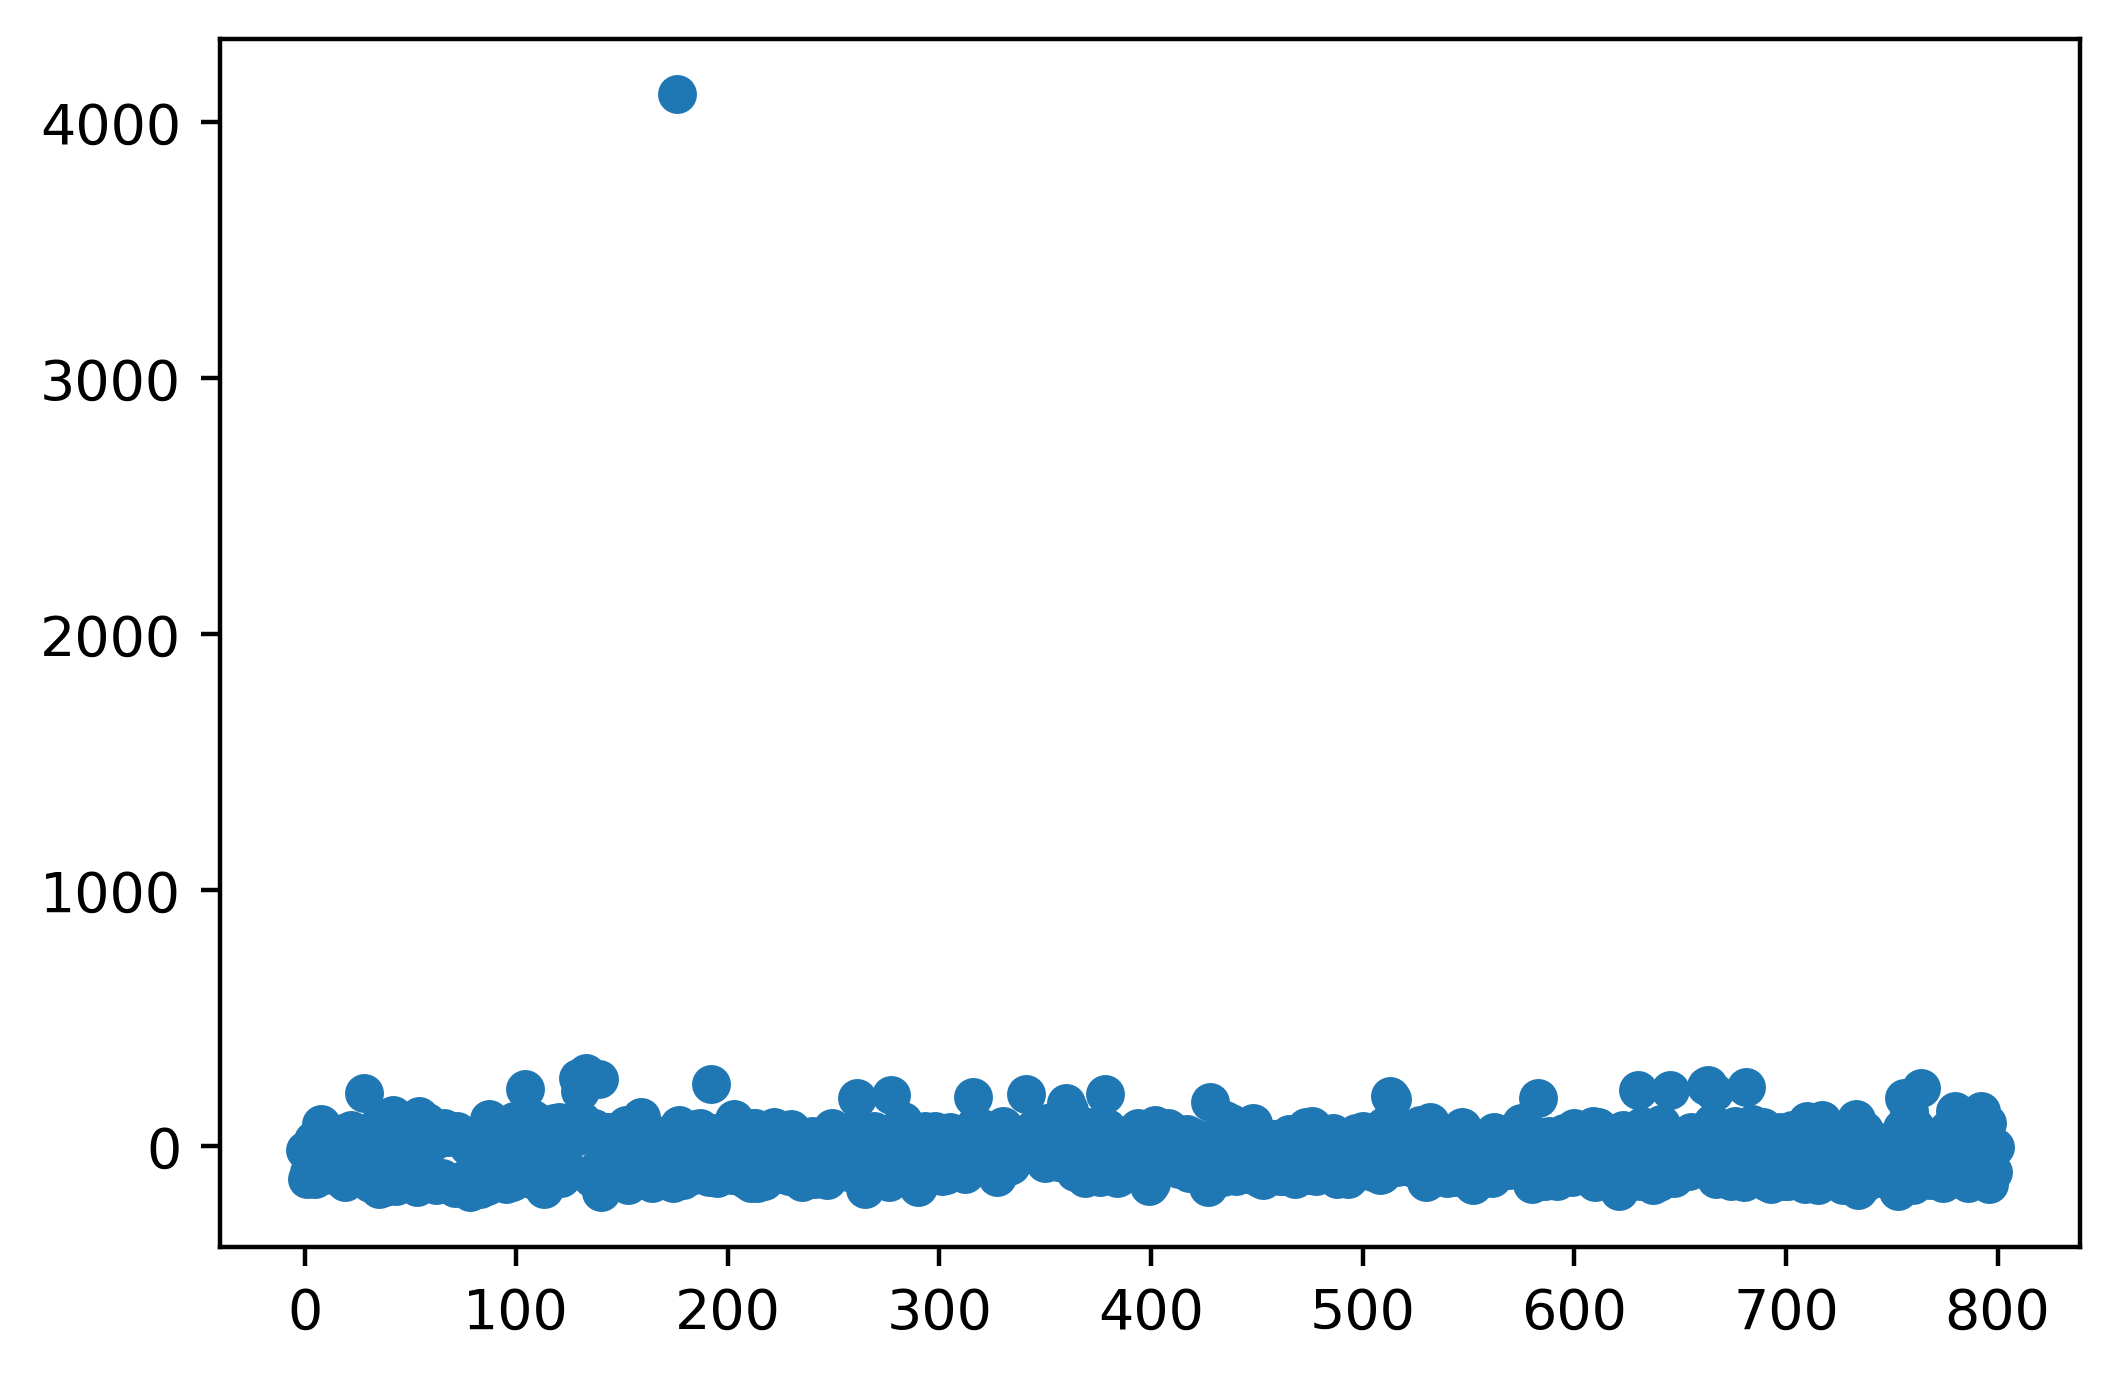

In [ ]:
test_img = img_array_WF3[9]
plt.plot(np.arange(0,800,1), test_img[0])
plt.show()
plt.scatter(np.arange(0,800,1), test_img[1])

... and the minimum is even larger than the maximum for many pictures.

In [ ]:
getheader(PICTURES_DIR + name)

SIMPLE  =                    T  /  FITS STANDARD                                
BITPIX  =                  -32  /  FITS BITS/PIXEL                              
NAXIS   =                    2  /  NUMBER OF AXES                               
NAXIS1  =                  800  /                                               
NAXIS2  =                  800  /                                               
OBJECT  = 'U12[2/4]'            /                                               
ORIGIN  = 'KPNO-IRAF'           /                                               
DATE    = '2001-12-19T15:27:28'                                                 
IRAFNAME= 'u12.c0h[2]'          /  NAME OF IRAF IMAGE FILE                      
IRAF-MAX=           5.984944E4  /  DATA MAX                                     
IRAF-MIN=          -7.910171E2  /  DATA MIN                                     
IRAF-BPX=                   32  /  DATA BITS/PIXEL                              
IRAFTYPE= 'REAL    '        

Potential answer from https://astronomy.stackexchange.com/questions/15092/sdss-image-fits-files-have-negative-values-what-do-these-negative-values-mean

Without more information about the specific nature of the fits file, my immediate guess is that you're using a file that has already been corrected for things like bias and flat fielding.

*It is true that for a simple exposure (what we might call the "science" image), the fits image should have only positive values as each pixel is a (proxy) count of how many photons hit it and how can you have a negative number of photons hit your detector? But often astronomers need to clean up their science image from various sources of noise. One such example is cleaning it with a bias frame. A bias frame is an exposure with the shutter closed and the exposure time set to zero. Essentially you just pull the signal from the CCD without taking a picture. In a perfect world, the CCD will be blank and empty and there will be nothing to read out if you never exposed, but in the real world things are messy and you have lingering electrons all over the place. Reading a bias frame allows you to get some estimate of this noise that can inherently exist in a CCD. An astronomer will then take this bias frame and subtract it from the science image to remove this noise, but of course this can result in your science image having negative pixel values. This usually isn't a problem though. *

But how could MOST of the pixels on HST have such a large bias then?



**Reading for the report** <br>
Timing analysis http://www.astro.sunysb.edu/metchev/AST443/timing.html <br>
Maybe useful for CCD analysis https://www1.phys.vt.edu/~jhs/phys3154/CCDPhotometryBook.pdf
http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/instruments/L12/index.html <br>
HST https://en.wikipedia.org/wiki/Hubble_Space_Telescope <br>
Cepheids <br> https://en.wikipedia.org/wiki/Cepheid_variable
